# The script does next:

### Open file $\to$ rotate $\to$ crop $\to$ preob $\to$ peaks $\to$ characteristic curve 

# Libraries

In [2]:
!pip3 install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 10.7 MB/s eta 0:00:0000:0100:01


In [3]:
#VERSIONS OF LIBRARIES!!!!
#HOW OPEN ANACONDA

import numpy as np ###v1.20.3
import astropy###v4.3.1
from astropy.io import fits
import matplotlib.pyplot as plt###v3.4.3
import cv2 #!pip3 install opencv-python ###v4.5.5
from scipy import signal ### v1.7.1
from scipy.signal import find_peaks
from astropy.io import fits
from PIL import Image###v8.4.0
from skimage import io, color###V0.18.3
import math
from tkinter import *

In [4]:
from PyQt5.QtGui import QImage, QPixmap

# Open txt files

Open file $\to$ make a list with data $\to$ make an array from list

In [5]:
def fits2png(filename):
    
    """
    The function open fits file and return PIL Image file for visualisation
    and array with initial data from fits file
    """
    
    data_fits = fits.open(f"{filename}")[0].data
#     plt.imshow(data_fits)
#     plt.gca().invert_yaxis()
#     plt.axis("off")
#     plt.savefig(f"{filename}.jpg")
#     plt.gca().invert_yaxis()
    plt.imsave(f"{filename}.jpg",data_fits[::-1])
#     image = Image.fromarray(np.uint8(data_fits*255/65536))
    #we should flip image because Image plot it by rows number
    #and here 0 row is bottom, when it must be top 
#     image = image.transpose(Image.FLIP_TOP_BOTTOM)
    
    return data_fits

In [145]:
data_call10s = fits2png("/home/ildana/spectrum_qs/10s.fit.fits")
data_call20s = fits2png("/home/ildana/spectrum_qs/20s.fit.fits")
data_call40s = fits2png("/home/ildana/spectrum_qs/40s.fit.fits")
data_call1m30s = fits2png("/home/ildana/spectrum_qs/1.5m.fit.fits")
data_call3m10s = fits2png("/home/ildana/spectrum_qs/3m10s.fit.fits")
data_call8m = fits2png("/home/ildana/spectrum_qs/8m.fit.fits")

FileNotFoundError: [Errno 2] No such file or directory: '/home/ildana/spectrum_qs/10s.fit.fits'

In [146]:
data_call10s = fits2png("new_specHB/10s.fit.fits")
data_call20s = fits2png("new_specHB/20s.fit.fits")
data_call40s = fits2png("new_specHB/40s.fit.fits")
data_call1m30s = fits2png("new_specHB/1.5m.fit.fits")
data_call3m10s = fits2png("new_specHB/3m10s.fit.fits")
data_call8m = fits2png("new_specHB/8m.fit.fits")

# Rotate and crop image

# Formula for bringing $\textbf{data to a convenient view}$. PREOB() function

# Table $\to$ row by mean value of coluns

$x_i = log_{10}\dfrac{x_max}{x_i}\times1000$

$x_i$ -- pixel value, $x_{max}$ -- maximum possible value. 

$x_{max}$ = 65536 if we have pixels value range (0,65536) and x_max = 255 if we have pixels value range (0,255)

We don't want to work with values like 26000 or smth like that, so we divide max pos value on our output value and take $log_{10}$. After that we get values of the order of 3-4. As soon as it too smal values and for axis stretching we multiply our value on 1000.

In [6]:
def subimage_preob_1(name_file,data, x1,y1,x2,y2,x3,y3,x4,y4): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
#     path = os.getcwd()#для просмотра корневой дирректории
    lina_color = io.imread(f'{name_file}')
    lina_gray = color.rgb2gray(lina_color)
 #открываем картинку (не повёрнута, не обрезана) # массив файла калибровки (наш o_call)
    difr= data/lina_gray
    lina_gray = lina_gray*difr
    for i in range(0,len(lina_gray)):
        for j in range(0,len(lina_gray[i])):
            lina_gray[i][j] = int(lina_gray[i][j])
            if lina_gray[i][j] != data[i][j]:
                lina_gray[i][j] = data[i][j]
    polygon_data = ((x1,y1), (x2, y2), (x3, y3), (x4, y4)) 
    center = centroid(polygon_data) #обращается к фукции centroid
    width = np.sqrt((x2-x1)**2+(y2-y1)**2)
    height = np.sqrt((x4-x1)**2+(y4-y1)**2)
    theta = math.atan2((x1-x2),(y1-y2))
    if center[0]<1 and center[1]<1 and width<1: #проверка на случай если мы работаем в относительных координатах и их пересчёт к абсолютным
        center_x = int(center[0]*lina_gray.shape[1])
        center_y = int(center[1]*lina_gray.shape[0])
        width = int(width * lina_gray.shape[1])
        height = int(height * lina_gray.shape[0])
        center = (center_x,center_y)
        
    shape = ( lina_gray.shape[1], lina_gray.shape[0] ) # cv2.warpAffine expects shape in (length, height)
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    lina_gray = cv2.warpAffine(src=lina_gray, M=matrix, dsize=shape ) #сохранение повернутого изображения из матрицы

    x = int( center[0] - width/2  ) #поиск координаты x слева
    y = int( center[1] - height/2 ) # поиск координаты у снизу

    lina_gray = lina_gray[ y:int(y+height), x:int(x+width) ] #обрезка изображения по координатам
    
    #preob
    im_array = lina_gray# создаем из нее массив 
    array_log10 = np.log10(65536/im_array)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)
    mean = array_log10.mean(axis=0) #среднее значение по столбцам
    
    
    plt.imshow(lina_gray) #path -- путь к корневой дирректории
    
    #возвращает обрезанное изображение
    return lina_gray,difr,lina_gray

In [7]:
def centroid(vertexes):
    x_list = [vertex[0] for vertex in vertexes]
    y_list = [vertex[1] for vertex in vertexes]
    lenth = len(vertexes)
    x = sum(x_list) / lenth
    y = sum(y_list) / lenth
    return(x, y)


In [8]:
def subimage_preob_2(name_file,data, x1,y1,x2,y2,x3,y3,x4,y4): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
#     path = os.getcwd()#для просмотра корневой дирректории
    lina_color = io.imread(f'{name_file}')
    lina_gray = color.rgb2gray(lina_color)
    tan = (y2-y1)/(x2-x1)
    radian = math.atan2((y1-y2),(x1-x2))
    theta = radian*180/np.pi
    print(theta)
    if theta > 90:
        theta = -180 + theta
    elif theta < -90:
        theta = 180 + theta
    else:
        theta = theta
    print(theta)
    for i in range(0,len(data)):
        for j in range(0,len(data[i])):
            lina_gray[i][j] = data[i][j]
    polygon_data = ((x1,y1), (x2, y2), (x3, y3), (x4, y4)) 
    center = centroid(polygon_data) #обращается к фукции centroid
    width = np.sqrt((x2-x1)**2+(y2-y1)**2)
    height = np.sqrt((x4-x1)**2+(y4-y1)**2)
    if center[0]<1 and center[1]<1 and width<1: #проверка на случай если мы работаем в относительных координатах и их пересчёт к абсолютным
        center_x = int(center[0]*lina_gray.shape[1])
        center_y = int(center[1]*lina_gray.shape[0])
        width = int(width * lina_gray.shape[1])
        height = int(height * lina_gray.shape[0])
        center = (center_x,center_y)
        
    shape = ( data.shape[1], data.shape[0] ) # cv2.warpAffine expects shape in (length, height)
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    lina_rotated = cv2.warpAffine(src=lina_gray, M=matrix, dsize=shape ) #сохранение повернутого изображения из матрицы

    x = int( center[0] - width/2  ) #поиск координаты x слева
    y = int( center[1] - height/2 ) # поиск координаты у снизу

    lina_croped = lina_rotated[ y:int(y+height), x:int(x+width) ] #обрезка изображения по координатам
    
    #preob
    array_log10 = np.log10(65536/lina_croped)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)
    mean = array_log10.mean(axis=0) #среднее значение по столбцам
    
    
    plt.imshow(lina_croped) #path -- путь к корневой дирректории
    plt.gca().invert_yaxis()
    #возвращает обрезанное изображение
    return lina_croped,mean

177.36554923559837
-2.6344507644016346


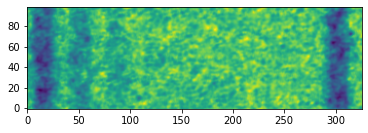

In [28]:
shape1 = o_call10s.shape[1]
shape0 = o_call10s.shape[0]

# x1= int(0.34974 * shape1)
# y1= int(0.58545 * shape0)
# x2= int(0.64378 * shape1)
# y2= int(0.56182 * shape0)
# x3= int(0.63267 * shape1)
# y3= int(0.42364 * shape0)
# x4= int(0.33863 * shape1)
# y4= int(0.44727 * shape0)

x1= int((0.356) * shape1)
y1= int((1-0.562) * shape0)
x2= int((0.646) * shape1)
y2= int((1-0.583) * shape0)
x3= int((0.657) * shape1)
y3= int((1-0.439) * shape0)
x4= int((0.367) * shape1)
y4= int((1-0.418) * shape0)


image_10s,mean_10s= subimage_preob('new_specHB/10s.fit.fits.jpg',o_call10s,x1,y1,x2,y2,x3,y3,x4,y4)

176.69178646612795
-3.308213533872049


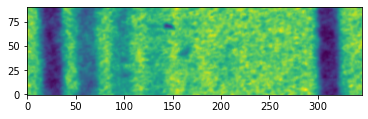

In [29]:
shape1 = o_call20s.shape[1]
shape0 = o_call20s.shape[0]

x1= int((0.349) * shape1)
y1= int((1-0.582) * shape0)
x2= int((0.656) * shape1)
y2= int((1-0.611) * shape0)
x3= int((0.668) * shape1)
y3= int((1-0.481) * shape0)
x4= int((0.362) * shape1)
y4= int((1-0.452) * shape0)

image_20s,mean_20s = subimage_preob('new_specHB/20s.fit.fits.jpg',o_call20s,x1,y1,x2,y2,x3,y3,x4,y4)

177.28979689982543
-2.7102031001745672


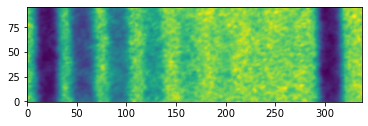

In [30]:
shape1 = o_call40s.shape[1]
shape0 = o_call40s.shape[0]

x1= int((0.345) * shape1)
y1= int((1-0.545) * shape0)
x2= int((0.646) * shape1)
y2= int((1-0.568) * shape0)
x3= int((0.656) * shape1)
y3= int((1-0.428) * shape0)
x4= int((0.355) * shape1)
y4= int((1-0.405) * shape0)

image_40s,mean_40s = subimage_preob('new_specHB/40s.fit.fits.jpg',o_call40s,x1,y1,x2,y2,x3,y3,x4,y4)

177.35237033470779
-2.6476296652922144


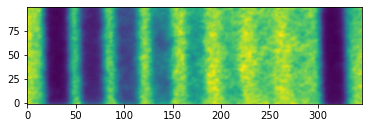

In [32]:
shape1 = o_call1m30s.shape[1]
shape0 = o_call1m30s.shape[0]

x1= int((0.333) * shape1)
y1= int((1-0.616) * shape0)
x2= int((0.640) * shape1)
y2= int((1-0.639) * shape0)
x3= int((0.652) * shape1)
y3= int((1-0.494) * shape0)
x4= int((0.345) * shape1)
y4= int((1-0.470) * shape0)

image_1m30s,mean_1m30s = subimage_preob('new_specHB/1.5m.fit.fits.jpg',o_call1m30s,x1,y1,x2,y2,x3,y3,x4,y4)

177.12963481568536
-2.870365184314636


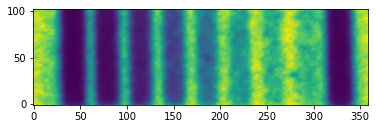

In [33]:
shape1 = o_call3m10s.shape[1]
shape0 = o_call3m10s.shape[0]

x1= int((0.295) * shape1)
y1= int((1-0.590) * shape0)
x2= int((0.614) * shape1)
y2= int((1-0.615) * shape0)
x3= int((0.626) * shape1)
y3= int((1-0.464) * shape0)
x4= int((0.307) * shape1)
y4= int((1-0.439) * shape0)

image_3m10s,mean_3m10s = subimage_preob('new_specHB/3m10s.fit.fits.jpg',o_call3m10s,x1,y1,x2,y2,x3,y3,x4,y4)

177.04753289112634
-2.9524671088736625


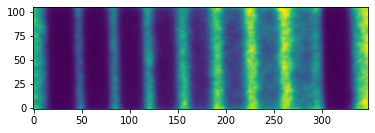

In [34]:
shape1 = o_call8m.shape[1]
shape0 = o_call8m.shape[0]

x1= int((0.326) * shape1)
y1= int((1-0.633) * shape0)
x2= int((0.636) * shape1)
y2= int((1-0.659) * shape0)
x3= int((0.649) * shape1)
y3= int((1-0.508) * shape0)
x4= int((0.339) * shape1)
y4= int((1-0.481) * shape0)

image_8m,mean_8m = subimage_preob('new_specHB/8m.fit.fits.jpg',o_call8m,x1,y1,x2,y2,x3,y3,x4,y4)

# Graph

Text(0.5, 1.0, 'call1')

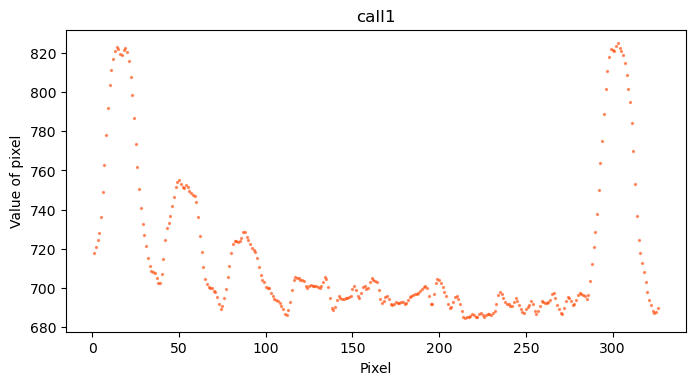

In [35]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_10s) + 1)
ax.scatter(x,mean_10s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call1')
# plt.xlim(50,100)

Text(0, 0.5, 'Почернение')

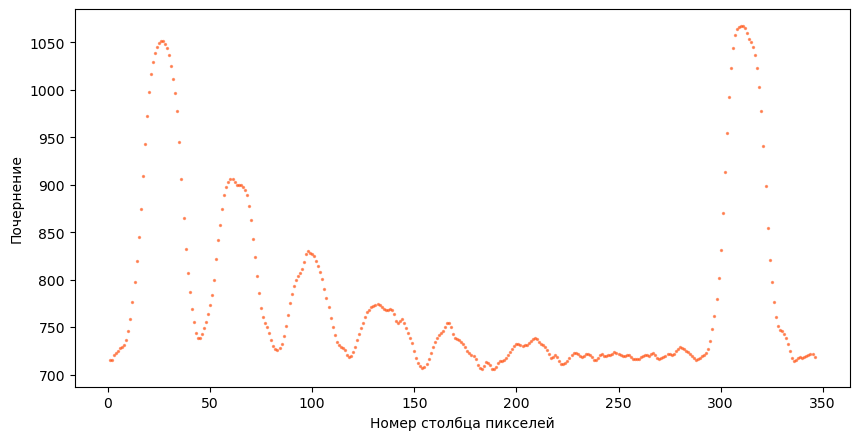

In [36]:
fig = plt.figure(figsize=(10,5),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_20s) + 1)
ax.scatter(x,mean_20s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Номер столбца пикселей")
ax.set_ylabel("Почернение")
# ax.set_title('call2')
# plt.xlim(50,100)
# plt.savefig("preob.jpg")

Text(0.5, 1.0, 'call3')

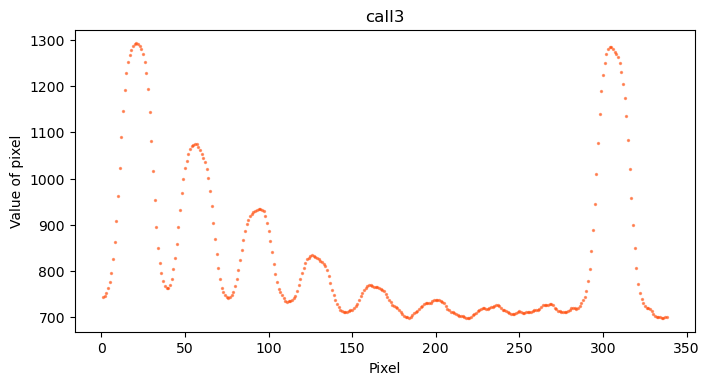

In [37]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_40s) + 1)
ax.scatter(x,mean_40s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call3')
# plt.xlim(50,100)

Text(0.5, 1.0, 'call4')

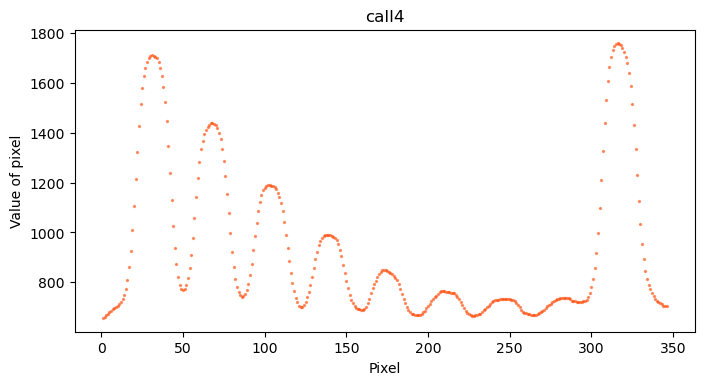

In [38]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_1m30s) + 1)
ax.scatter(x,mean_1m30s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call4')
# plt.xlim(50,100)

Text(0.5, 1.0, 'call4')

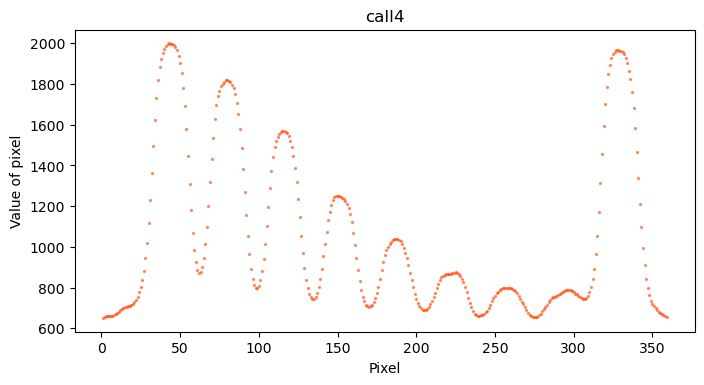

In [39]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_3m10s) + 1)
ax.scatter(x,mean_3m10s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call4')
# plt.xlim(50,100)

Text(0.5, 1.0, 'call4')

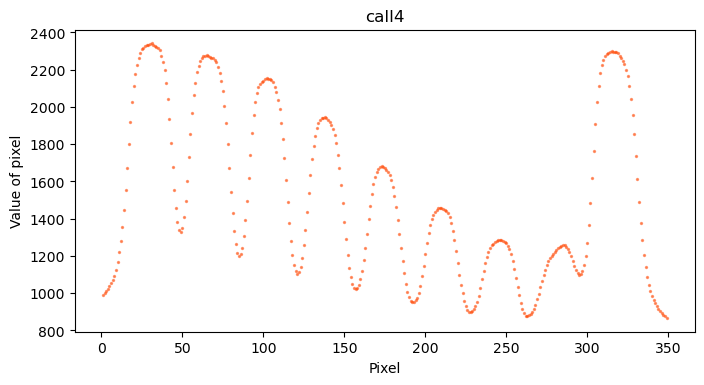

In [40]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_8m) + 1)
ax.scatter(x,mean_8m,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call4')
# plt.xlim(50,100)

# Peaks finding

In [9]:
def peaks(mean,order):
    """
    function for searching peaks in array 
    """
    peak_indexes = signal.argrelextrema(mean, np.greater, order=order)[0] #индексы пиков 
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in peak_indexes:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа
    return peak_indexes,peak_mean

In [78]:
peak_indexes_1,peak_mean_1 = peaks(mean_10s,order=18)
peak_indexes_2,peak_mean_2 = peaks(mean_20s,order=14)
peak_indexes_3,peak_mean_3 = peaks(mean_40s,order=8)
peak_indexes_4,peak_mean_4 = peaks(mean_1m30s,order=9)
peak_indexes_5,peak_mean_5 = peaks(mean_3m10s,order=9)
peak_indexes_6,peak_mean_6 = peaks(mean_8m,order=9)

### Peaks graph

<ipython-input-79-8f566b9d4354>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_1, mean_10s[[peak_indexes_1]], color = 'y', s = 10, marker = 'D', label = 'maxima')


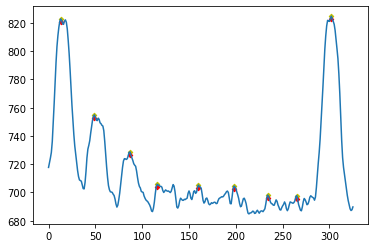

In [79]:
x1 = np.arange(0,len(mean_10s))
plt.plot(x1,mean_10s)
plt.scatter(peak_indexes_1, mean_10s[[peak_indexes_1]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_1, peak_mean_1, color = 'r', s = 10, marker = 'D', label = 'maxima')

<ipython-input-62-62e9a2afc7d0>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_2, mean_20s[[peak_indexes_2]], color = 'y', s = 10, marker = 'D', label = 'maxima')


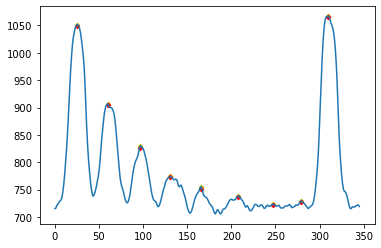

In [62]:
x2 = np.arange(0,len(mean_20s))
plt.plot(x2,mean_20s)
plt.scatter(peak_indexes_2, mean_20s[[peak_indexes_2]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_2, peak_mean_2, color = 'r', s = 10, marker = 'D', label = 'maxima')

<ipython-input-56-9b7644853d86>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_3, mean_40s[[peak_indexes_3]], color = 'y', s = 10, marker = 'D', label = 'maxima')


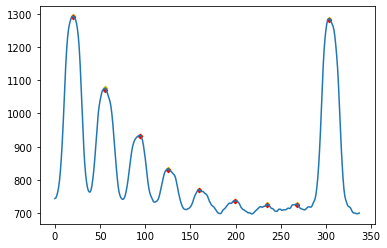

In [56]:
x3 = np.arange(0,len(mean_40s))
plt.plot(x3,mean_40s)
plt.scatter(peak_indexes_3, mean_40s[[peak_indexes_3]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_3, peak_mean_3, color = 'r', s = 10, marker = 'D', label = 'maxima')

<ipython-input-50-9a1ace4933bc>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_4, mean_1m30s[[peak_indexes_4]], color = 'y', s = 10, marker = 'D', label = 'maxima')


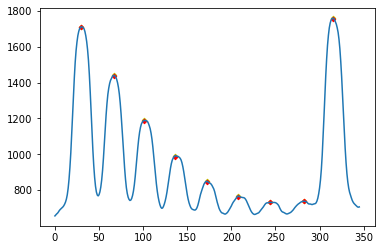

In [50]:
x4 = np.arange(0,len(mean_1m30s))
plt.plot(x4,mean_1m30s)
plt.scatter(peak_indexes_4, mean_1m30s[[peak_indexes_4]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_4, peak_mean_4, color = 'r', s = 10, marker = 'D', label = 'maxima')

<ipython-input-52-8c8ebcf22d67>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_5, mean_3m10s[[peak_indexes_5]], color = 'y', s = 10, marker = 'D', label = 'maxima')


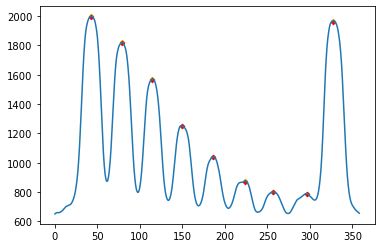

In [52]:
x5 = np.arange(0,len(mean_3m10s))
plt.plot(x5,mean_3m10s)
plt.scatter(peak_indexes_5, mean_3m10s[[peak_indexes_5]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_5, peak_mean_5, color = 'r', s = 10, marker = 'D', label = 'maxima')

<ipython-input-51-9af1af95c398>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_6, mean_8m[[peak_indexes_6]], color = 'y', s = 10, marker = 'D', label = 'maxima')


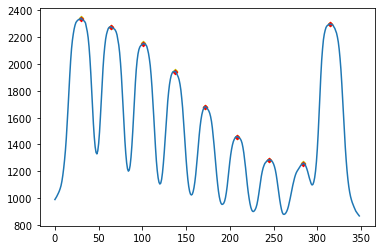

In [51]:
x6 = np.arange(0,len(mean_8m))
plt.plot(x6,mean_8m)
plt.scatter(peak_indexes_6, mean_8m[[peak_indexes_6]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_6, peak_mean_6, color = 'r', s = 10, marker = 'D', label = 'maxima')

## Our function for peaks

In [10]:
def peaks(mean):    
    
    for ind,p in enumerate(mean): 
        
        if p < mean[ind+1]:
            continue
        
        else:
            first_peak_ind = ind
            break

    random_peak_ind=[first_peak_ind]
    
    for ind in range(first_peak_ind+1,len(mean)-1):
        
        if mean[ind] > mean[ind-1] and mean[ind] > mean[ind+1]:
            random_peak_ind.append(ind)
            
    bad_peaks = []
    good_peaks = []
    min_dist = 10
    counter = 0
    
    for ind in range(0,len(random_peak_ind)-1):
        delta = random_peak_ind[ind+1] - random_peak_ind[ind]
        
        if delta < min_dist:
            bad_peaks.append(random_peak_ind[ind])
            bad_peaks.append(random_peak_ind[ind+1])
        
        else:
            
            if len(bad_peaks)==0:
                good_peaks.append(random_peak_ind[ind])
            
            else:
                bad_peaks = np.array(np.unique(bad_peaks))
                mean_index = int(bad_peaks.mean())
                good_peaks.append(mean_index)
                bad_peaks = []

    good_peaks.append(random_peak_ind[-1])
    
    if len(good_peaks) > 9:
        
        if mean[[good_peaks[-1]]] < mean[[good_peaks[-2]]]:
            good_peaks = good_peaks[:-1] 
            
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in good_peaks:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа        

    return good_peaks, peak_mean                    

In [66]:
good_peaks_1, peak_mean_1 = peaks(mean_10s)

# good_peaks_2, peak_mean_2 = peaks(mean_2)

In [25]:
good_peaks_3, peak_mean_3 = peaks(mean_3)

In [30]:
good_peaks_4, peak_mean_4 = peaks(mean_4)

<ipython-input-69-92ae4f00d70e>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(good_peaks_1, mean_10s[[good_peaks_1]], color = 'r', s = 10, marker = 'D', label = 'maxima')


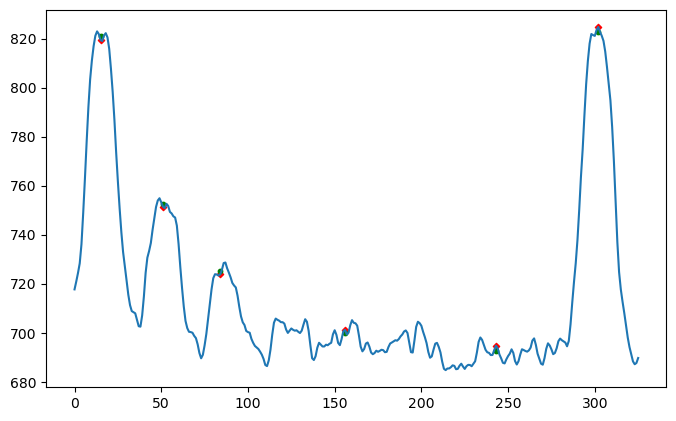

In [69]:
plt.figure(figsize = (8,5),dpi=100)
x4 = np.arange(0,len(mean_10s))
plt.plot(x4,mean_10s)
plt.scatter(good_peaks_1, mean_10s[[good_peaks_1]], color = 'r', s = 10, marker = 'D', label = 'maxima')       
plt.scatter(good_peaks_1, peak_mean_1, color = 'g', s = 10, marker = 'o', label = 'maxima')       

<ipython-input-27-79a81b671e43>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(good_peaks_2, mean_2[[good_peaks_2]], color = 'r', s = 15, marker = 'D', label = "Пики")


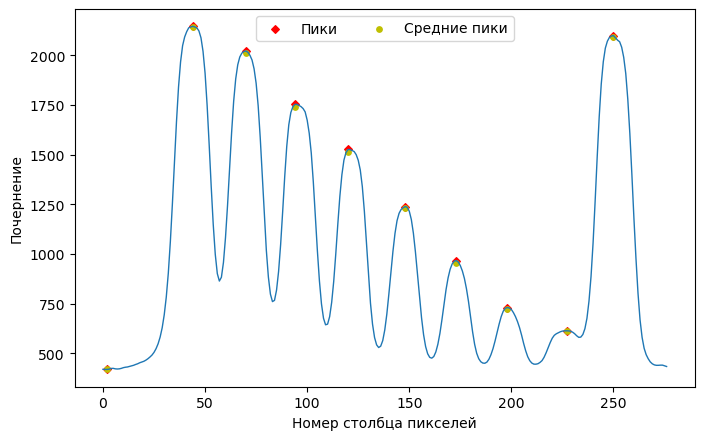

In [27]:
plt.figure(figsize = (8,5),dpi=100)
x4 = np.arange(0,len(mean_2))
plt.plot(x4,mean_2,lw=1)
plt.scatter(good_peaks_2, mean_2[[good_peaks_2]], color = 'r', s = 15, marker = 'D', label = "Пики")       
plt.scatter(good_peaks_2, peak_mean_2, color = 'y', s = 15, marker = 'o',  label = "Средние пики")       
plt.legend(ncol=2,loc=9)
plt.xlabel("Номер столбца пикселей")
plt.ylabel("Почернение")
plt.savefig("peaks.jpg")

<ipython-input-28-9f98bacd1b97>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(good_peaks_3, mean_3[[good_peaks_3]], color = 'r', s = 10, marker = 'D', label = 'maxima')


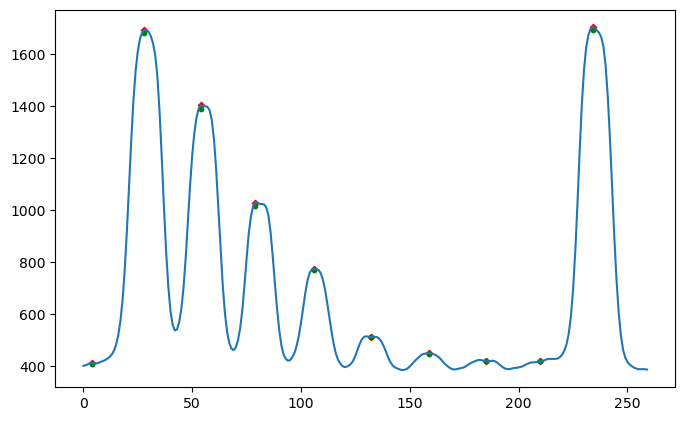

In [28]:
plt.figure(figsize = (8,5),dpi=100)
x4 = np.arange(0,len(mean_3))
plt.plot(x4,mean_3)
plt.scatter(good_peaks_3, mean_3[[good_peaks_3]], color = 'r', s = 10, marker = 'D', label = 'maxima')       
plt.scatter(good_peaks_3, peak_mean_3, color = 'g', s = 10, marker = 'o', label = 'maxima')       

NameError: name 'good_peaks_4' is not defined

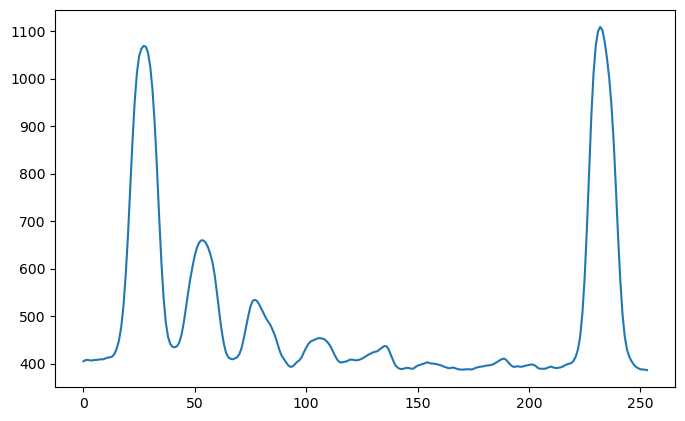

In [45]:
plt.figure(figsize = (8,5),dpi=100)
x4 = np.arange(0,len(mean_4))
plt.plot(x4,mean_4)
plt.scatter(good_peaks_4, mean_4[[good_peaks_4]], color = 'r', s = 10, marker = 'D', label = 'maxima')       
plt.scatter(good_peaks_4, peak_mean_4, color = 'g', s = 10, marker = 'o', label = 'maxima')       

# Сharacteristic curve

Data for step attenuators in stellar magnitudes (L.N. gave):

$Period / step$| $1$ | $2$    | $3$    | $4$    | $5$    | $6$    | $7$    | $8$    | $9$ |
---          |---|---   |---   |---   |---   |---   |---   |---   |---|
$before~1972  $| $0$ | $0.61$ | $1.1 $ | $1.47$ | $1.84$ | $2.25$ |$ 2.66$ |$ 3.04$ | $0$ |
$after~1972   $| $0$ | $0.5 $ | $0.97$ | $1.44$ | $1.93$ | $2.43$ |$2.69 $ |$3.04 $ | $0$ |

The $1^{st}$ and the $9^{th}$ steps have the same value.

When we plot graph we will see that we should shift our point
We have different exposure time, so our graphs looks not similary
For right shifting we should find log of deviding maximum exposure for other and multiply it by 2.5

$delta_i = 2.5 \times \dfrac{exposure_{max}}{exposure_i}$

In [8]:
#Data for step attenuators in stellar magnitudes (L.N. gave) 
mag_before_1972 = [0,0.61,1.1,1.47,1.84,2.25,2.66,3.04,0]
mag_after_1972 = [0,0.5,0.97,1.44,1.93,2.43,2.69,3.04,0]

# delta_m1 = 2.5*np.log(480/10)
# delta_m2 = 2.5*np.log(480/20)
# delta_m3 = 2.5*np.log(480/40)
# delta_m4 = 2.5*np.log(480/90)
# delta_m5 = 2.5*np.log(480/190)
# delta_m6 = 2.5*np.log(480/480)
delta_m1 = 2.5*np.log(480/130)
delta_m2 = 2.5*np.log(480/140)
delta_m3 = 2.5*np.log(480/160)
delta_m4 = 2.5*np.log(480/210)
delta_m5 = 2.5*np.log(480/310)
delta_m6 = 2.5*np.log(480/480)

Text(0, 0.5, 'Почернение')

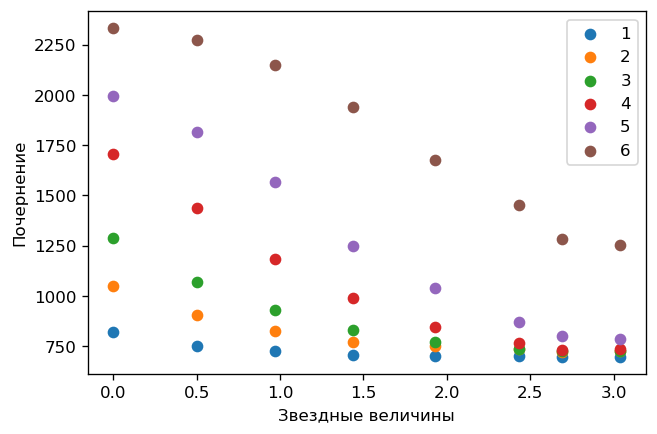

In [130]:
plt.figure(figsize=(6,4),dpi=120)

plt.scatter(mag_after_1972[:-1],peak_mean_1[:-1], label=1)
plt.scatter(mag_after_1972[:-1],peak_mean_2[:-1], label=2)
plt.scatter(mag_after_1972[:-1],peak_mean_3[:-1], label=3)
plt.scatter(mag_after_1972[:-1],peak_mean_4[:-1], label=4)
plt.scatter(mag_after_1972[:-1],peak_mean_5[:-1], label=5)
plt.scatter(mag_after_1972[:-1],peak_mean_6[:-1], label=6)

plt.legend()
plt.xlabel("Звездные величины")
plt.ylabel("Почернение")
# plt.savefig("peaks_curve_deviated.jpg")


Text(0, 0.5, 'Почернение')

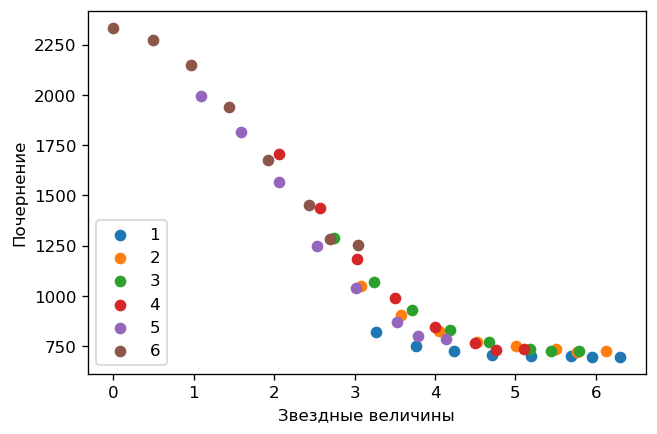

In [150]:
plt.figure(figsize=(6,4),dpi=120)

plt.scatter(mag_after_1972[:-1]+delta_m1,peak_mean_1[:-1], label=1)
plt.scatter(mag_after_1972[:-1]+delta_m2,peak_mean_2[:-1], label=2)
plt.scatter(mag_after_1972[:-1]+delta_m3,peak_mean_3[:-1], label=3)
plt.scatter(mag_after_1972[:-1]+delta_m4,peak_mean_4[:-1], label=4)
plt.scatter(mag_after_1972[:-1]+delta_m5,peak_mean_5[:-1], label=5)
plt.scatter(mag_after_1972[:-1]+delta_m6,peak_mean_6[:-1], label=6)
plt.legend(loc=3)
plt.xlabel("Звездные величины")
plt.ylabel("Почернение")
# plt.savefig("peaks_curve_alighned.jpg")

In [151]:
array = [peak_mean_1[:-1],peak_mean_2[:-1],peak_mean_3[:-1],peak_mean_4[:-1],peak_mean_5[:-1],peak_mean_6[:-1]]
y_array = np.concatenate(array)
x_array = np.concatenate([mag_after_1972[:-1]+delta_m1,mag_after_1972[:-1]+delta_m2,mag_after_1972[:-1]+delta_m3,mag_after_1972[:-1]+delta_m4,mag_after_1972[:-1]+delta_m5,mag_after_1972[:-1]+delta_m6])

# Cleaning

If we have values wich differ more than 3$\sigma$ from previous value or 5$\sigma$ from mean

# Mean deviation

In [13]:
# array = [peak_mean_1[1:-1],peak_mean_2[:8],peak_mean_3[:8],peak_mean_4[:-1]]
# y_array = np.concatenate(array)
# x_array = np.concatenate([mag_after_1972[:-1]+delta_m1,mag_after_1972[:-1]+delta_m2,mag_after_1972[:-1]+delta_m3,mag_after_1972[:-1]+delta_m4])

#we calculate mean deveation by calculating delta between each neighboring element, sum it and the devide by number of elements 
c = []
for i in range(1,len(y_array)):
    c.append(abs(y_array[i] - y_array[i-1]))
mean_deviation = np.array(c).sum()/len(y_array)

#now we sort our data: if delta between neighboring elements larger than 2 mean deveation we will remove it
indexes = []
for i in range(1,len(y_array)):
    if abs(y_array[i]-y_array[i-1])>mean_deviation*2:
        indexes.append(i)

y_array = np.delete(y_array,indexes)
x_array = np.delete(x_array,indexes)
#Imax = 10000
xarray_flux = 10000/10**(x_array/2.5)

NameError: name 'y_array' is not defined

In [153]:
#now we shoudl sort our data to don't get convoluted curve

a = []
for i in range(0,len(xarray_flux)):
    a.append([xarray_flux[i],y_array[i]])

a.sort(key=lambda x:x[0])

xarray_flux = []
y_array = []

for i in range(0,len(a)):
    xarray_flux.append(a[i][0])
    y_array.append(a[i][1])
    
xarray_flux = np.array(xarray_flux)
y_array = np.array(y_array)       

del a

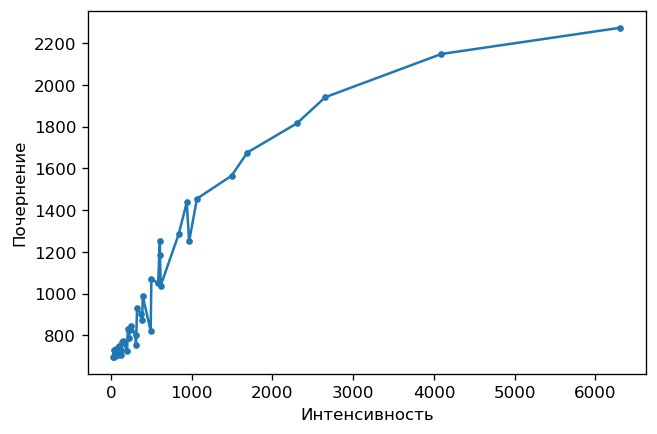

In [154]:
plt.figure(figsize=(6,4),dpi=120)
plt.plot(xarray_flux, y_array, markersize=3,marker='o' )
# plt.ylim(0,4000)
# plt.xlim(0,1000)
plt.xlabel("Интенсивность")
plt.ylabel("Почернение")
plt.savefig("characteristic_curve_first.jpg")

In [12]:
def aprx(x,y,order):

    monotone = False
    while monotone == False:
        
        z = np.polyfit( x,y,order)
        p = np.poly1d(z)
        xp = np.linspace(0, x[-1], 1000)
        # print(xp)
        pxp = p(xp)

        for i in range(1,len(pxp)):
            max_pxp = y[:-1].max()
            if pxp[i]<=pxp[i-1]:
                pxp[i]=pxp[i-1]+1
                if pxp[i]>=max_pxp:
                    min_pxp = pxp[i-100]
                    delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                    index = i-10
                    break


        for j in range(index+1,len(pxp)):
            pxp[j]=pxp[j-1]+delta_pxp

        z = np.polyfit( xp,pxp, 6)
        pp = np.poly1d(z)
        xpp = np.linspace(0, x[-1], 1000)

        pxpp = pp(xpp)
        
        check = []
        for k in range(0,len(pxpp)-1):      
            if pxpp[k]>pxpp[k+1]:
                check.append(k)
        
        if len(check) == 0:
                monotone = True
        else:
            order = order+1
            monotone = False
               
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=80)
    ax1 = plt.scatter(x[:-1],y[:-1], color="blue",s=5) 
    ax1 = plt.plot(xp, p(xp), color="orange")           

    fig, ax2 = plt.subplots(figsize=(6,4),dpi=120)
    ax2 = plt.plot( xpp, pp(xpp), lw=1, label = f"Апроксимация полиномом ({order},6)")#"Polynomial approximation")
    ax2 = plt.scatter(x[:-1],y[:-1], color="red",s=50,marker='.')#, label = "Attenuator magnitude")
    plt.legend()
    plt.xlabel("Интенсивность")
    plt.ylabel("Почернение")
#     plt.yticks([200, 300, 400, 500, 600, 700, 800, 900])
    plt.savefig("characteristic_curve.jpg")
    return xpp,pp

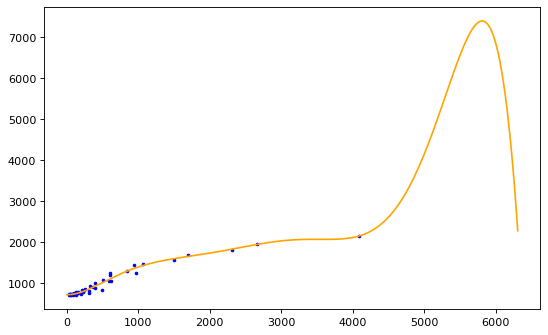

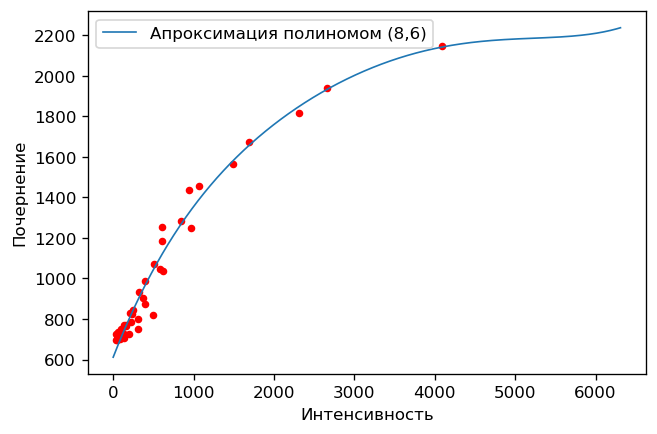

In [158]:
xpp,polinomial = aprx(xarray_flux,y_array,6)

In [159]:
print(polinomial)

            6             5             4             3             2
-2.113e-20 x + 1.065e-15 x - 1.431e-11 x + 9.032e-08 x - 0.0003553 x + 1.022 x + 611.6


# Spectrum 

In [11]:
def polynomial_alighn(data,low_limit,up_limit,order):
    
    """
    function aligns the spectrum through finding min value in each column and approximate it with polynomial and mean for polinomial line
    
    data - whole image
    up_limit,low_limit - limits of spectra in rows number
    order - polinomial order to approximate spectra
    
    """
    
    data_part = data[low_limit:up_limit]
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
    ax1.imshow(data_part, cmap='gray')
#     plt.imsave('pic_lamp_20s.jpg', data_part)
    ax1.set_title("Initial part of spectra")
#     plt.savefig("initial_part.eps")
    
    #create massive of part of whole spectra with arrays of columns, not rows
    data_columns = []
    for i in range(0,len(data_part[0])):
        data_columns.append(list(data_part[:,i]))
    data_columns=list(data_columns)
    
    #create massive of whole spectra with arrays of columns, not rows
    data_collumns_entire_image = []
    for j in range(0,len(data[0])):
        data_collumns_entire_image.append(list(data[:,j]))
    data_collumns_entire_image=list(data_collumns_entire_image)

    #find min value in each column and then find indexes of the values - they will be Y-coordinate
    data_col_min = data_part.min(axis=0)

#     data_col_min = data_part.max(axis=0)
    index = []
    for i in range(0,len(data_col_min)):
            index.append(data_columns[i].index(data_col_min[i]))


    #find median value of neighboring indexes of min values in each column in some ranges to compairing in the next steps
    #we schould find mediam values for ranges not for whole image, because we have non-linear graph and it has curvature  
    median = []
    n = 0
    while n+100<len(index):
        k=n+100
        median.append([n,k,np.min(index[n:k])])
        n=k
    else:
        median.append([n,-1,np.min(index[n:])])

    #calculate mean delta between neighboring values
    delt=[]
    for i in range(1,len(index)):
        delt.append(abs(index[i]-index[i-1]))
    delt_mean = np.array(delt).sum()/len(delt)    

    #now we compair difference between median value indexes of minimum value in each column     
    for i in median:
        for j in range(i[0],i[1]):
            if abs(i[2]-index[j])>delt_mean:
                index[j] = i[2]

    fig, ax2 = plt.subplots(figsize=(8,5),dpi=100)
    ax2.plot(index)
    
    #plot polynomial
    xp = np.arange(0,len(index))
    z = np.polyfit(xp,index, order)
    polynomial = np.poly1d(z)
    y_polynomial = polynomial(xp)
    ax2.plot(index, color="steelblue", label="Медианное значение") 
    ax2.plot(xp, y_polynomial, color="orange", label=f"Полином ({order})")
#     ax2.set_title("Polinomial approximation of spectra")
    ax2.set_xlabel("Номер столбца пикселей")
    ax2.set_ylabel("Номер строки пикселей")
    ax2.legend()
    plt.savefig("polinomial_spectra.jpg")
    
    xp_tg = np.arange(0,len(y_polynomial))
    z_tg = np.polyfit(xp_tg,y_polynomial, 1)
    polynomial_tg = np.poly1d(z_tg)
    y_polynomial_tg = polynomial_tg(xp_tg)
    tg = polynomial_tg[1]
    
    #now we will plot our curve on our frame
    mean_polynomial = y_polynomial.mean()
    fig, ax3 = plt.subplots(figsize=(8,5),dpi=100)
    ax3.imshow(data_part, cmap='gray')
    ax3.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax3.axhline(mean_polynomial, label="Polinomial mean")
    ax3.set_axis_off()
#     ax3.legend(bbox_to_anchor=(1.01,0.5))
    plt.savefig("polinomial_mean.jpg")
    
    delta_y = []
    for i in range(0,len(index)):
        delta = mean_polynomial - polynomial(xp)[i] #initial
#         delta = mean_polynomial + polynomial(xp)[i] 
        
        delta_y.append(int(delta))

    shape = np.array(data_collumns_entire_image).shape
    new_pic_col = np.zeros(shape)
    for i in range(0,len(data_collumns_entire_image)):
        for j in range(0,len(data_collumns_entire_image[i])):
            m  = j + delta_y[i] #initial
#             m  = j - delta_y[i]
            
            if m<len(data_collumns_entire_image[i]):#### initial <
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
            else:
                m = m - len(data_collumns_entire_image[i])
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
    data_rows = []
    for i in range(0,len(new_pic_col[0])):
        data_rows.append(list(new_pic_col[:,i]))
            
    
    delta_x = np.arange(0,len(data_rows))*tg
    shape = np.array(data_rows).shape
    new_data_rows = np.zeros(shape)
    for i in range(0,len(data_rows)):
        for j in range(0,len(data_rows[i])):
            m  = int(j + 2*delta_x[i])
            if m<len(data_rows[i]):
                new_data_rows[i][m] = data_rows[i][j] 
            else:
                m = m - len(data_rows[i])
                new_data_rows[i][m] = data_rows[i][j] 
    
    aligned_image = new_data_rows
    
    fig, ax4 = plt.subplots(figsize=(8,5),dpi=100)
    ax4.imshow(aligned_image, cmap='gray')
    plt.axis("off")
    # ax4.grid()
#     ax4.set_title("Aligned spectra")
    plt.savefig("aligned_spectra.jpg")
    
    return aligned_image

In [137]:
fits_ = fits.open('new_specHB/5124.fit.fits')

data  = fits_[0].data

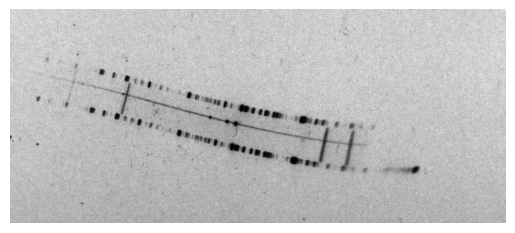

In [138]:
plt.imshow(data, cmap='gray')
plt.axis("off")
plt.imsave("data.jpg",data)

-165.48018557587324
14.519814424126764


/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/700308130.py:44: RuntimeWarning: divide by zero encountered in true_divide
  array_log10 = np.log10(65536/lina_croped)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)


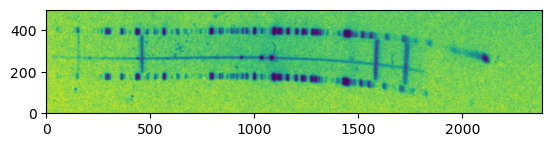

In [139]:
shape1 = data.shape[1]
shape0 = data.shape[0]

x1= int((0.148) * shape1)
y1= int((1-0.828) * shape0)
x2= int((0.989) * shape1)
y2= int((1-0.323) * shape0)
x3= int((0.841) * shape1)
y3= int((1-0.078) * shape0)
x4= int((0.) * shape1)
y4= int((1-0.582) * shape0)

image,mean = subimage_preob('data.jpg',data,x1,y1,x2,y2,x3,y3,x4,y4)
del mean

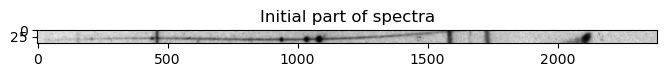

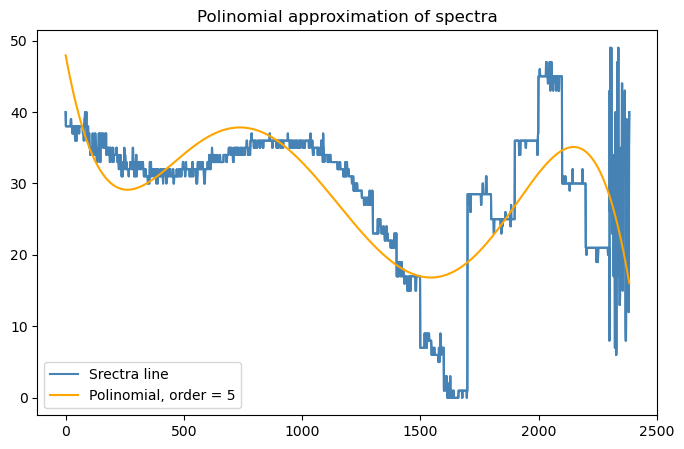

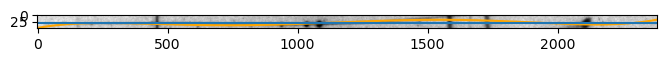

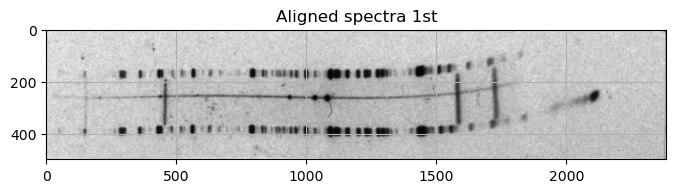

In [144]:
# spectra= polynomial_alighn(image,50,200,5)
spectra= polynomial_alighn(image,230,280,5)

In [141]:
def preob_spectra(spectra):
    
    """
    Функция пересчитывает плотности почернения в интенсивности при помощи полинома, полученного 
    в работе с калибровками.
    На выходе преобразованный спектр и график, из которого необходимо определить на каких строках (х1 и х1) находится спектр.
    Тут же можно определить где находятся лампы.
    """
    x_log = (np.log10(65536/spectra) * 1000)
#     spectra_ = (2.803e-20*x_log**6 - 5.835e-16*x_log**5 + 1.635e-12*x_log**4 + 4.247e-08*x_log**3 - 0.0004067*x_log**2 + 1.439*x_log + 196.7).sum()
    
    spectra_ = polinomial(x_log)
    
#     
    sum_intens_row = spectra_.sum(axis=1)
    
    plt.figure(figsize=(6,4),dpi=120)
    plt.plot(sum_intens_row)
#     plt.grid(lw=0.1)
    plt.xlabel("Номер строки пикселей")
    plt.ylabel("Сумма интенсивностей")
    plt.savefig("spectra_background_rows.jpeg")
    return spectra_

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/775091044.py:9: RuntimeWarning: divide by zero encountered in true_divide
  x_log = (np.log10(65536/spectra) * 1000)
/Users/ildana_izm/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


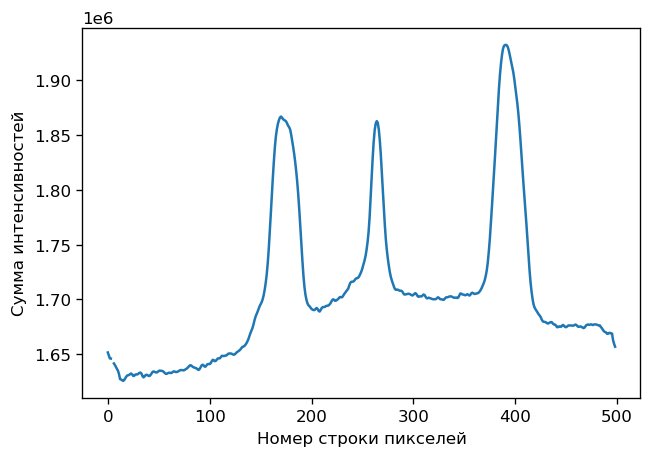

In [142]:
spectra_preob = preob_spectra(spectra)

In [143]:
def spectra_lamps(data,y1,y2,y3,y4):
    
    """
    Функция для вырезания из целого изображения спектра двух ламп и
    спектра самого объекта по отдельнсти.
    """
    
    lamp_1 = data[y1:y2]
    spectra = data[y2:y3]
    lamp_2 = data[y3:y4]
    
    return lamp_1, spectra, lamp_2

In [47]:
lamp_1, spectra_back, lamp_2 = spectra_lamps(spectra_preob,230,286,340,400)

In [15]:
def spectra_background(data,x1,x2):
    
    """
    Разбивает часть изображения со спектром на фон (над и под) и спектр.
    Вычитает фон из спектра и 
    на выходе выдает ГОТОВЫЙ спектр (+график, конечно же)
    """
    
    back_1 = data[0:x1]
    back_2 = data[x2:]
    back = np.concatenate((back_1,back_2))
    back_mean = back.mean(axis=0)
    
    spectrum = data[x1:x2]
    spectrum_sum = np.array(spectrum).sum(axis=0)
    spectrum_final = spectrum_sum - back_mean*(x2-x1)
    
    plt.figure(figsize=(8,4),dpi=120)
    plt.plot(spectrum_final)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
    plt.savefig("spectra_obj_back.jpg")
    
    return spectrum_final

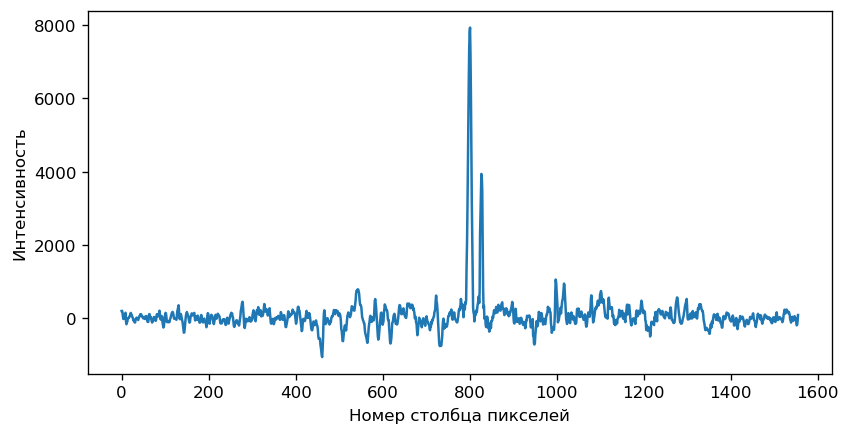

In [49]:
spectrum_final = spectra_background(spectra_back,16,33)

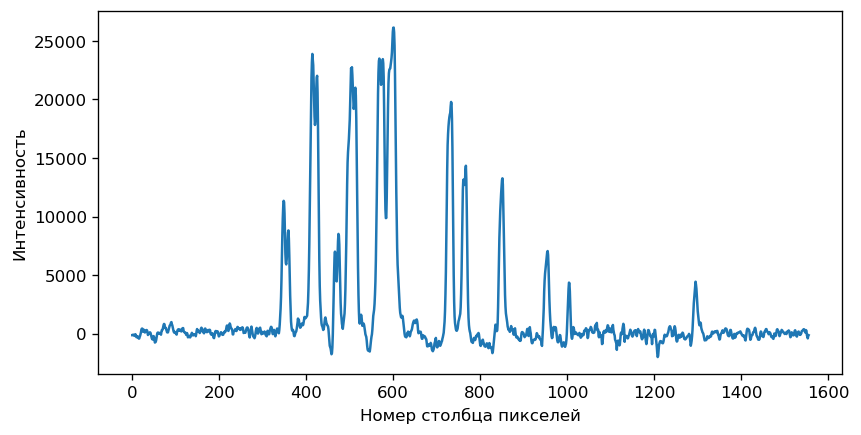

In [50]:
spectrum_final_lamp1 = spectra_background(lamp_1,10,47)
# plt.axhline(spectrum_final_lamp1.mean())

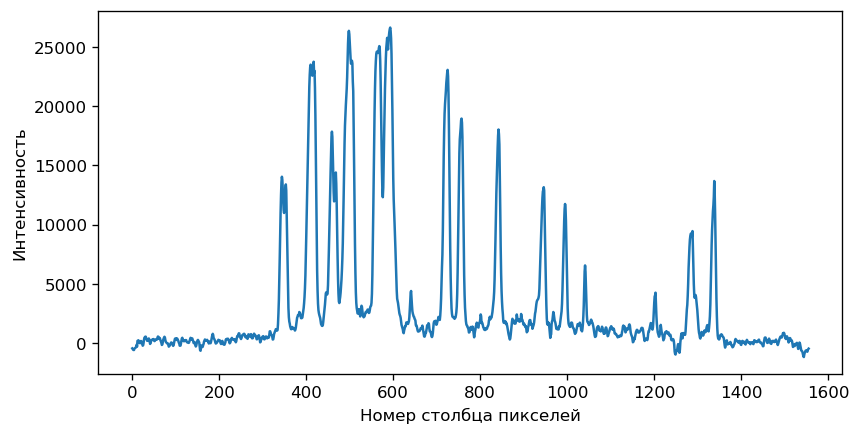

In [51]:
spectrum_final_lamp2 = spectra_background(lamp_2,5,41)
# plt.axhline(spectrum_final_lamp2.mean())

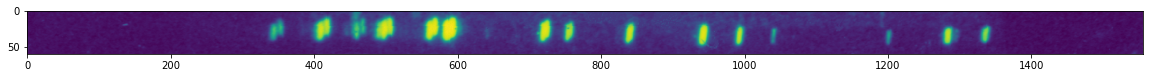

In [67]:
plt.figure(figsize=(20,10))
plt.imshow(lamp_2)

# WAVELENGTH

### $D = \frac{\lambda_n-\lambda_0}{N_n - N_0}$

D - средняя дисперсия, λn и λo – длины волн последней и первой линий в ангстремах, а  Nn и No –соответствующие номера

In [16]:
lambd_0 = 6217.28
lambd_n = 6929.47

In [17]:
def standart_deviation(list_value):
    mean = np.mean(list_value)
    summ = []
    for i in list_value:
        summ.append((i-mean)**2)
    std = np.sqrt(np.sum(summ)/len(list_value))
    return std

def x_axis_to_wavelenght(lamp_1,lamp_2):
    
    lamp_1_std = standart_deviation(lamp_1)*0.5
    
    index_l_1 = []
    
    for i in range(1,len(lamp_1)-1):
        if lamp_1[i] > lamp_1_std and lamp_1[i] > lamp_1[i+1] and lamp_1[i] > lamp_1[i-1]:
            index_l_1.append(i)
     
    dalta_ind_l1 = []
    for i in range(1,len(index_l_1)):
        dalta_ind_l1.append(index_l_1[i]-index_l_1[i-1])
    delta_std_l1 = standart_deviation(dalta_ind_l1)
    
    index_l1 = []
    counter_l1 = 0 
    for i in range(0,len(index_l_1)):
            
            if counter_l1 == 0:
                index_l1.append(index_l_1[i])
                countr_l1 =+ 1
           
            else:
                d = index_l_1[i] - index_l_1[i-1]
                countr_l1 =+ 1
                if d < delta_std_l1:
                    index_l1.append(index_l_1[i])  
    
    
    index_l1_1 = index_l1[0]
    index_l1_2 = index_l1[-1]
    
    lamp_2_std = standart_deviation(lamp_2)
    
    index_l_2 = []
    for i in range(1,len(lamp_2)-1):
        if lamp_2[i] > lamp_2_std and lamp_2[i] > lamp_2[i+1] and lamp_2[i] > lamp_2[i-1]:
            index_l_2.append(i)
            
        
    dalta_ind_l2 = []
    for i in range(1,len(index_l_2)):
        dalta_ind_l2.append(index_l_2[i]-index_l_2[i-1])
    delta_std_l2 = standart_deviation(dalta_ind_l2)
    
    index_l2 = []
    counter_l2 = 0 
    for i in range(0,len(index_l_2)):
            
            if counter_l2 == 0:
                index_l2.append(index_l_2[i])
                countr_l2 =+ 1
           
            else:
                d = index_l_2[i] - index_l_2[i-1]
                countr_l2 =+ 1
                if d < delta_std_l2:
                    index_l2.append(index_l_2[i])          
            
            
    index_l2_1 = index_l2[0]
    index_l2_2 = index_l2[-2]
    
    index_1 = int(np.mean([index_l1_1,index_l2_1]))
    index_2 = int(np.mean([index_l1_2,index_l2_2]))
    

    #PLOT
    fig,(ax1,ax2) = plt.subplots(2,figsize=(8,4),dpi=120)
#     ax1.figure(figsize=(18,9))
    ax1.plot(lamp_1,label="Лампа 1")
    ax1.axhline(lamp_1_std,c="gray",lw=1)
    ax1.axvline(index_l1_1,c="r",lw=1)
    ax1.axvline(index_l1_2,c="r",lw=1)
    # ax1.scatter(index_l1_1, lamp_1[index_l1_1],c="r",s=83)
    # ax1.scatter(index_l1_2, lamp_1[index_l1_2],c="r",s=83)
    ax1.scatter(index_l1, lamp_1[index_l1],c="g")
#     ax1.set_title("Lamp 1")
    ax1.legend(loc=2)
    ax1.set_xlabel("Номер столбца пикселей")
    ax1.set_ylabel("Интенсивность")
    
    ax2.plot(lamp_2,label="Лампа 2")
    ax2.axhline(lamp_2_std,c="gray",lw=1)
    ax2.axvline(index_l2_1,c="r",lw=1)
    ax2.axvline(index_l2_2,c="r",lw=1)    
    # ax2.scatter(index_l2_1, lamp_2[index_l2_1],c="r",s=83)
    # ax2.scatter(index_l2_2, lamp_2[index_l2_2],c="r",s=83)    
    ax2.scatter(index_l2, lamp_2[index_l2],c="g")
#     ax2.set_title("Lamp 2")
    ax2.legend(loc=2)
    
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
    plt.savefig("wavelenght_lamp.jpg")
    
    return index_1,index_2, index_l1,index_l2

In [18]:
def pixel2wavelenght(spectra,lambd_0,lambd_n,N_0,N_n):
    
    """
    Function calculates mean dispersion of wavelenghts
    and convert numbers of columns to wavelenght using lamp spectra.
    
    spectra -- final spectra of object/lamp without background (1-d array)
    lambd_0 -- the wavelengths of the first line of lamp spectra in angstroms 
    lambd_n -- the wavelengths of the last line of lamp spectra in angstroms
    N_0 -- column number of the first line
    N_n -- column number of the last line
    """
    dispersion = (lambd_n - lambd_0)/(N_n - N_0)
    wavelenght = []
    
    for i in range(0,len(spectra)):
        delta = i - N_0
        wl = delta * dispersion #distance in angstrom between a column and first line column
        wavelenght.append(lambd_0+wl)
        
        #PLOT
    plt.figure(figsize=(18,9))
    plt.plot(wavelenght,spectra)
    
    return wavelenght,dispersion

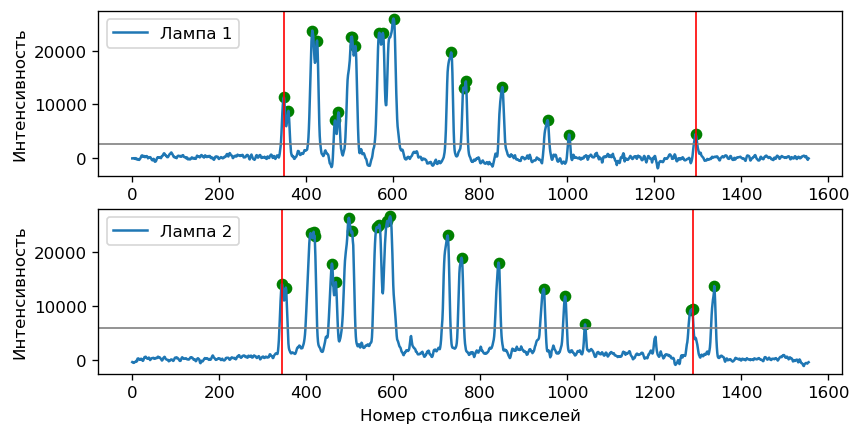

In [56]:
index_1,index_2,index_l1,index_l2 = x_axis_to_wavelenght(spectrum_final_lamp1,spectrum_final_lamp2)

In [ ]:
plt.figure

In [61]:
np.array(index_l1)

array([ 348,  359,  414,  425,  466,  474,  503,  505,  513,  568,  576,
        601,  733,  762,  767,  851,  955, 1004, 1295])

In [62]:
np.array(index_l2)

array([ 344,  353,  410,  417,  419,  459,  468,  498,  505,  563,  568,
        586,  593,  725,  757,  842,  946,  995, 1285, 1288, 1338])

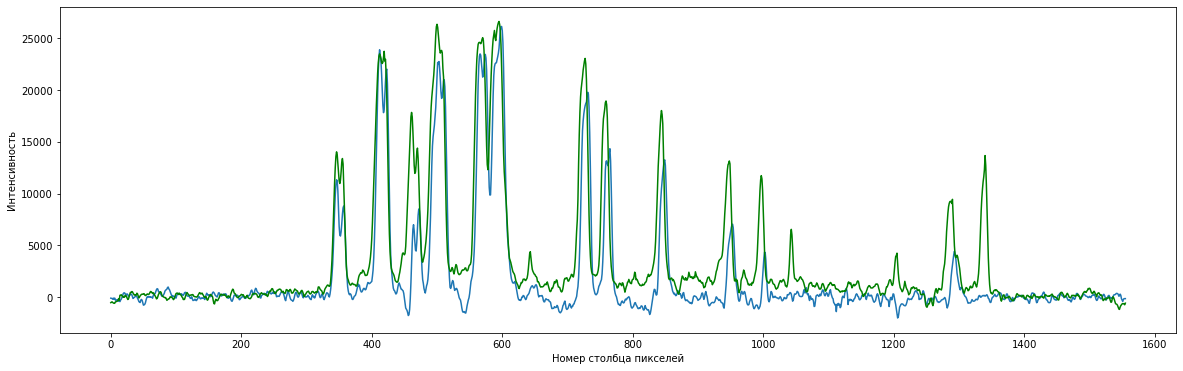

In [63]:
plt.figure(figsize=(20,6))
plt.plot(np.roll(spectrum_final_lamp1,-2),label="Лампа 1")
plt.plot(np.roll(spectrum_final_lamp2,2),c="g",label="Лампа 2")
plt.xlabel("Номер столбца пикселей")
plt.ylabel("Интенсивность")
plt.savefig("roll_lamps.jpg")

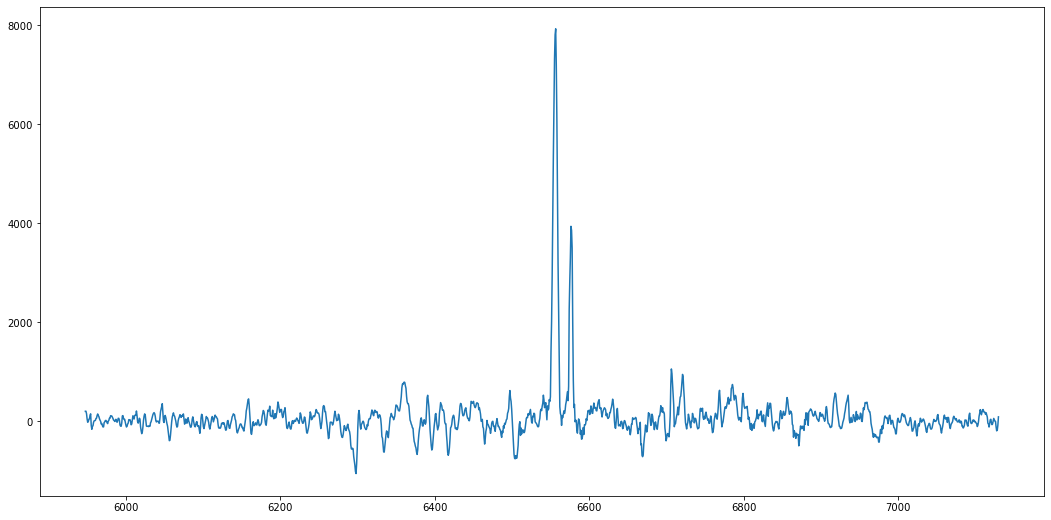

In [68]:
wavelenght,dispersion = pixel2wavelenght(spectrum_final,lambd_0,lambd_n,355,index_2)

In [69]:
dispersion

0.7608867521367527

In [19]:
def aprx(x,y,order):

    # monotone = False
        
    z = np.polyfit( x,y,order)
    p = np.poly1d(z)
    xp = np.linspace(x[0], x[-1], 1000)
    # print(xp)
    pxp = p(xp)

    for i in range(1,len(pxp)):
        max_pxp = y[:-1].max()
        if pxp[i]<=pxp[i-1]:
            pxp[i]=pxp[i-1]+1
            if pxp[i]>=max_pxp:
                min_pxp = pxp[i-100]
                delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                index = i-10
                break


    for j in range(index+1,len(pxp)):
        pxp[j]=pxp[j-1]+delta_pxp
               
    fig, ax1 = plt.subplots(figsize=(6,4),dpi=120)
    ax1 = plt.scatter(x,y, color="blue",s=50) 
    ax1 = plt.plot(xp, p(xp), color="orange",lw=2,label=f"Полином ({order})")   
    plt.legend()
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd_polinomial.jpg")
    
    return xp,p

In [20]:
def func(index_1,index_2,x1,x2,x3,x4,x5,lambd_1,lambd_2,lambd_3,lambd_4,lambd_5,wavelenght):
    
    delta_lambd_1 = wavelenght[x1] - lambd_1 
    delta_lambd_2 = wavelenght[x2] - lambd_2 
    delta_lambd_3 = wavelenght[x3] - lambd_3 
    delta_lambd_4 = wavelenght[x4] - lambd_4 
    delta_lambd_5 = wavelenght[x5] - lambd_5 
    
    print(wavelenght[x2])
    
    corr = np.array([0,delta_lambd_1,delta_lambd_2,delta_lambd_3,delta_lambd_4,delta_lambd_5,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    
    plt.figure(figsize=(6,4), dpi=120)
    plt.scatter([index_1,x1,x2,x3,x4,x5,index_2],corr,s=50)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd.jpg")
    xpp, polinomial = aprx([index_1,x1,x2,x3,x4,x5,index_2],corr,3)
    
    columns = np.arange(0,len(wavelenght))
    
    correction_whole = np.array(polinomial(columns))
    
    wavelenght_corrected = wavelenght + correction_whole
    
    return wavelenght_corrected,polinomial

6401.414594017094


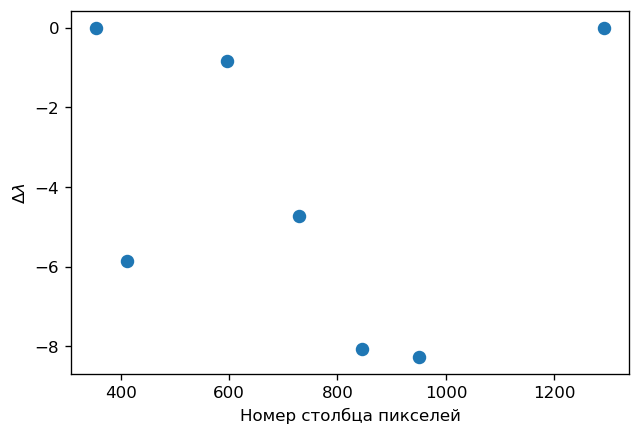

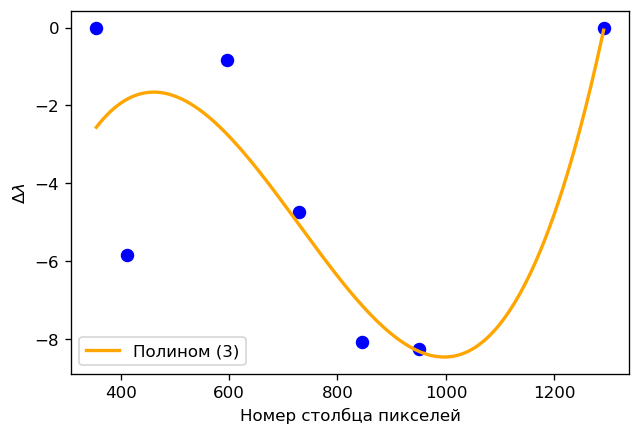

In [71]:
x1 = int(np.mean([414,410])) 
x2 = int(np.mean([601,593]))
x3 = int(np.mean([733,725]))
x4 = int(np.mean([851,842]))
x5 = int(np.mean([955,946]))
x6 = int(np.mean([1295,1288]))



lambd_1 = 6266.5
lambd_2 = 6402.25
lambd_3 = 6506.59
lambd_4 = 6598.95
lambd_5 = 6678.28
lambd_6 = 6929.47


wv,pp = func(355,index_2,x1,x2,x3,x4,x5,lambd_1,lambd_2,lambd_3,lambd_4,lambd_5,wavelenght)

In [61]:
pp(index_1)

-0.7394369200229605

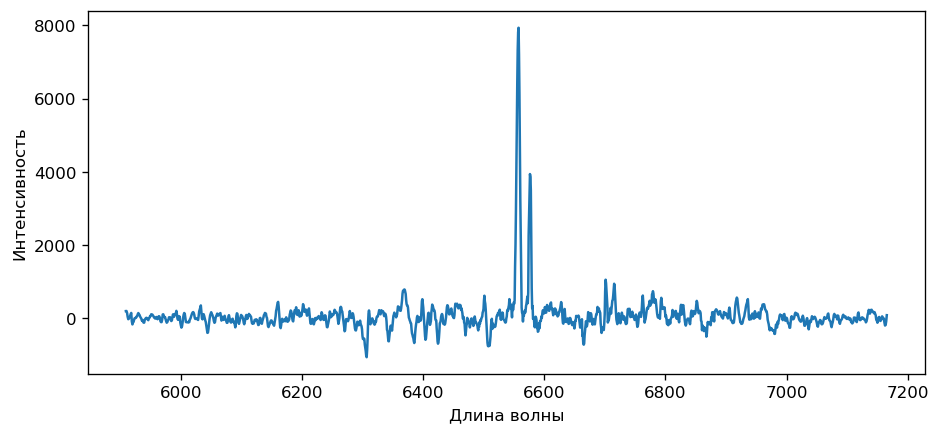

In [62]:
plt.figure(figsize=(9,4),dpi=120)
plt.plot(wv,spectrum_final)
plt.xlabel("Длина волны")
plt.ylabel("Интенсивность")
plt.savefig("final_spectra.jpg")

In [63]:
np.argmax(spectrum_final)

801

In [64]:
wv[801] - 6562

-4.29308138212491

In [73]:

lamp_Halfa = io.imread(f'lamp_Halfa.png')
lamp_Halfa = color.rgb2gray(lamp_Halfa)

<ipython-input-73-bae71eca2769>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  lamp_Halfa = color.rgb2gray(lamp_Halfa)


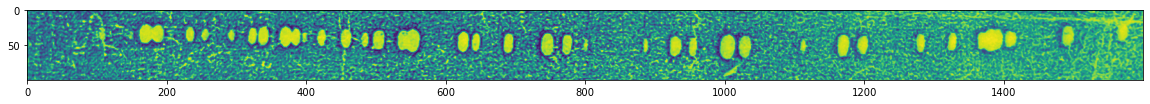

In [122]:
plt.figure(figsize = (20,16))
plt.imshow(lamp_Halfa[0:100])

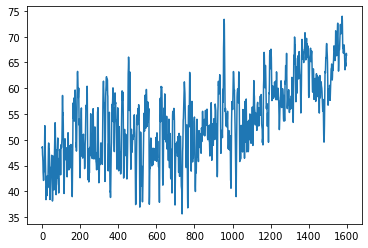

In [123]:
lam_a_1 = lamp_Halfa[0:100]
l_a_1 = lam_a_1.sum(axis = 0)
plt.plot(l_a_1)


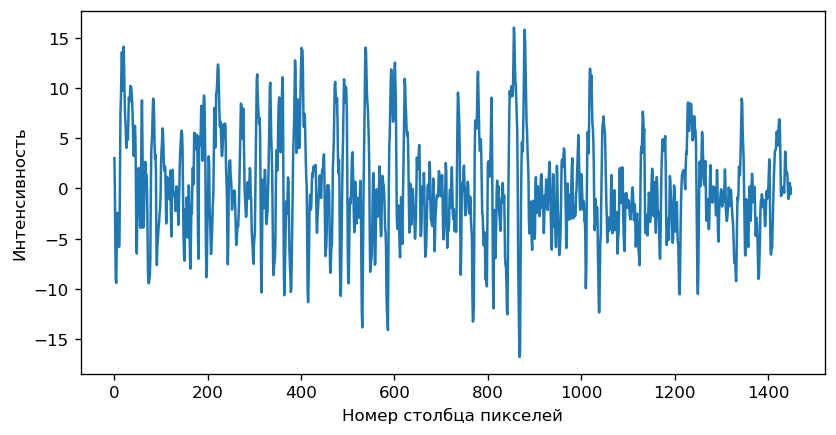

In [124]:
ss = spectra_background(lam_a_1[:,150:],18,70)

In [99]:
from scipy.signal import lfilter

In [125]:
n = 15  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b,a,ss)

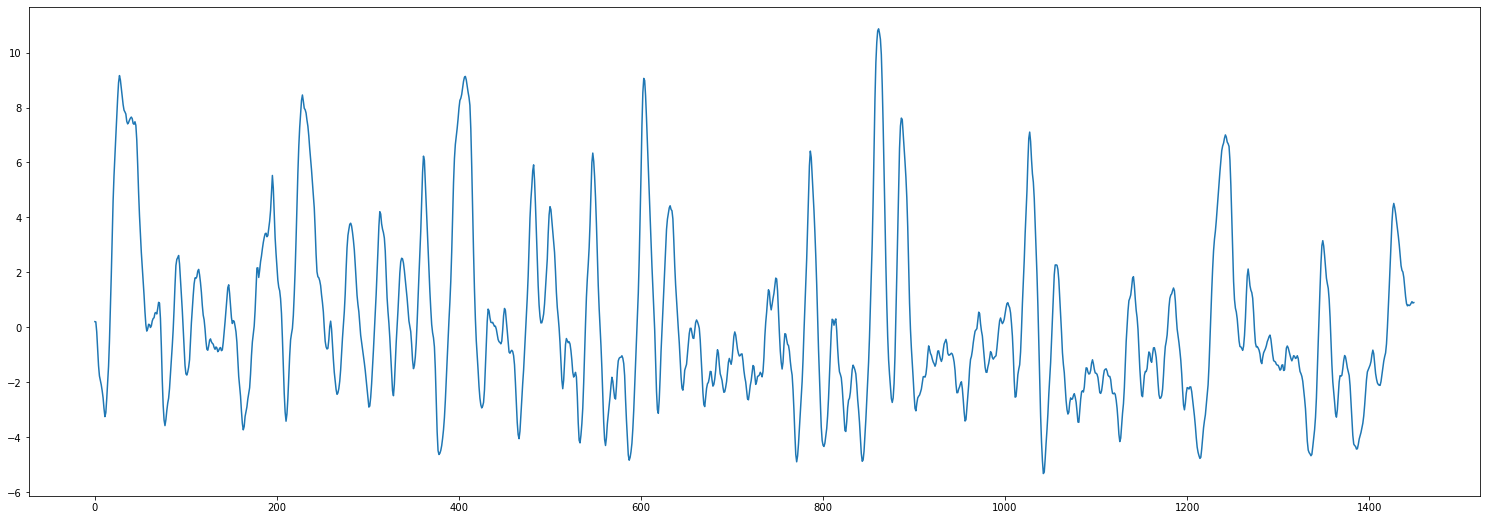

In [134]:
plt.figure(figsize=(26,9))
plt.plot(yy)

# plt.plot(spectrum_final_lamp2/2144.33,c="g")

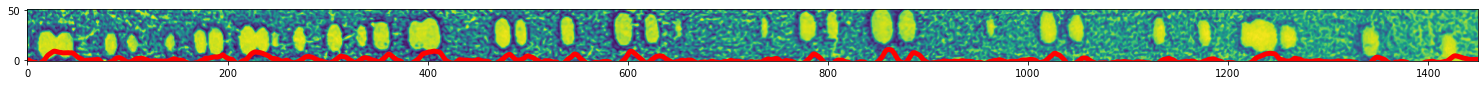

In [136]:
plt.figure(figsize=(26,9))
plt.plot(yy,c="r",lw=5)

plt.imshow(lamp_Halfa[18:70,150:])
plt.gca().invert_yaxis()

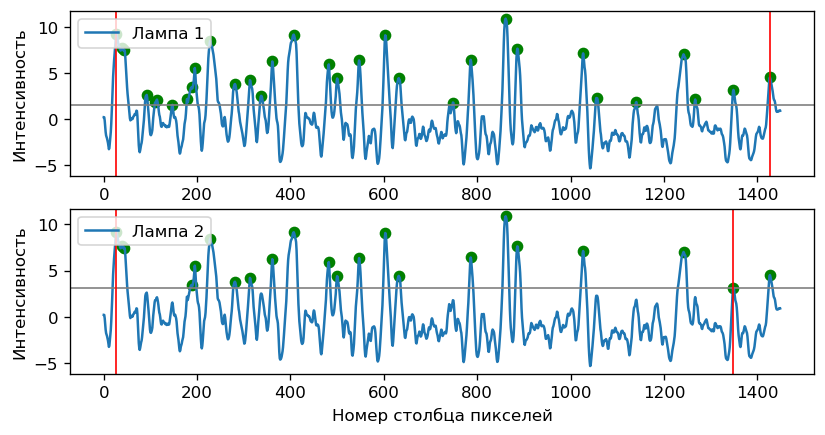

In [162]:
index_11,index_22,index_,index__ = x_axis_to_wavelenght(yy,yy)

In [164]:
len(index__)

22

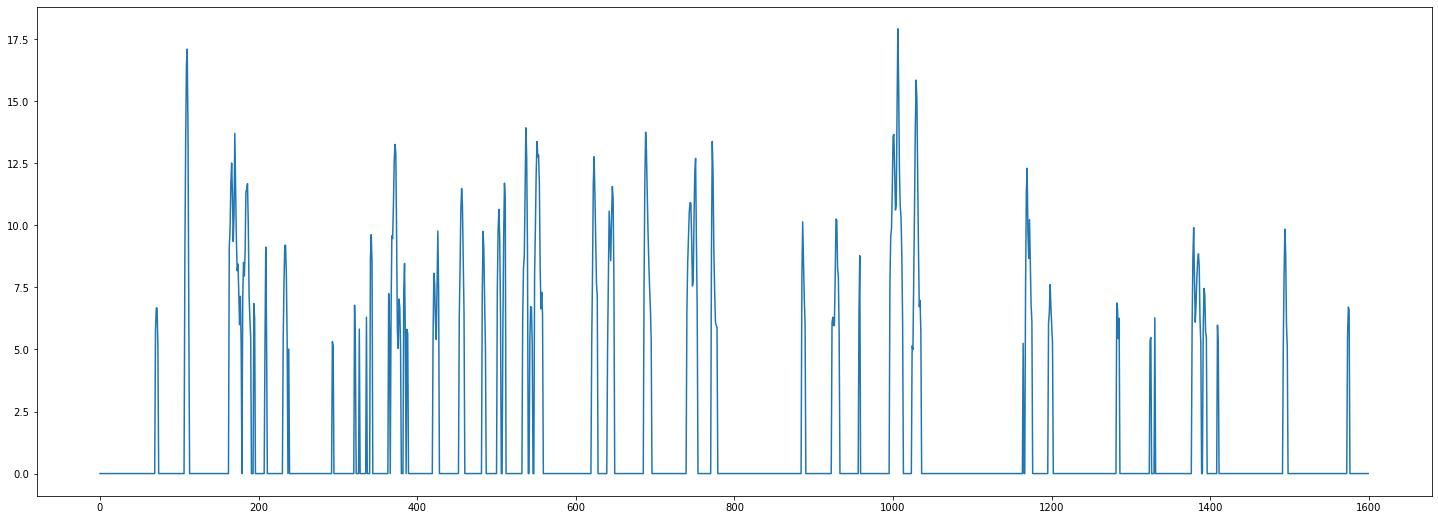

In [84]:

plt.figure(figsize=(25,9))
plt.plot(ss)

# NGC4151 scan 3200dpi 

In [23]:
data_call5s = fits2png("NGC4151_HB/Calibrovka_16-6_5s_3200dpi.fit.fits")
data_call10s = fits2png("NGC4151_HB/Calibrovka_16-6_10s_3200dpi.fit.fits")
data_call20s = fits2png("NGC4151_HB/Calibrovka_16-6_20s_3600dpi.fit.fits")
data_call30s = fits2png("NGC4151_HB/Calibrovka_16-6_30s_3200dpi.fit.fits")
data_call40s = fits2png("NGC4151_HB/Calibrovka_16-6_40s_3200dpi.fit.fits")
data_call2m5s = fits2png("NGC4151_HB/Calibrovka_16-6_2.5s_3200dpi.fit.fits")

In [22]:
data_call5s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits")
data_call10s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_10s_3200dpi.fit.fits")
data_call20s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_20s_3600dpi.fit.fits")
data_call30s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_30s_3200dpi.fit.fits")
data_call40s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_40s_3200dpi.fit.fits")
data_call2m5s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_2.5s_3200dpi.fit.fits")

FileNotFoundError: [Errno 2] No such file or directory: '/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits'

In [24]:
o_call5s = np.array(data_call5s)#*255/65536 #make an array from list
o_call10s = np.array(data_call10s)#*255/65536 #make an array from list
o_call20s = np.array(data_call20s)#*255/65536 #make an array from list
o_call30s = np.array(data_call30s)#*255/65536 #make an array from list
o_call40s = np.array(data_call40s)#*255/65536 #make an array from list
o_call2m5s = np.array(data_call2m5s)#*255/65536 #make an array from list

In [25]:
def peaks(mean,order):
    """
    function for searching peaks in array 
    """
    peak_indexes = signal.argrelextrema(mean, np.greater, order=order)[0] #индексы пиков 
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in peak_indexes:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа
    return peak_indexes,peak_mean

In [26]:
def peaks_our(mean):    
    
    for ind,p in enumerate(mean): 
        
        if p < mean[ind+1]:
            continue
        
        else:
            first_peak_ind = ind
            break

    random_peak_ind=[first_peak_ind]
    
    for ind in range(first_peak_ind+1,len(mean)-1):
        
        if mean[ind] > mean[ind-1] and mean[ind] > mean[ind+1]:
            random_peak_ind.append(ind)
            
    bad_peaks = []
    good_peaks = []
    min_dist = 29
    counter = 0
    
    for ind in range(0,len(random_peak_ind)-1):
        delta = random_peak_ind[ind+1] - random_peak_ind[ind]
        
        if delta < min_dist:
            bad_peaks.append(random_peak_ind[ind])
            bad_peaks.append(random_peak_ind[ind+1])
        
        else:
            
            if len(bad_peaks)==0:
                good_peaks.append(random_peak_ind[ind])
            
            else:
                bad_peaks = np.array(np.unique(bad_peaks))
                mean_index = int(bad_peaks.mean())
                good_peaks.append(mean_index)
                bad_peaks = []

    good_peaks.append(random_peak_ind[-1])
    
    if len(good_peaks) > 9:
        
        if mean[[good_peaks[-1]]] < mean[[good_peaks[-2]]]:
            good_peaks = good_peaks[:-1] 
            
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in good_peaks:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа        

    return good_peaks, peak_mean                    

In [27]:
def centroid(vertexes):
    x_list = [vertex[0] for vertex in vertexes]
    y_list = [vertex[1] for vertex in vertexes]
    lenth = len(vertexes)
    x = sum(x_list) / lenth
    y = sum(y_list) / lenth
    return(x, y)


In [28]:
def subimage_preob(name_file,data, x1,y1,x2,y2,x3,y3,x4,y4): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
#     path = os.getcwd()#для просмотра корневой дирректории
    lina_color = io.imread(f'{name_file}')
    lina_gray = color.rgb2gray(lina_color)
    tan = (y2-y1)/(x2-x1)
    radian = math.atan2((y1-y2),(x1-x2))
    theta = radian*180/np.pi
    print(theta)
    if theta > 90:
        theta = -180 + theta
    elif theta < -90:
        theta = 180 + theta
    else:
        theta = theta
    print(theta)
    for i in range(0,len(data)):
        for j in range(0,len(data[i])):
            lina_gray[i][j] = data[i][j]
    polygon_data = ((x1,y1), (x2, y2), (x3, y3), (x4, y4)) 
    center = centroid(polygon_data) #обращается к фукции centroid
    width = np.sqrt((x2-x1)**2+(y2-y1)**2)
    height = np.sqrt((x4-x1)**2+(y4-y1)**2)
    if center[0]<1 and center[1]<1 and width<1: #проверка на случай если мы работаем в относительных координатах и их пересчёт к абсолютным
        center_x = int(center[0]*lina_gray.shape[1])
        center_y = int(center[1]*lina_gray.shape[0])
        width = int(width * lina_gray.shape[1])
        height = int(height * lina_gray.shape[0])
        center = (center_x,center_y)
        
    shape = ( data.shape[1], data.shape[0] ) # cv2.warpAffine expects shape in (length, height)
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    lina_rotated = cv2.warpAffine(src=lina_gray, M=matrix, dsize=shape ) #сохранение повернутого изображения из матрицы

    x = int( center[0] - width/2  ) #поиск координаты x слева
    y = int( center[1] - height/2 ) # поиск координаты у снизу

    lina_croped = lina_rotated[ y:int(y+height), x:int(x+width) ] #обрезка изображения по координатам
    
    #preob
    array_log10 = np.log10(65536/lina_croped)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)
    mean = array_log10.mean(axis=0) #среднее значение по столбцам
    
    
    plt.imshow(lina_croped) #path -- путь к корневой дирректории
    plt.gca().invert_yaxis()
    #возвращает обрезанное изображение
    return lina_croped,mean

-167.7820594965254
12.217940503474608


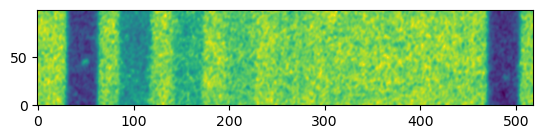

In [29]:
shape1 = o_call5s.shape[1]
shape0 = o_call5s.shape[0]

x1= int((0.367) * shape1)
y1= int((1-0.58) * shape0)
x2= int((0.604) * shape1)
y2= int((1-0.503) * shape0)
x3= int((0.584) * shape1)
y3= int((1-0.44) * shape0)
x4= int((0.346) * shape1)
y4= int((1-0.517) * shape0)

#image_5s,mean_5s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_5s,mean_5s= subimage_preob('NGC4151_HB/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call5s')

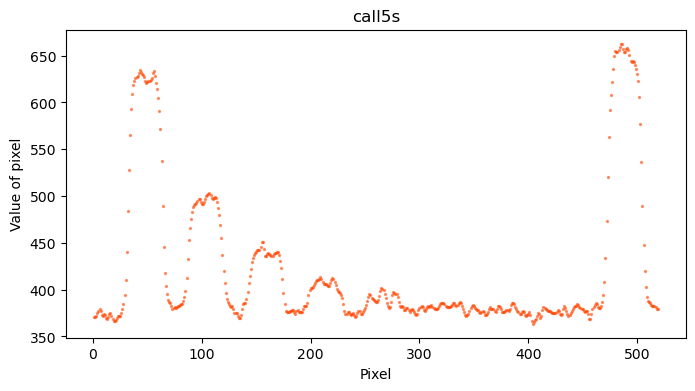

In [30]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_5s) + 1)
ax.scatter(x,mean_5s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call5s')
# plt.xlim(50,100)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/3081093465.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_1, mean_5s[[peak_indexes_1]], color = 'y', s = 10, marker = 'D', label = 'maxima')


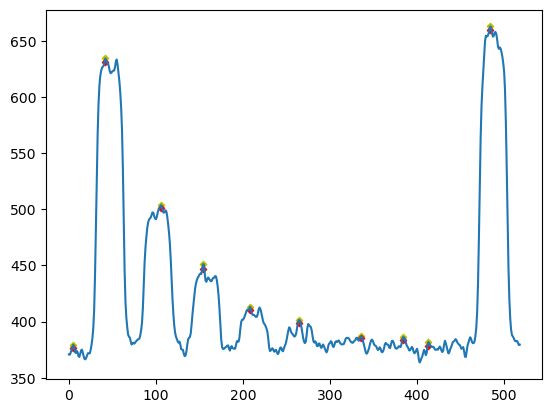

In [31]:
peak_indexes_1,peak_mean_1 = peaks(mean_5s,order=18) #func_peaks

x1 = np.arange(0,len(mean_5s))
plt.plot(x1,mean_5s)
plt.scatter(peak_indexes_1, mean_5s[[peak_indexes_1]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_1, peak_mean_1, color = 'r', s = 10, marker = 'D', label = 'maxima')

-167.93433814938788
12.065661850612116


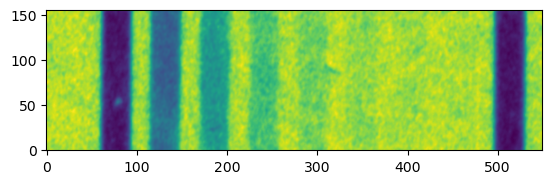

In [32]:
shape1 = o_call10s.shape[1]
shape0 = o_call10s.shape[0]

x1= int((0.302) * shape1)
y1= int((1-0.57) * shape0)
x2= int((0.553) * shape1)
y2= int((1-0.489) * shape0)
x3= int((0.521) * shape1)
y3= int((1-0.389) * shape0)
x4= int((0.27) * shape1)
y4= int((1-0.471) * shape0)
# ________________________________________________________________
# sudo mount.nfs -o "vers=3" 10.0.1.11:/volume1/Astroplates ~/Astro

image_10s,mean_10s= subimage_preob('NGC4151_HB/Calibrovka_16-6_10s_3200dpi.fit.fits.jpg',o_call10s,x1,y1,x2,y2,x3,y3,x4,y4)
#image_10s,mean_10s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_10s_3200dpi.fit.fits.jpg',o_call10s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call10s')

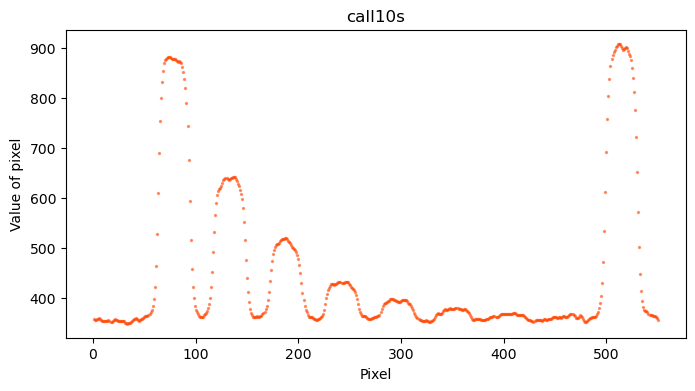

In [33]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_10s)+1)
ax.scatter(x,mean_10s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call10s')
# plt.xlim(50,100)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/3239369052.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_2, mean_10s[[peak_indexes_2]], color = 'y', s = 10, marker = 'D', label = 'maxima')


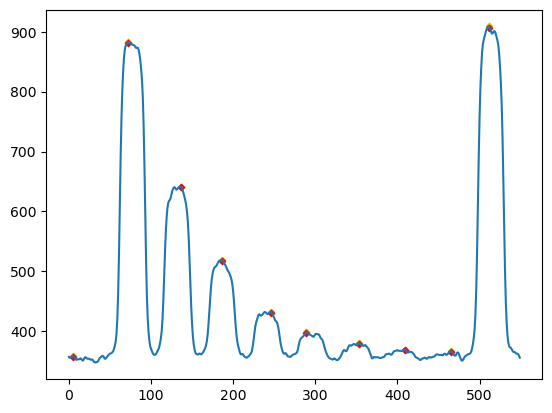

In [34]:
peak_indexes_2,peak_mean_2 = peaks(mean_10s,order=14) #func_peaks

x2 = np.arange(0,len(mean_10s))
plt.plot(x2,mean_10s)
plt.scatter(peak_indexes_2, mean_10s[[peak_indexes_2]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_2, peak_mean_2, color = 'r', s = 10, marker = 'D', label = 'maxima')

-168.47341212181183
11.526587878188167


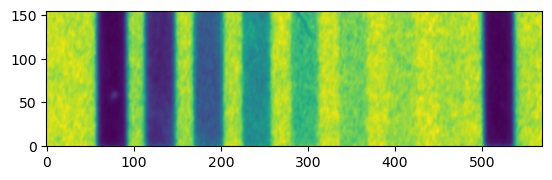

In [35]:
shape1 = o_call20s.shape[1]
shape0 = o_call20s.shape[0]


x1= int((0.416) * shape1)
y1= int((1-0.576) * shape0)
x2= int((0.677) * shape1)
y2= int((1-0.496) * shape0)
x3= int((0.654) * shape1)
y3= int((1-0.42) * shape0)
x4= int((0.393) * shape1)
y4= int((1-0.471) * shape0)


image_20s,mean_20s= subimage_preob('NGC4151_HB/Calibrovka_16-6_20s_3600dpi.fit.fits.jpg',o_call20s,x1,y1,x2,y2,x3,y3,x4,y4)
#image_20s,mean_20s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_20s_3600dpi.fit.fits.jpg',o_call20s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call20s')

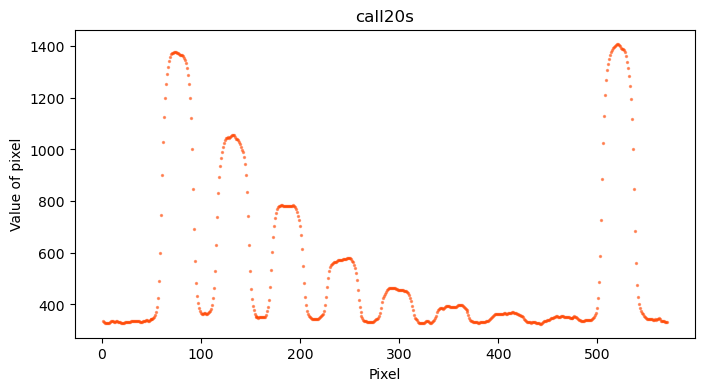

In [36]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_20s) + 1)
ax.scatter(x,mean_20s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call20s')
# plt.xlim(50,100)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/1469463489.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_3, mean_20s[[peak_indexes_3]], color = 'y', s = 10, marker = 'D', label = 'maxima')


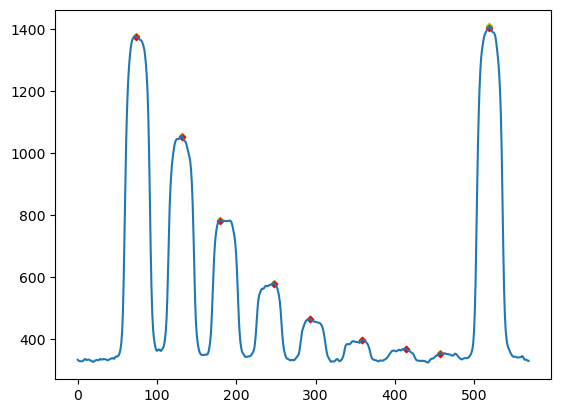

In [37]:
peak_indexes_3,peak_mean_3 = peaks(mean_20s,order=20) #func_peaks

x3 = np.arange(0,len(mean_20s))
plt.plot(x3,mean_20s)
plt.scatter(peak_indexes_3, mean_20s[[peak_indexes_3]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_3, peak_mean_3, color = 'r', s = 10, marker = 'D', label = 'maxima')

169.74124827552353
-10.258751724476468


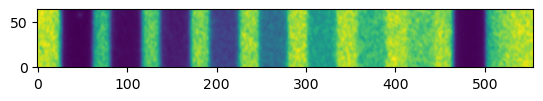

In [38]:
shape1 = o_call30s.shape[1]
shape0 = o_call30s.shape[0]


x1= int((0.37) * shape1)
y1= int((1-0.454) * shape0)
x2= int((0.625) * shape1)
y2= int((1-0.524) * shape0)
x3= int((0.636) * shape1)
y3= int((1-0.482) * shape0)
x4= int((0.382) * shape1)
y4= int((1-0.412) * shape0)


image_30s,mean_30s= subimage_preob('NGC4151_HB/Calibrovka_16-6_30s_3200dpi.fit.fits.jpg',o_call30s,x1,y1,x2,y2,x3,y3,x4,y4)
#image_30s,mean_30s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_30s_3200dpi.fit.fits.jpg',o_call30s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call30s')

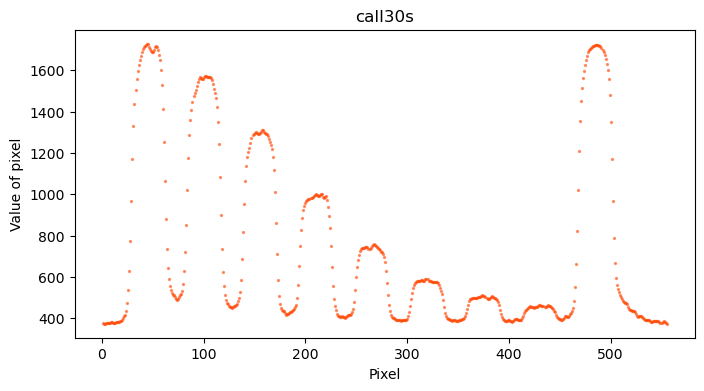

In [39]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_30s) + 1)
ax.scatter(x,mean_30s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call30s')
# plt.xlim(50,100)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/2416507277.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_4, mean_30s[[peak_indexes_4]], color = 'y', s = 10, marker = 'D', label = 'maxima')


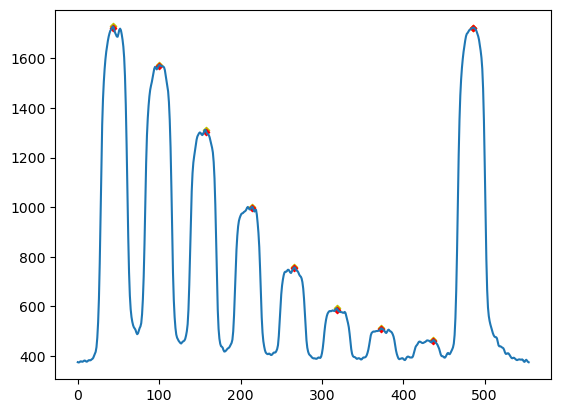

In [40]:
peak_indexes_4,peak_mean_4 = peaks(mean_30s,order=15) #func_peaks

x4 = np.arange(0,len(mean_30s))
plt.plot(x4,mean_30s)
plt.scatter(peak_indexes_4, mean_30s[[peak_indexes_4]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_4, peak_mean_4, color = 'r', s = 10, marker = 'D', label = 'maxima')

168.5934474160276
-11.406552583972399


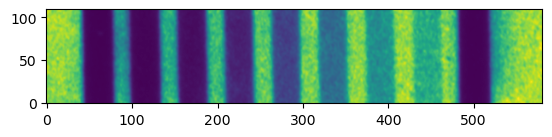

In [41]:
shape1 = o_call40s.shape[1]
shape0 = o_call40s.shape[0]


x1= int((0.369) * shape1)
y1= int((1-0.471) * shape0)
x2= int((0.635) * shape1)
y2= int((1-0.552) * shape0)
x3= int((0.656) * shape1)
y3= int((1-0.482) * shape0)
x4= int((0.39) * shape1)
y4= int((1-0.4) * shape0)


image_40s,mean_40s= subimage_preob('NGC4151_HB/Calibrovka_16-6_40s_3200dpi.fit.fits.jpg',o_call40s,x1,y1,x2,y2,x3,y3,x4,y4)
#image_40s,mean_40s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_40s_3200dpi.fit.fits.jpg',o_call40s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call40s')

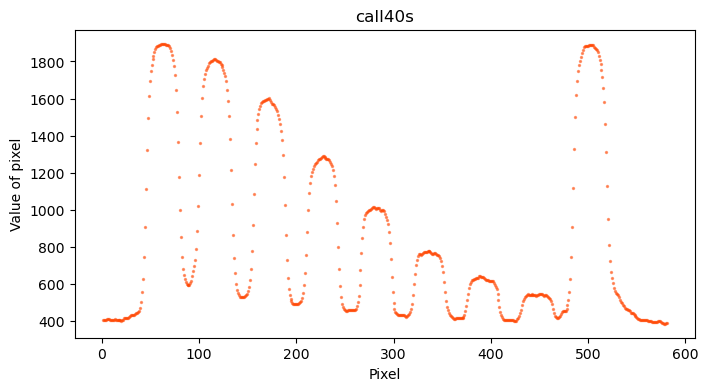

In [42]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_40s) + 1)
ax.scatter(x,mean_40s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call40s')
# plt.xlim(50,100)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/3800969139.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_5, mean_40s[[peak_indexes_5]], color = 'y', s = 10, marker = 'D', label = 'maxima')


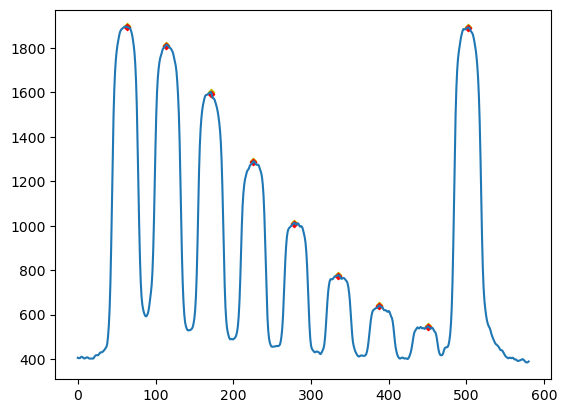

In [43]:
peak_indexes_5,peak_mean_5 = peaks(mean_40s,order=18) #func_peaks

x5 = np.arange(0,len(mean_40s))
plt.plot(x5,mean_40s)
plt.scatter(peak_indexes_5, mean_40s[[peak_indexes_5]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_5, peak_mean_5, color = 'r', s = 10, marker = 'D', label = 'maxima')

169.74124827552353
-10.258751724476468


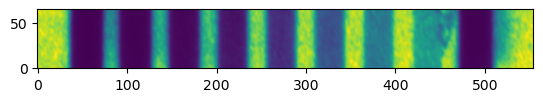

In [44]:
shape1 = o_call2m5s.shape[1]
shape0 = o_call2m5s.shape[0]


x1= int((0.375) * shape1)
y1= int((1-0.449) * shape0)
x2= int((0.63) * shape1)
y2= int((1-0.519) * shape0)
x3= int((0.641) * shape1)
y3= int((1-0.476) * shape0)
x4= int((0.387) * shape1)
y4= int((1-0.406) * shape0)


image_2m5s,mean_2m5s= subimage_preob('NGC4151_HB/Calibrovka_16-6_2.5s_3200dpi.fit.fits.jpg',o_call2m5s,x1,y1,x2,y2,x3,y3,x4,y4)
#image_2m5s,mean_2m5s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_2.5s_3200dpi.fit.fits.jpg',o_call2m5s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call2m5s')

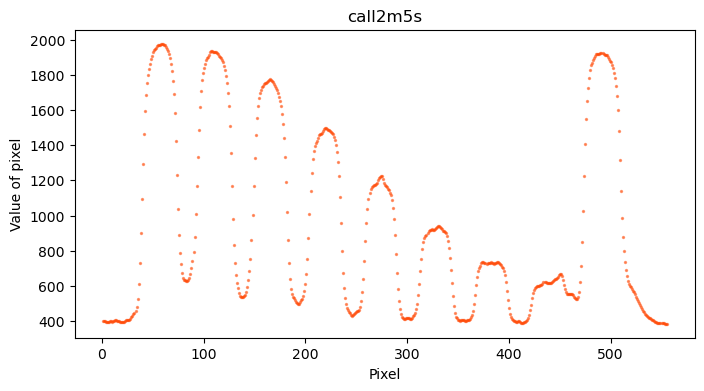

In [45]:
fig = plt.figure(figsize=(8,4),dpi = 100)#(figsize=(14,7),dpi = 200)
ax = fig.add_subplot(111)
# mean_call1 = preob(revers1)
x = np.arange(1, len(mean_2m5s) + 1)
ax.scatter(x,mean_2m5s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call2m5s')
# plt.xlim(50,100)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_71783/3040245210.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_6, mean_2m5s[[peak_indexes_6]], color = 'y', s = 10, marker = 'D', label = 'maxima')


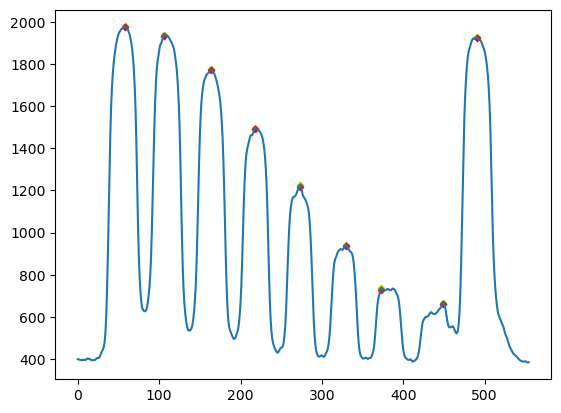

In [46]:
peak_indexes_6,peak_mean_6 = peaks(mean_2m5s,order=19) #func_peaks

x6 = np.arange(0,len(mean_2m5s))
plt.plot(x6,mean_2m5s)
plt.scatter(peak_indexes_6, mean_2m5s[[peak_indexes_6]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_6, peak_mean_6, color = 'r', s = 10, marker = 'D', label = 'maxima')

In [47]:
#Data for step attenuators in stellar magnitudes (L.N. gave) 
mag_before_1972 = [0,0.61,1.1,1.47,1.84,2.25,2.66,3.04,0]
mag_after_1972 = [0,0.5,0.97,1.44,1.93,2.43,2.69,3.04,0]
# ________________экспозиции из журнала(настоящие)_______________
# delta_m1 = 2.5*np.log(40/2.5)
# delta_m2 = 2.5*np.log(40/5)
# delta_m3 = 2.5*np.log(40/10)
# delta_m4 = 2.5*np.log(40/20)
# delta_m5 = 2.5*np.log(40/30)
# delta_m6 = 2.5*np.log(40/40)
#_________________подборка экспозиций,чтобы кривая легла нормально______
delta_m1 = 2.5*np.log(40/10)
delta_m2 = 2.5*np.log(40/15)
delta_m3 = 2.5*np.log(40/20)
delta_m4 = 2.5*np.log(40/27)
delta_m5 = 2.5*np.log(40/35)
delta_m6 = 2.5*np.log(40/40)

Text(0, 0.5, 'Почернение')

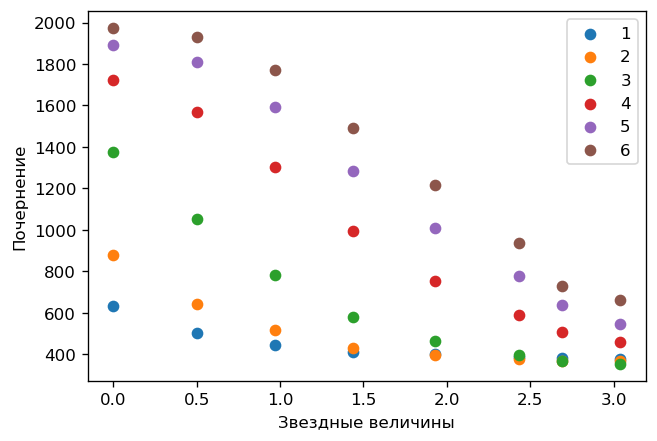

In [48]:
plt.figure(figsize=(6,4),dpi=120)

plt.scatter(mag_after_1972[:-1],peak_mean_1[1:-1], label=1)
plt.scatter(mag_after_1972[:-1],peak_mean_2[1:-1], label=2)
plt.scatter(mag_after_1972[:-1],peak_mean_3[:-1], label=3)
plt.scatter(mag_after_1972[:-1],peak_mean_4[:-1], label=4)
plt.scatter(mag_after_1972[:-1],peak_mean_5[:-1], label=5)
plt.scatter(mag_after_1972[:-1],peak_mean_6[:-1], label=6)

plt.legend()
plt.xlabel("Звездные величины")
plt.ylabel("Почернение")
# plt.savefig("peaks_curve_deviated.jpg")


Text(0, 0.5, 'Почернение')

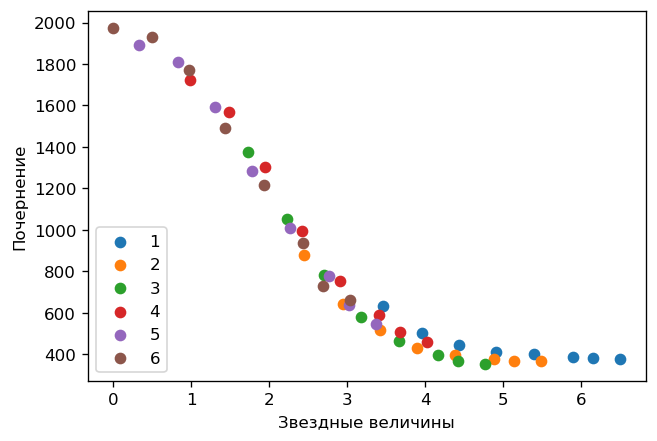

In [49]:
plt.figure(figsize=(6,4),dpi=120)

plt.scatter(mag_after_1972[:-1]+delta_m1,peak_mean_1[1:-1], label=1)
plt.scatter(mag_after_1972[:-1]+delta_m2,peak_mean_2[1:-1], label=2)
plt.scatter(mag_after_1972[:-1]+delta_m3,peak_mean_3[:-1], label=3)
plt.scatter(mag_after_1972[:-1]+delta_m4,peak_mean_4[:-1], label=4)
plt.scatter(mag_after_1972[:-1]+delta_m5,peak_mean_5[:-1], label=5)
plt.scatter(mag_after_1972[:-1]+delta_m6,peak_mean_6[:-1], label=6)
plt.legend(loc=3)
plt.xlabel("Звездные величины")
plt.ylabel("Почернение")
# plt.savefig("peaks_curve_alighned.jpg")

In [50]:
array = [peak_mean_1[1:-1],peak_mean_2[1:-1],peak_mean_3[:-1],peak_mean_4[:-1],peak_mean_5[:-1],peak_mean_6[:-1]]
y_array = np.concatenate(array)
x_array = np.concatenate([mag_after_1972[:-1]+delta_m1,mag_after_1972[:-1]+delta_m2,mag_after_1972[:-1]+delta_m3,mag_after_1972[:-1]+delta_m4,mag_after_1972[:-1]+delta_m5,mag_after_1972[:-1]+delta_m6])

In [51]:

#we calculate mean deveation by calculating delta between each neighboring element, sum it and the devide by number of elements 
c = []
for i in range(1,len(y_array)):
    c.append(abs(y_array[i] - y_array[i-1]))
mean_deviation = np.array(c).sum()/len(y_array)

#now we sort our data: if delta between neighboring elements larger than 2 mean deveation we will remove it
indexes = []
for i in range(1,len(y_array)):
    if abs(y_array[i]-y_array[i-1])>mean_deviation*2:
        indexes.append(i)

y_array = np.delete(y_array,indexes)
x_array = np.delete(x_array,indexes)
#Imax = 10000
xarray_flux = 10000/10**(x_array/2.5)

In [52]:
#now we shoudl sort our data to don't get convoluted curve

a = []
for i in range(0,len(xarray_flux)):
    a.append([xarray_flux[i],y_array[i]])

a.sort(key=lambda x:x[0])

xarray_flux = []
y_array = []

for i in range(0,len(a)):
    xarray_flux.append(a[i][0])
    y_array.append(a[i][1])
    
xarray_flux = np.array(xarray_flux)
y_array = np.array(y_array)       

del a

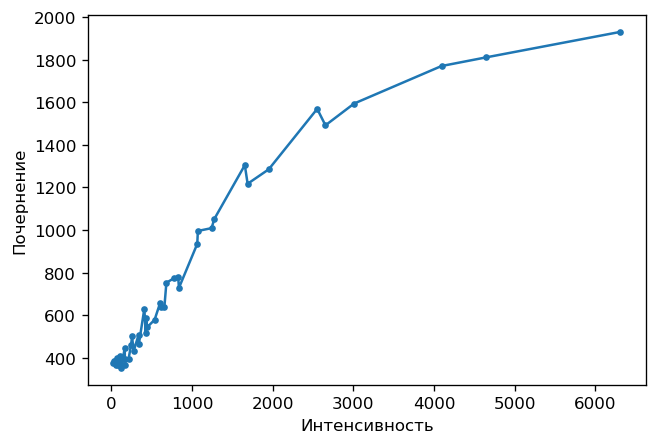

In [53]:
plt.figure(figsize=(6,4),dpi=120)
plt.plot(xarray_flux, y_array, markersize=3,marker='o' )
# plt.ylim(0,4000)
# plt.xlim(0,1000)
plt.xlabel("Интенсивность")
plt.ylabel("Почернение")
plt.savefig("characteristic_curve_first.jpg")

In [54]:
def aprx(x,y,order):

    monotone = False
    while monotone == False:
        
        z = np.polyfit( x,y,order)
        p = np.poly1d(z)
        xp = np.linspace(0, x[-1], 1000)
        # print(xp)
        pxp = p(xp)

        for i in range(1,len(pxp)):
            max_pxp = y[:-1].max()
            if pxp[i]<=pxp[i-1]:
                pxp[i]=pxp[i-1]+1
                if pxp[i]>=max_pxp:
                    min_pxp = pxp[i-100]
                    delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                    index = i-10
                    break


        for j in range(index+1,len(pxp)):
            pxp[j]=pxp[j-1]+delta_pxp

        z = np.polyfit( xp,pxp, 7)
        pp = np.poly1d(z)
        xpp = np.linspace(0, x[-1], 1000)

        pxpp = pp(xpp)
        
        check = []
        for k in range(0,len(pxpp)-1):      
            if pxpp[k]>pxpp[k+1]:
                check.append(k)
        
        if len(check) == 0:
                monotone = True
        else:
            order = order+1
            monotone = False
               
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=80)
    ax1 = plt.scatter(x[:-1],y[:-1], color="blue",s=5) 
    ax1 = plt.plot(xp, p(xp), color="orange")           

    fig, ax2 = plt.subplots(figsize=(6,4),dpi=120)
    ax2 = plt.plot( xpp, pp(xpp), lw=1, label = f"Апроксимация полиномом ({order},6)")#"Polynomial approximation")
    ax2 = plt.scatter(x[:-1],y[:-1], color="red",s=50,marker='.')#, label = "Attenuator magnitude")
    plt.legend()
    plt.xlabel("Интенсивность")
    plt.ylabel("Почернение")
#     plt.yticks([200, 300, 400, 500, 600, 700, 800, 900])
    plt.savefig("characteristic_curve.jpg")
    return xpp,pp

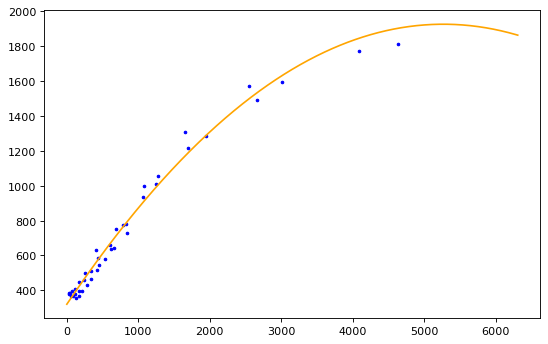

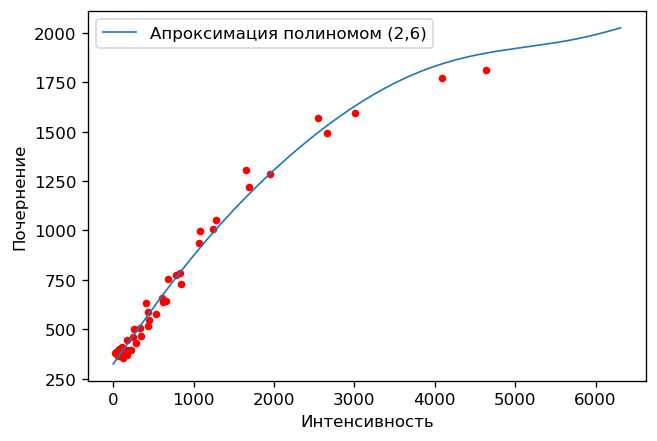

In [55]:
xpp,polinomial = aprx(xarray_flux,y_array,2)

In [56]:
print(polinomial)

            7             6             5             4             3
-5.262e-23 x + 1.176e-18 x - 1.007e-14 x + 4.213e-11 x - 9.027e-08 x
              2
 + 3.603e-05 x + 0.5695 x + 324.6


In [57]:
def polynomial_alighn(data,low_limit,up_limit,order):
    
    """
    function aligns the spectrum through finding min value in each column and approximate it with polynomial and mean for polinomial line
    
    data - whole image
    up_limit,low_limit - limits of spectra in rows number
    order - polinomial order to approximate spectra
    
    """
    
    data_part = data[low_limit:up_limit]
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
    ax1.imshow(data_part, cmap='gray')
#     plt.imsave('pic_lamp_20s.jpg', data_part)
    ax1.set_title("Initial part of spectra")
#     plt.savefig("initial_part.eps")
    
    #create massive of part of whole spectra with arrays of columns, not rows
    data_columns = []
    for i in range(0,len(data_part[0])):
        data_columns.append(list(data_part[:,i]))
    data_columns=list(data_columns)
    
    #create massive of whole spectra with arrays of columns, not rows
    data_collumns_entire_image = []
    for j in range(0,len(data[0])):
        data_collumns_entire_image.append(list(data[:,j]))
    data_collumns_entire_image=list(data_collumns_entire_image)

    #find min value in each column and then find indexes of the values - they will be Y-coordinate
    data_col_min = data_part.min(axis=0)
    index = []
    for i in range(0,len(data_col_min)):
            index.append(data_columns[i].index(data_col_min[i]))


    #find median value of neighboring indexes of min values in each column in some ranges to compairing in the next steps
    #we schould find mediam values for ranges not for whole image, because we have non-linear graph and it has curvature  
    median = []
    n = 0
    while n+100<len(index):
        k=n+100
        median.append([n,k,np.median(index[n:k])])
        n=k
    else:
        median.append([n,-1,np.median(index[n:])])

    #calculate mean delta between neighboring values
    delt=[]
    for i in range(1,len(index)):
        delt.append(abs(index[i]-index[i-1]))
    delt_mean = np.array(delt).sum()/len(delt)    

    #now we compair difference between median value indexes of minimum value in each column     
    for i in median:
        for j in range(i[0],i[1]):
            if abs(i[2]-index[j])>delt_mean:
                index[j] = i[2]

    fig, ax2 = plt.subplots(figsize=(8,5),dpi=100)
    ax2.plot(index)
    
    #plot polynomial
    xp = np.arange(0,len(index))
    z = np.polyfit(xp,index, order)
    polynomial = np.poly1d(z)
    y_polynomial = polynomial(xp)
    ax2.plot(index, color="steelblue", label="Srectra line") 
    ax2.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax2.set_title("Polinomial approximation of spectra")
    ax2.legend()
#     plt.savefig("polinomial_spectra.eps")
    
    xp_tg = np.arange(0,len(y_polynomial))
    z_tg = np.polyfit(xp_tg,y_polynomial, 1)
    polynomial_tg = np.poly1d(z_tg)
    y_polynomial_tg = polynomial_tg(xp_tg)
    tg = polynomial_tg[1]
    
    #now we will plot our curve on our frame
    mean_polynomial = y_polynomial.mean()
    fig, ax3 = plt.subplots(figsize=(8,5),dpi=100)
    ax3.imshow(data_part, cmap='gray')
    ax3.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax3.axhline(mean_polynomial, label="Polinomial mean")
#     ax3.legend(bbox_to_anchor=(1.01,0.5))
#     plt.savefig("polinomial_mean.eps")
    
    delta_y = []
    for i in range(0,len(index)):
        delta = mean_polynomial - polynomial(xp)[i]
        delta_y.append(int(delta))

    shape = np.array(data_collumns_entire_image).shape
    new_pic_col = np.zeros(shape)
    for i in range(0,len(data_collumns_entire_image)):
        for j in range(0,len(data_collumns_entire_image[i])):
            m  = j + delta_y[i]
            if m<len(data_collumns_entire_image[i]):
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
            else:
                m = m - len(data_collumns_entire_image[i])
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
    data_rows = []
    for i in range(0,len(new_pic_col[0])):
        data_rows.append(list(new_pic_col[:,i]))
            
    
    delta_x = np.arange(0,len(data_rows))*tg
    shape = np.array(data_rows).shape
    new_data_rows = np.zeros(shape)
    for i in range(0,len(data_rows)):
        for j in range(0,len(data_rows[i])):
            m  = int(j + 2*delta_x[i])
            if m<len(data_rows[i]):
                new_data_rows[i][m] = data_rows[i][j] 
            else:
                m = m - len(data_rows[i])
                new_data_rows[i][m] = data_rows[i][j] 
    
    aligned_image = new_data_rows
    
    fig, ax4 = plt.subplots(figsize=(8,5),dpi=100)
    ax4.imshow(aligned_image, cmap='gray')
    ax4.grid()
    ax4.set_title("Aligned spectra 1st")
    #_________________________________________________________________________
    
    plt.savefig("aligned_spectra.eps")
    plt.savefig("aligned_spectra.jpg")
    
    
    return aligned_image

In [58]:
#fits_1m = fits.open('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/NGC4151_16-6_1m_3200dpi.fit.fits')
fits_1m = fits.open('NGC4151_HB/NGC4151_16-6_1m_3200dpi.fit.fits')

data_NGC4151_1m  = fits_1m[0].data

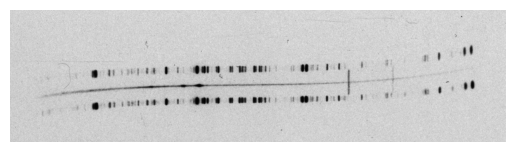

In [59]:
plt.imshow(data_NGC4151_1m, cmap='gray')
plt.axis("off")
plt.imsave("data_NGC4151_1m.jpg",data_NGC4151_1m)

175.2441591116645
-4.755840888335513


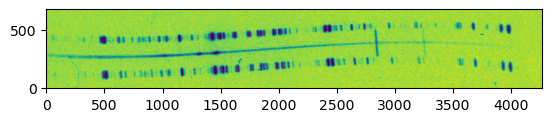

In [60]:
shape1 = data_NGC4151_1m.shape[1]
shape0 = data_NGC4151_1m.shape[0]

x1= int((0.008) * shape1)
y1= int((1-0.471) * shape0)
x2= int((0.936) * shape1)
y2= int((1-0.76) * shape0)
x3= int((1.048) * shape1)
y3= int((1-0.4) * shape0)
x4= int((0.121) * shape1)
y4= int((1-0.111) * shape0)

image_data_NGC4151_1m,mean_data_NGC4151_1m = subimage_preob('data_NGC4151_1m.jpg',data_NGC4151_1m,x1,y1,x2,y2,x3,y3,x4,y4)
del mean_data_NGC4151_1m

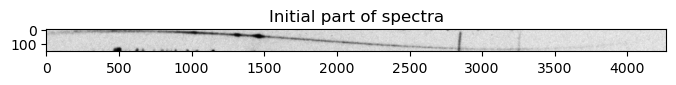

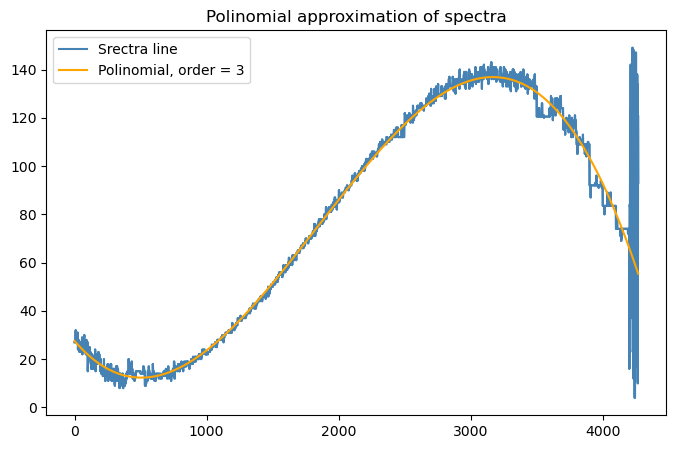

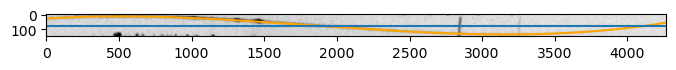

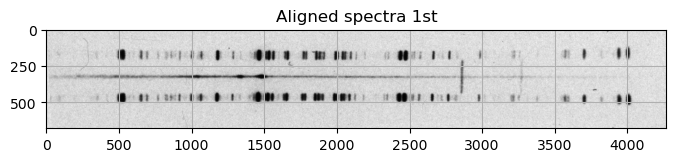

In [61]:
# spectra= polynomial_alighn(image,50,200,5)
# image_data_NGC4151_1m_0 = image_data_NGC4151_1m.max() - image_data_NGC4151_1m
# print(image_data_NGC4151_1m_0)
spectra_NGC4151_1m= polynomial_alighn(image_data_NGC4151_1m,250,400,3)

In [62]:
def preob_spectra(spectra):
    
    """
    Функция пересчитывает плотности почернения в интенсивности при помощи полинома, полученного 
    в работе с калибровками.
    На выходе преобразованный спектр и график, из которого необходимо определить на каких строках (х1 и х1) находится спектр.
    Тут же можно определить где находятся лампы.
    """
    x_log = (np.log10(65536/spectra) * 1000)
    spectra_1 = (2.803e-20*x_log**6 - 5.835e-16*x_log**5 + 1.635e-12*x_log**4 + 4.247e-08*x_log**3 - 0.0004067*x_log**2 + 1.439*x_log + 196.7).sum()
    
    spectra_ = polinomial(x_log)
#     
    sum_intens_row = spectra_.sum(axis=1)
    
    plt.figure(figsize=(6,4),dpi=120)
    plt.plot(sum_intens_row)
#     plt.grid(lw=0.1)
#     plt.xlim(300,350)
    
    plt.xlabel("Номер строки пикселей")
    plt.ylabel("Сумма интенсивностей")
    plt.savefig("spectra_background_rows.jpeg")
    return spectra_, sum_intens_row, spectra_1

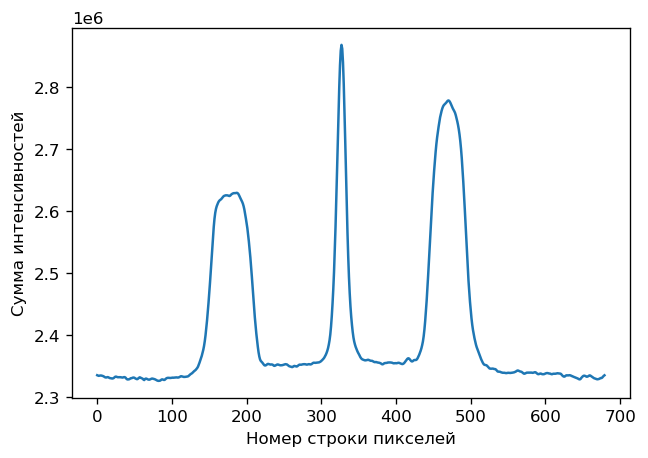

In [63]:
spectra_NGC4151_1m_preob,sum_intens_row_NGC4151, spectra_1_NGC4151  = preob_spectra(spectra_NGC4151_1m)

In [64]:
spectra_NGC4151_1m_preob

array([[554.20403876, 557.56991613, 557.12809462, ..., 534.73623158,
        534.61207695, 537.53143813],
       [550.0579139 , 553.07377803, 552.12616508, ..., 534.0464458 ,
        527.90093984, 530.15624071],
       [544.79549449, 547.31052263, 549.28386551, ..., 534.50368664,
        526.90102898, 526.22485763],
       ...,
       [547.98372825, 546.47992658, 543.76716113, ..., 538.6607017 ,
        547.05855702, 548.99187732],
       [545.60755442, 546.00712295, 546.24656963, ..., 537.2656136 ,
        541.1294353 , 544.0730258 ],
       [542.73315147, 546.40914692, 548.95819911, ..., 534.16207003,
        534.95564588, 538.43829325]])

In [65]:
def spectra_lamps(data,y1,y2,y3,y4,y5,y6):
    
    """
    Функция для вырезания из целого изображения спектра двух ламп и
    спектра самого объекта по отдельнсти.
    """
    
    lamp_1 = data[y1:y2]
    spectra = data[y3:y4]
    lamp_2 = data[y5:y6]
    
    
    fig, ax1 = plt.subplots(figsize=(10,8),dpi=120)
    ax1.imshow(lamp_1)
    ax1.set_title("lamp1")
    
    
    fig, ax2 = plt.subplots(figsize=(10,8),dpi=120)
    ax2.imshow(spectra)
    ax2.set_title("spectra")

    fig, ax3 = plt.subplots(figsize=(10,8),dpi=120)
    ax3.imshow(lamp_2)
    ax3.set_title("lamp2")

    
    fig, ax4 = plt.subplots(figsize=(10,8),dpi=120)
    ax4.imshow(data)
    ax4.set_title("data")
    ax4.axhline(y1,c="r",lw=1)
    ax4.axhline(y2,c="r",lw=1)
    ax4.axhline(y3,c="b",lw=1)
    ax4.axhline(y4,c="b",lw=1)
    ax4.axhline(y5,c="r",lw=1)
    ax4.axhline(y6,c="r",lw=1)
    
    return lamp_1, spectra, lamp_2

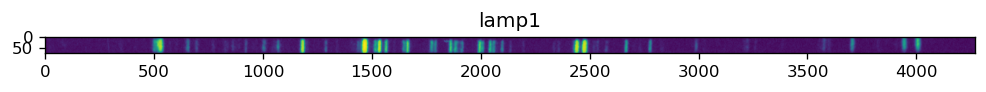

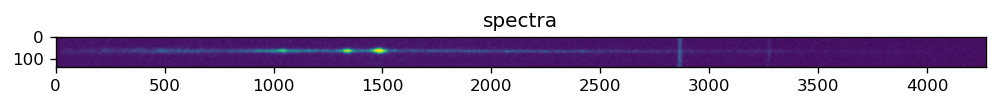

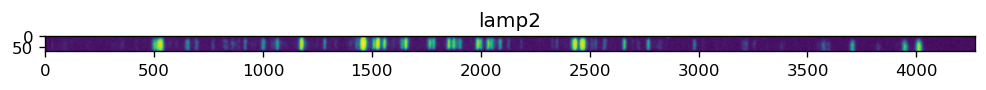

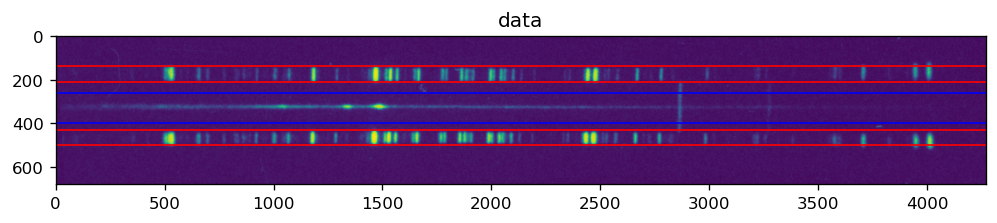

In [66]:
lamp_NGC4151_1m_1, spectra_NGC4151_1m_back, lamp_NGC4151_1m_2 = spectra_lamps(spectra_NGC4151_1m_preob,135,210,260,400,430,500)

In [67]:
spectra_NGC4151_1m_back

array([[542.55913775, 538.09085238, 535.04976912, ..., 535.45889921,
        542.58845775, 545.1847093 ],
       [540.38103297, 537.70954886, 535.02911314, ..., 534.22605322,
        538.66914958, 540.95340251],
       [537.98989414, 538.24144543, 537.31627519, ..., 532.3943518 ,
        536.08861869, 537.86019772],
       ...,
       [538.50097212, 542.36525117, 542.50584194, ..., 524.07998746,
        518.33641986, 524.67032743],
       [531.49535111, 536.15980429, 542.22642464, ..., 524.63730877,
        519.72283098, 522.90803454],
       [526.65018654, 533.24905582, 542.34126963, ..., 526.48233153,
        524.30508816, 523.91322188]])

In [68]:
def spectra_background(data,x1,x2):
    
    """
    Разбивает часть изображения со спектром на фон (над и под) и спектр.
    Вычитает фон из спектра и 
    на выходе выдает ГОТОВЫЙ спектр (+график, конечно же)
    """
    
    back_1 = data[0:x1]
    back_2 = data[x2:]
    back = np.concatenate((back_1,back_2))
    back_mean = back.mean(axis=0)
    
    spectrum = data[x1:x2]
    spectrum_sum = np.array(spectrum).sum(axis=0)
    spectrum_final = spectrum_sum - back_mean*(x2-x1)
    
    plt.figure(figsize=(8,4),dpi=120)
    plt.plot(spectrum_final)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
    plt.savefig("spectra_obj_back.jpg")
    
    return spectrum_final

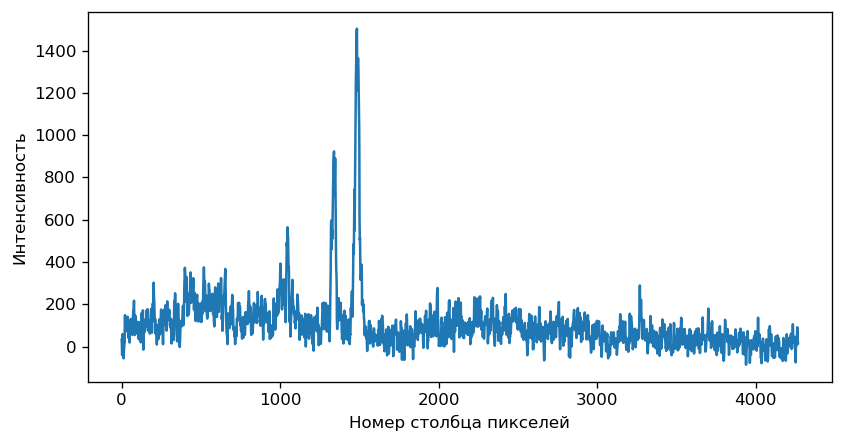

In [69]:
spectrum_final = spectra_background(spectra_NGC4151_1m_back,75,80)

In [70]:
len(lamp_NGC4151_1m_2)

70

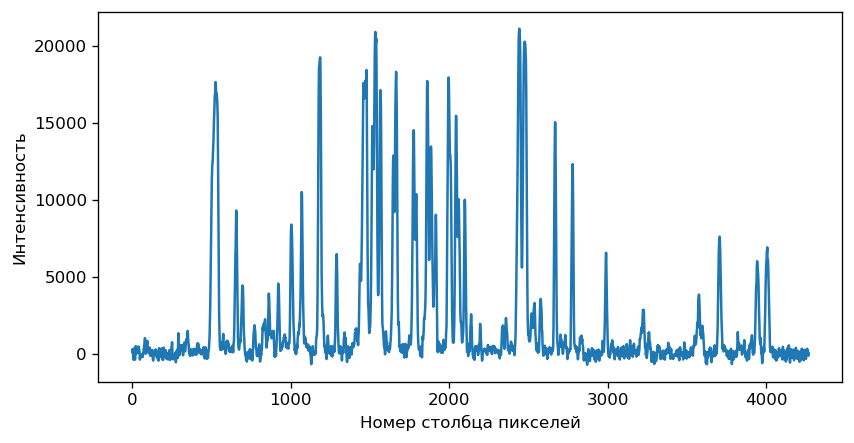

In [71]:
spectrum_final_lamp1 = spectra_background(lamp_NGC4151_1m_1,15,67)
# plt.axhline(spectrum_final_lamp1.mean())

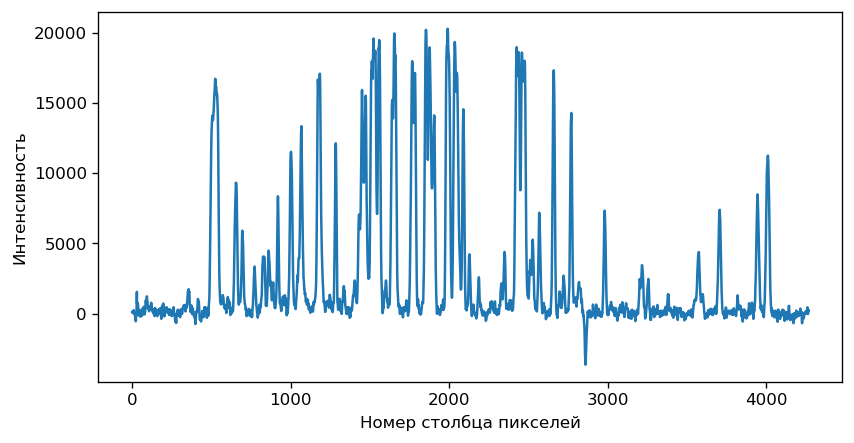

In [72]:
spectrum_final_lamp2 = spectra_background(lamp_NGC4151_1m_2,15,60)
# plt.axhline(spectrum_final_lamp2.mean())

In [73]:
def standart_deviation(list_value): #how it works
    mean = np.mean(list_value) 
    summ = []
    for i in list_value:
        summ.append((i-mean)**2)
    std = np.sqrt(np.sum(summ)/len(list_value))
    return std  #standart deviation for calc. gray line

def x_axis_to_wavelenght(lamp_1,lamp_2):
    
    lamp_1_std = standart_deviation(lamp_1)*0.5
    
    index_l_1 = []
    
    for i in range(1,len(lamp_1)-1): # finding peaks???
        if lamp_1[i] > lamp_1_std and lamp_1[i] > lamp_1[i+1] and lamp_1[i] > lamp_1[i-1]:
            index_l_1.append(i)   
     
    dalta_ind_l1 = []
    for i in range(1,len(index_l_1)):
        dalta_ind_l1.append(index_l_1[i]-index_l_1[i-1])
    delta_std_l1 = standart_deviation(dalta_ind_l1)  #what is this and for what is ???
    
    index_l1 = []
    counter_l1 = 0 
    for i in range(0,len(index_l_1)):
            
            if counter_l1 == 0:
                index_l1.append(index_l_1[i])
                countr_l1 =+ 1
           
            else:
                d = index_l_1[i] - index_l_1[i-1]
                countr_l1 =+ 1
                if d < delta_std_l1:
                    index_l1.append(index_l_1[i])  
    
    
    index_l1_1 = index_l1[0]
    index_l1_2 = index_l1[-1]
    
    lamp_2_std = standart_deviation(lamp_2)*0.5
    
    index_l_2 = []
    for i in range(1,len(lamp_2)-1):
        if lamp_2[i] > lamp_2_std and lamp_2[i] > lamp_2[i+1] and lamp_2[i] > lamp_2[i-1]:
            index_l_2.append(i)
            
        
    dalta_ind_l2 = []
    for i in range(1,len(index_l_2)):
        dalta_ind_l2.append(index_l_2[i]-index_l_2[i-1])
    delta_std_l2 = standart_deviation(dalta_ind_l2)
    
    index_l2 = []
    counter_l2 = 0 
    for i in range(0,len(index_l_2)):
            
            if counter_l2 == 0:
                index_l2.append(index_l_2[i])
                countr_l2 =+ 1
           
            else:
                d = index_l_2[i] - index_l_2[i-1]
                countr_l2 =+ 1
                if d < delta_std_l2:
                    index_l2.append(index_l_2[i])          
            
            
    index_l2_1 = index_l2[1]
    index_l2_2 = index_l2[-2]
    
    index_1 = int(np.mean([index_l1_1,index_l2_1]))
    index_2 = int(np.mean([index_l1_2,index_l2_2]))

        

    #PLOT
    fig,(ax1,ax2) = plt.subplots(2,figsize=(8,4),dpi=120)
#     ax1.figure(figsize=(18,9))
    ax1.plot(lamp_1,label="Лампа 1")
    ax1.axhline(lamp_1_std,c="gray",lw=1)
    ax1.axvline(index_l1_1,c="r",lw=1)
    ax1.axvline(index_l1_2,c="r",lw=1)
    # ax1.scatter(index_l1_1, lamp_1[index_l1_1],c="r",s=83)
    # ax1.scatter(index_l1_2, lamp_1[index_l1_2],c="r",s=83)
    ax1.scatter(index_l1, lamp_1[index_l1],c="g")
#     ax1.set_title("Lamp 1")
    ax1.legend(loc=2)
    ax1.set_xlabel("Номер столбца пикселей")
    ax1.set_ylabel("Интенсивность")
    
    ax2.plot(lamp_2,label="Лампа 2")
    ax2.axhline(lamp_2_std,c="gray",lw=1)
    ax2.axvline(index_l2_1,c="r",lw=1)
    ax2.axvline(index_l2_2,c="r",lw=1)    
    # ax2.scatter(index_l2_1, lamp_2[index_l2_1],c="r",s=83)
    # ax2.scatter(index_l2_2, lamp_2[index_l2_2],c="r",s=83)    
    ax2.scatter(index_l2, lamp_2[index_l2],c="g")
#     ax2.set_title("Lamp 2")
    ax2.legend(loc=2)
    
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
    plt.savefig("wavelenght_lamp.jpg")
    
    return index_1,index_2, index_l1,index_l2,index_l1_1,index_l1_2,index_l2_1,index_l2_2

In [74]:
def pixel2wavelenght(spectra,lambd_0,lambd_n,N_0,N_n):
    
    """
    Function calculates mean dispersion of wavelenghts
    and convert numbers of columns to wavelenght using lamp spectra.
    
    spectra -- final spectra of object/lamp without background (1-d array)
    lambd_0 -- the wavelengths of the first line of lamp spectra in angstroms 
    lambd_n -- the wavelengths of the last line of lamp spectra in angstroms
    N_0 -- column number of the first line
    N_n -- column number of the last line
    """
    dispersion = (lambd_n - lambd_0)/(N_n - N_0)
    wavelenght = []
    
    for i in range(0,len(spectra)):
        delta = i - N_0
        wl = delta * dispersion #distance in angstrom between a column and first line column
        wavelenght.append(lambd_0+wl)
        
        #PLOT
    plt.figure(figsize=(18,9))
    plt.plot(wavelenght,spectra)
    
    return wavelenght,dispersion

In [75]:
lambd_0 = 4711.2
lambd_n = 5764#5681

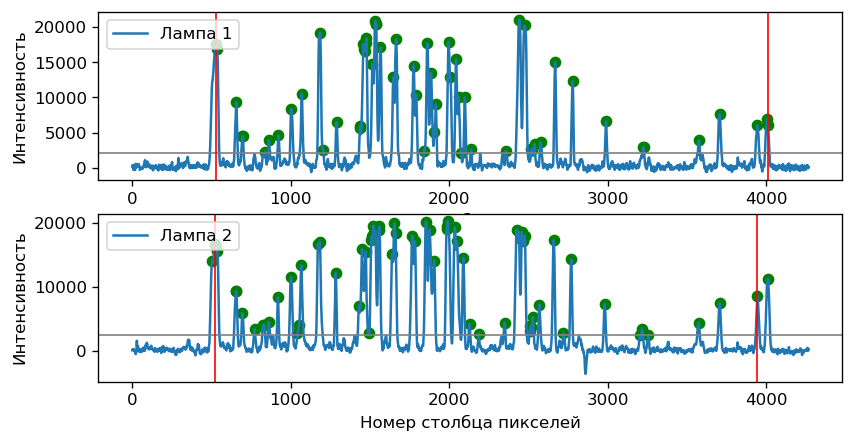

In [76]:
index_1,index_2,index_l1,index_l2,x10,x1n,x20,x2n = x_axis_to_wavelenght(spectrum_final_lamp1,spectrum_final_lamp2)

In [77]:
print(index_l1)

[526, 532, 656, 695, 697, 838, 862, 921, 1004, 1069, 1185, 1204, 1290, 1437, 1440, 1459, 1462, 1466, 1473, 1478, 1515, 1534, 1536, 1539, 1566, 1647, 1665, 1776, 1792, 1842, 1862, 1885, 1906, 1916, 1996, 2006, 2043, 2059, 2074, 2098, 2138, 2358, 2442, 2476, 2519, 2523, 2539, 2577, 2668, 2779, 2990, 3223, 3227, 3576, 3706, 3943, 4007, 4011]


In [78]:
print(index_l2)

[505, 524, 529, 534, 654, 656, 694, 772, 825, 832, 860, 919, 1002, 1042, 1051, 1067, 1171, 1183, 1284, 1431, 1450, 1473, 1493, 1509, 1512, 1522, 1527, 1533, 1555, 1558, 1640, 1654, 1661, 1766, 1784, 1853, 1876, 1905, 1985, 1988, 1990, 2035, 2048, 2089, 2128, 2187, 2349, 2425, 2438, 2459, 2468, 2476, 2507, 2511, 2514, 2527, 2568, 2660, 2721, 2770, 2981, 3202, 3216, 3257, 3575, 3707, 3945, 4011]


In [81]:
two_lamps_indexes = np.concatenate((index_l1,index_l2))
mean_indexes = []
index = []
for i in range(0, len(two_lamps_indexes)):
    index.append(i)
    d = np.arange(0,10,1)
#     if two_lamps_indexes[i] == two_lamps_indexes[i]+d


In [82]:
lamp1_mean = []
for i in range(0,len(index_l1)-1):
    d = index_l1[i+1]-index_l1[i]
    if d < 10:
        index_l1[i] = (index_l1[i+1] + index_l1[i])/2
        print(index_l1[i])
    elif d > 10:
        index_l1[i] = index_l1[i]
        print(index_l1[i])


529.0
532
656
696.0
697
838
862
921
1004
1069
1185
1204
1290
1438.5
1440
1460.5
1464.0
1469.5
1475.5
1478
1515
1535.0
1537.5
1539
1566
1647
1665
1776
1792
1842
1862
1885
1916
2006
2043
2059
2074
2098
2138
2358
2442
2476
2521.0
2523
2539
2577
2668
2779
2990
3225.0
3227
3576
3706
3943
4009.0


In [266]:
lamp1_mean

[]

In [83]:
# d = np.arange(0,10,1)

mean_indexes = []
if len(index_l1)<len(index_l2):
    for i in range(0,len(index_l1)):
        d = index_l1[i] - index_l2[i]
        if index_l1[i] == index_l2[i]:
            mean_indexes.append(index_l1[i])
            while -5 < d < 5:
                index_l1[i] == (index_l1[i] + index_l2[i])/2
                mean_indexes.append(index_l1[i])
else:
    for i in range(0,len(index_l2)):
        d = index_l1[i] - index_l2[i]
        if index_l1[i] == index_l2[i]:
            mean_indexes.append(index_l1[i])
            while -5 < d < 5:
                index_l1[i] == (index_l1[i] + index_l2[i])/2
                mean_indexes.append(index_l1[i])
                
                

In [84]:
mean_indexes

[]

(0.0, 30000.0)

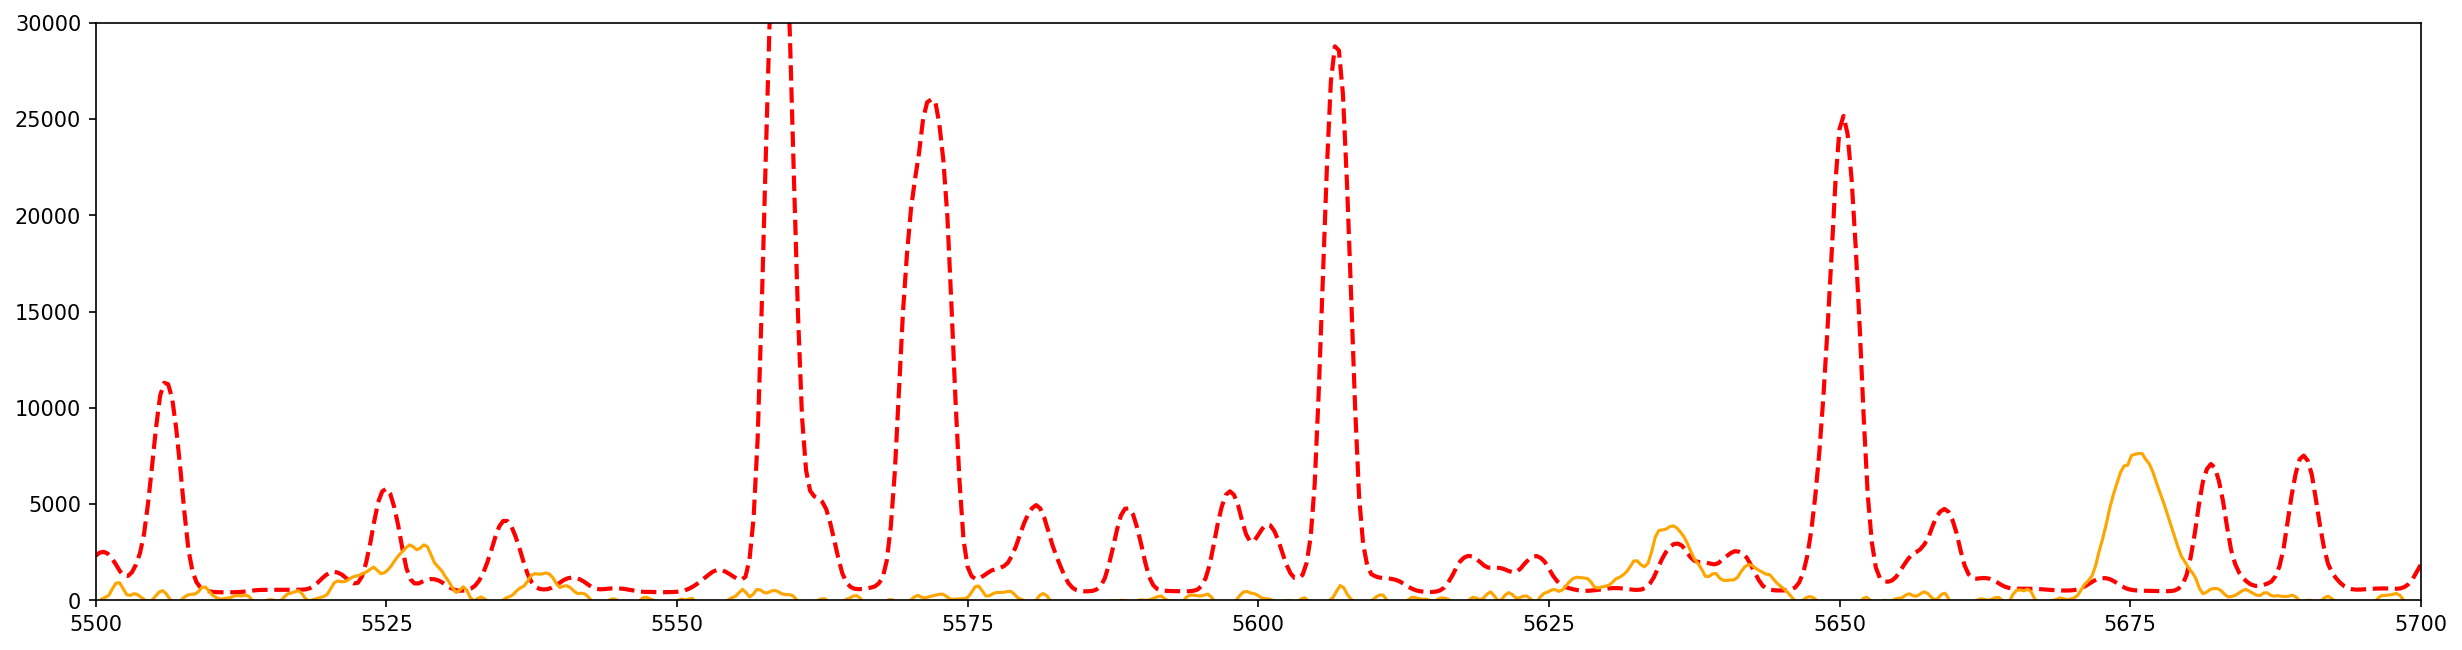

In [136]:
with open('files_lamps/HeArNe.txt') as f:
    lines = f.readlines()
    
wvl = []
intens = []
for line in lines:
    line = line.split("  ")
    #print(line)
    wvl.append(float(line[0].strip()))
    intens.append(float(line[1].strip())) 
    
# выберем кол-во точек для скользящего среднего
N_rm = 7

# создаем функцию окна
W = np.zeros_like(intens); W[0:N_rm]=1

FConv = np.fft.fft(intens)*np.fft.fft(W)

TConv = np.fft.ifft(FConv).real/N_rm

# отбрасываем те точки, где скользящее среднее неадекватно срабатывает 
# то есть первые и последние N_rm/2 точек

Nskip = int((N_rm-1)/2) 
X_rm = np.pad(TConv[Nskip:],(0,Nskip),'constant')




plt.figure(figsize=(20,5),dpi=150)
#plt.plot(wvl,intens)
plt.plot(wvl,X_rm,color='red', lw=2, ls='--', label=r'RM')
#plt.plot(np.array(wavelenght),spectrum_final_lamp1,c="y",alpha=0.3)
plt.plot(np.array(wavelenght)-15,spectrum_final_lamp1,c="orange")
plt.xlim(5500,5700)
plt.ylim(0,30000)

In [91]:
spectrum_final_lamp1.("lamp_array.txt", format="float")

In [95]:
np.min(wavelenght)

4549.538695525007

In [96]:
np.max(wavelenght)

5863.768119333138

In [113]:
np.array(wavelenght)-30

array([4519.53869553, 4519.84662182, 4520.15454811, ..., 5833.15226674,
       5833.46019304, 5833.76811933])

In [98]:
len(spectrum_final_lamp1)

4269

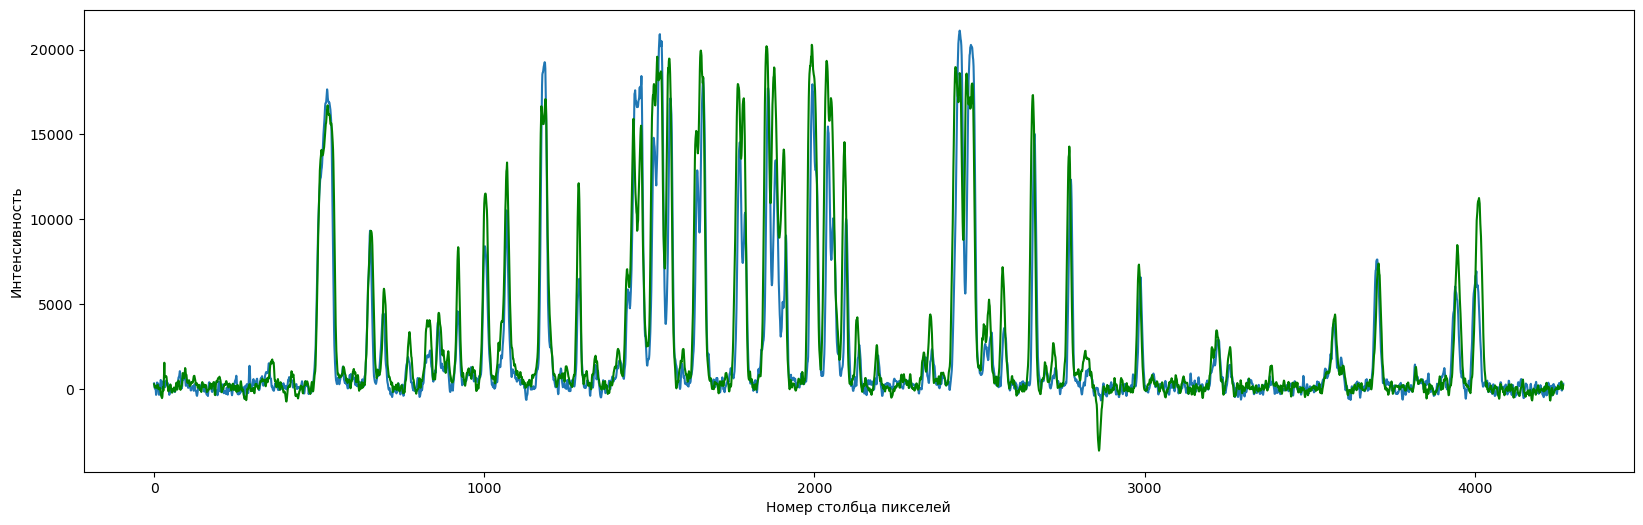

In [85]:
plt.figure(figsize=(20,6))
plt.plot(np.roll(spectrum_final_lamp1,-2),label="Лампа 1")
plt.plot(np.roll(spectrum_final_lamp2,2),c="g",label="Лампа 2")
plt.xlabel("Номер столбца пикселей")
plt.ylabel("Интенсивность")
plt.savefig("roll_lamps.jpg")

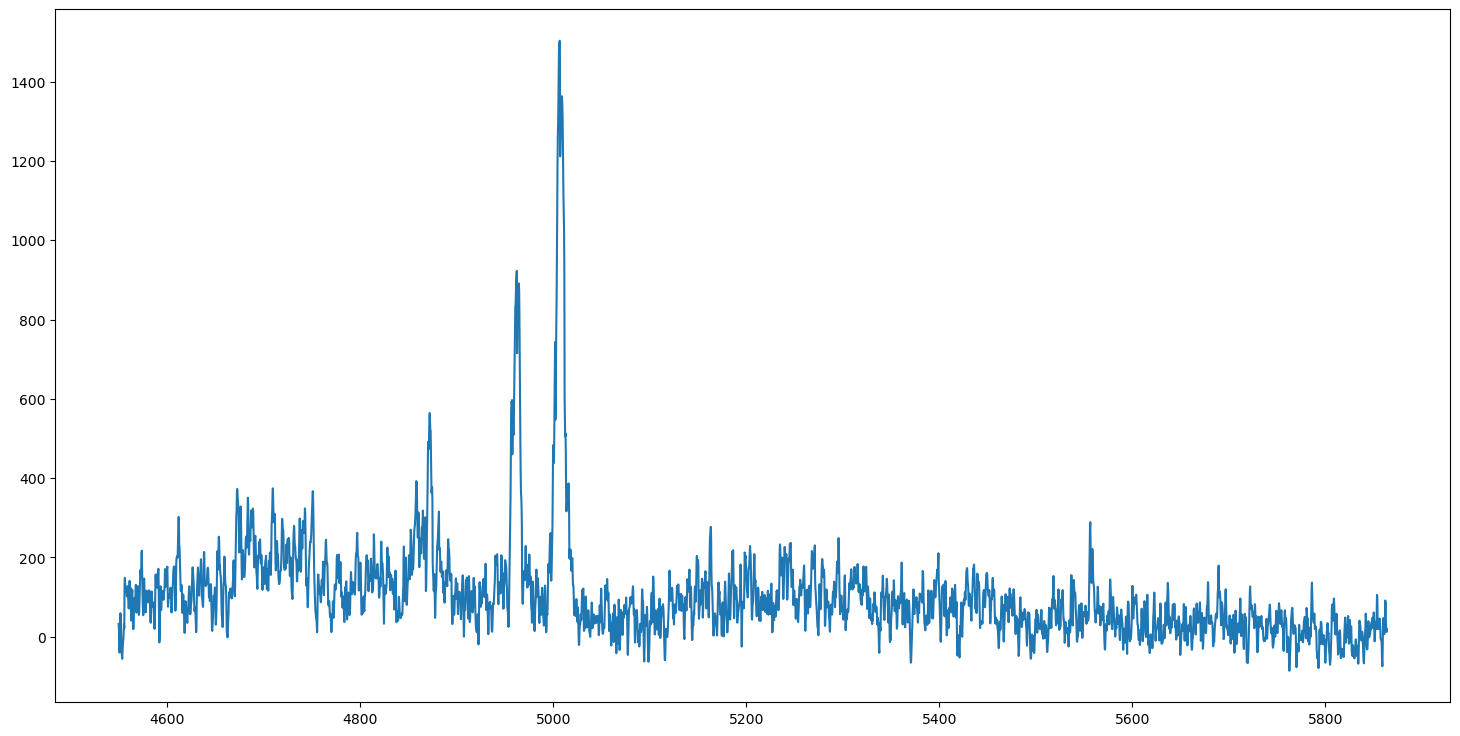

In [87]:
wavelenght,dispersion = pixel2wavelenght(spectrum_final,lambd_0,lambd_n,525,3944)

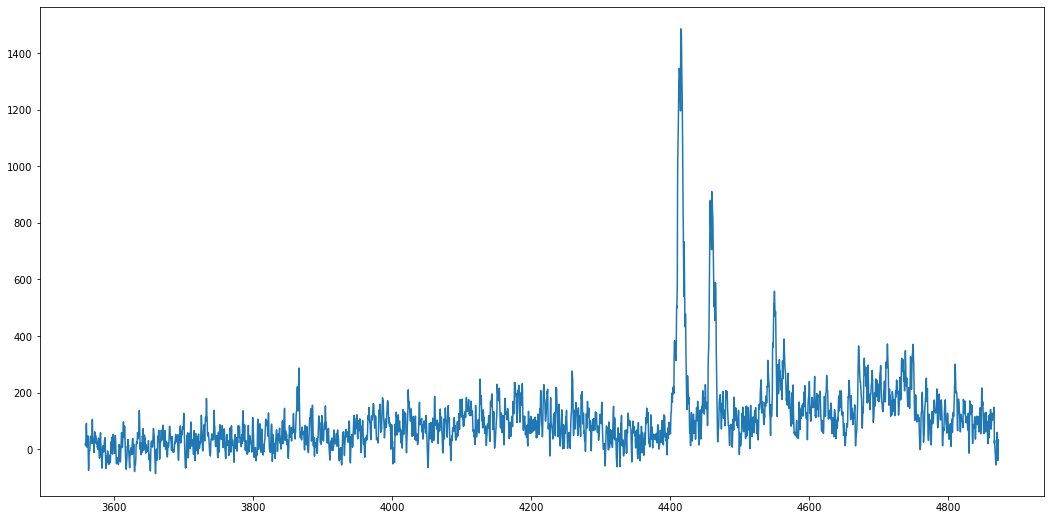

In [69]:
dispersion = (lambd_n - lambd_0)/(525 - 3944)
wavelenght_ch = []

for i in range(0,len(spectrum_final)):
    delta = i - 525
    wl = delta * dispersion #distance in angstrom between a column and first line column
    wavelenght_ch.append(lambd_0+wl)

    #PLOT
plt.figure(figsize=(18,9))
plt.plot(wavelenght_ch,spectrum_final)

In [71]:
def aprx(x,y,order):

    # monotone = False
        
    z = np.polyfit( x,y,order)
    p = np.poly1d(z)
    xp = np.linspace(x[0], x[-1], 1000)
    # print(xp)
    pxp = p(xp)

    for i in range(1,len(pxp)):
        max_pxp = y[:-1].max()
        if pxp[i]<=pxp[i-1]:
            pxp[i]=pxp[i-1]+1
            if pxp[i]>=max_pxp:
                min_pxp = pxp[i-100]
                delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                index = i-10
                break


    for j in range(index+1,len(pxp)):
        pxp[j]=pxp[j-1]+delta_pxp
               
    fig, ax1 = plt.subplots(figsize=(6,4),dpi=120)
    ax1 = plt.scatter(x,y, color="blue",s=50) 
    ax1 = plt.plot(xp, p(xp), color="orange",lw=2,label=f"Полином ({order})")   
    plt.legend()
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd_polinomial.jpg")
    
    return xp,p

In [71]:
def func(index_1,index_2,x1,x3,x4,x5,x6,x7,lambd_1,lambd_3,lambd_4,lambd_5,lambd_6,lambd_7,wavelenght):
    
    delta_lambd_1 = wavelenght[x1] - lambd_1 
    delta_lambd_2 = wavelenght[x2] - lambd_2 
    delta_lambd_3 = wavelenght[x3] - lambd_3 
    delta_lambd_4 = wavelenght[x4] - lambd_4 
    delta_lambd_5 = wavelenght[x5] - lambd_5
    delta_lambd_6 = wavelenght[x6] - lambd_6 
    delta_lambd_7 = wavelenght[x7] - lambd_7 
    
    print(wavelenght[x2])
    
    #corr = np.array([0,delta_lambd_1,delta_lambd_2,delta_lambd_3,delta_lambd_4,delta_lambd_5,delta_lambd_6,delta_lambd_7,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    corr = np.array([0,delta_lambd_1,delta_lambd_3,delta_lambd_4,delta_lambd_5,delta_lambd_6,delta_lambd_7,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    
    plt.figure(figsize=(6,4), dpi=120)
    plt.scatter([index_1,x1,x3,x4,x5,x6,x7,index_2],corr,s=50)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd.jpg")
    xpp, polinomial = aprx([index_1,x1,x3,x4,x5,x6,x7,index_2],corr,2)
    
    columns = np.arange(0,len(wavelenght))
    
    correction_whole = np.array(polinomial(columns))
    
    wavelenght_corrected = wavelenght + correction_whole
    
    return wavelenght_corrected,polinomial

In [72]:

x2 = int(np.mean([695,694])) #3line
x3 = int(np.mean([1181,1177]))
x4 = int(np.mean([1290,1284]))
x5 = int(np.mean([1465,1461]))
x6 = int(np.mean([1993,1987]))
x7 = int(np.mean([2475,2469]))
x8 = int(np.mean([2668,2660]))
x9 = int(np.mean([2777,2770]))
x10 = int(np.mean([2990,2981]))

x_list = [x2,x3,x4,x5,x6,x7,x8,x9,x10]



lambd_2 = 4752.73
lambd_3 = 4921.93
lambd_4 = 4957.03
lambd_5 = 5015.7
lambd_6 = 5187.75
lambd_7 = 5341.9
lambd_8 = 5400.56
lambd_9 = 5433.65
lambd_10 = 5495.83

lambd_list = [lambd_2,lambd_3,lambd_4,lambd_5,lambd_6,lambd_7,lambd_8,lambd_9,lambd_10]

In [73]:
x_list

[694, 1179, 1287, 1463, 1990, 2472, 2664, 2773, 2985]

In [74]:
len(lambd_list)

9

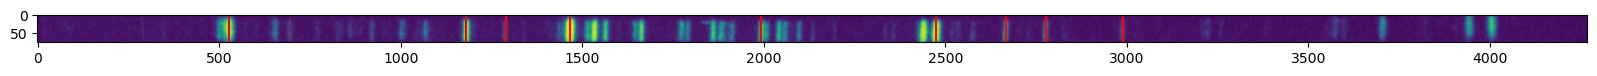

In [75]:
plt.figure(figsize=(20,5),dpi=100)
plt.imshow(lamp_NGC4151_1m_1)
plt.axvline( 526,c="red")
plt.axvline( 695,c="red",lw=0.3)
plt.axvline(1181,c="red")
plt.axvline(1290,c="red")
plt.axvline(1465,c="red")
plt.axvline(1993,c="red")
plt.axvline(2475,c="red")
plt.axvline(2668,c="red")
plt.axvline(2777,c="red")
plt.axvline(2990,c="red")

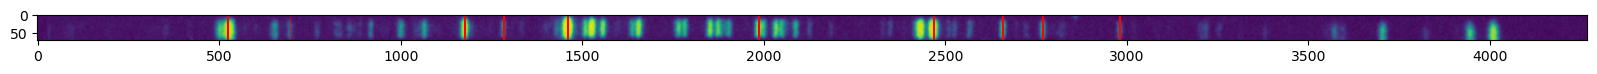

In [76]:
plt.figure(figsize=(20,5),dpi=100)
plt.imshow(lamp_NGC4151_1m_2)
plt.axvline( 524,c="red")
plt.axvline( 694,c="red",lw=0.4)
plt.axvline(1177,c="red")
plt.axvline(1284,c="red")
plt.axvline(1461,c="red")
plt.axvline(1987,c="red")
plt.axvline(2469,c="red")
plt.axvline(2660,c="red")
plt.axvline(2770,c="red")
plt.axvline(2981,c="red")

[  0.          10.50954373  -9.34620357 -11.19016379 -15.665136
 -25.43797894 -31.16750512 -30.70565662 -30.23169055 -27.13131617
   0.        ]


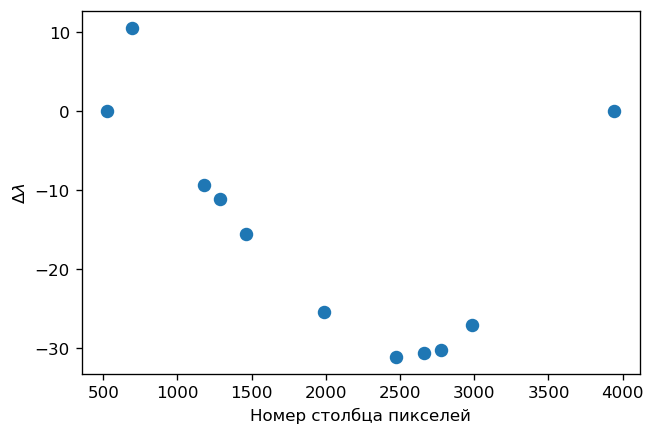

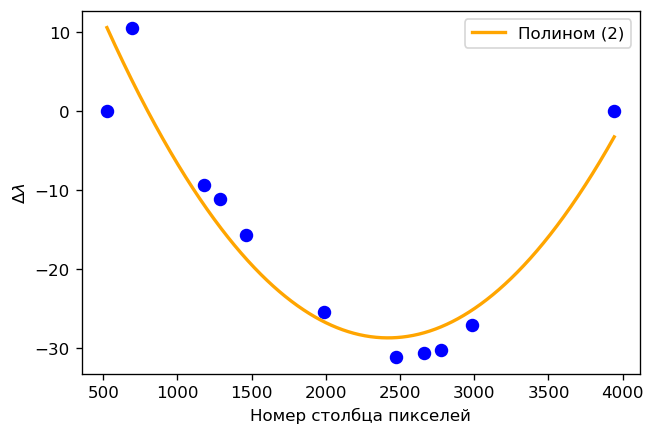

In [77]:
def func(index_1,index_2,x_list,lambd_list,wavelenght):
    
    if len(x_list)!=len(lambd_list):
        raise ValueError("lenght of x and lambda have to be the same!")
    else:
        pass
    delta_lambd = [] 

    for i in range(0,len(x_list)):
        delta_lambd.append(wavelenght[x_list[i]]-lambd_list[i])
    
    #corr = np.array([0,delta_lambd_1,delta_lambd_2,delta_lambd_3,delta_lambd_4,delta_lambd_5,delta_lambd_6,delta_lambd_7,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    delta_lambd.insert(0,0) #0 in the begging because we exactly know wavelenght of index_1
    delta_lambd.append(0) #0 in the end because we exactly know wavelenght of index_2
    delta_lambd = np.array(delta_lambd)
    print(delta_lambd)
    xdata = x_list
    xdata.append(index_2)
    xdata.insert(0,index_1)
    xdata = np.array(xdata)
    
    plt.figure(figsize=(6,4), dpi=120)
    plt.scatter(xdata,delta_lambd,s=50)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd.jpg")
    

    xpp, polinomial = aprx(xdata,delta_lambd,2)
    
    columns = np.arange(0,len(wavelenght))
    
    correction_whole = np.array(polinomial(columns))
    
    wavelenght_corrected = wavelenght + correction_whole
    
    return wavelenght_corrected,polinomial

wv,pp = func(525,3943,x_list,lambd_list,wavelenght)

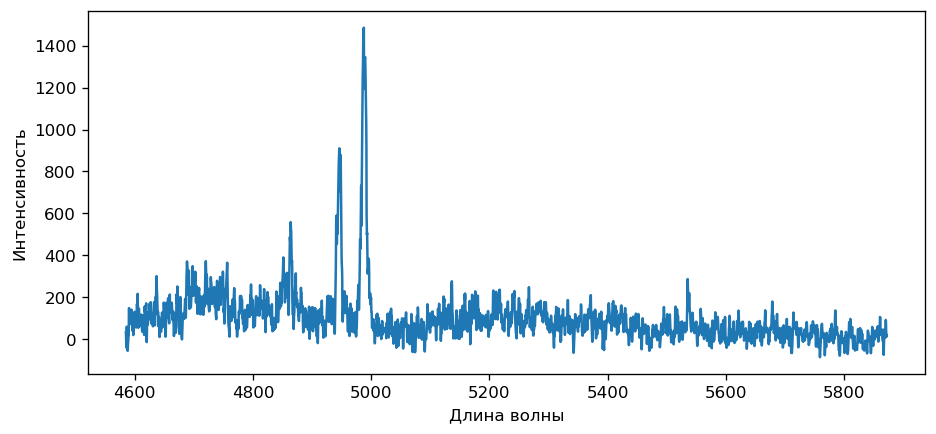

In [78]:
plt.figure(figsize=(9,4),dpi=120)
plt.plot(wv,spectrum_final)
plt.xlabel("Длина волны")
plt.ylabel("Интенсивность")
plt.savefig("final_spectra.jpg")

In [79]:
a = [1,2]
a = a.append(0)

In [80]:
np.argmax(spectrum_final)

1484

In [81]:
delta_dis= wv[1484]-5037,75
delta_dis

(-49.66710430526382, 75)

In [82]:
dispersion

-0.3079262942380814

# NGC4151 2m 

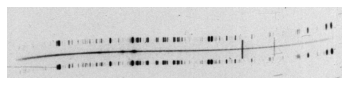

In [83]:
fits_2m = fits.open('NGC4151_HB/NGC4151_16-6_2m_3200dpi.fit.fits')
data_NGC4151_2m  = fits_2m[0].data
plt.imshow(data_NGC4151_2m, cmap='gray') 
plt.axis("off")
plt.imsave("data_NGC4151_2m.jpg",data_NGC4151_2m)

176.22084150465963
-3.7791584953403685


<ipython-input-11-ba3da88bcd7b>:44: RuntimeWarning: divide by zero encountered in true_divide
  array_log10 = np.log10(65536/lina_croped)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)


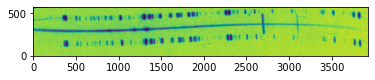

In [84]:
shape1 = data_NGC4151_2m.shape[1]
shape0 = data_NGC4151_2m.shape[0]

x1= int((0.008) * shape1)
y1= int((1-0.471) * shape0)
x2= int((0.936) * shape1)
y2= int((1-0.76) * shape0)
x3= int((1.048) * shape1)
y3= int((1-0.4) * shape0)
x4= int((0.121) * shape1)
y4= int((1-0.111) * shape0)

image_data_NGC4151_2m,mean_data_NGC4151_2m = subimage_preob('data_NGC4151_2m.jpg',data_NGC4151_2m,x1,y1,x2,y2,x3,y3,x4,y4)
del mean_data_NGC4151_2m

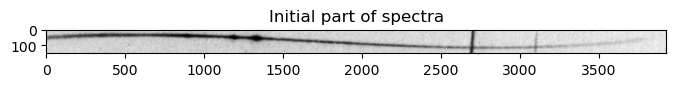

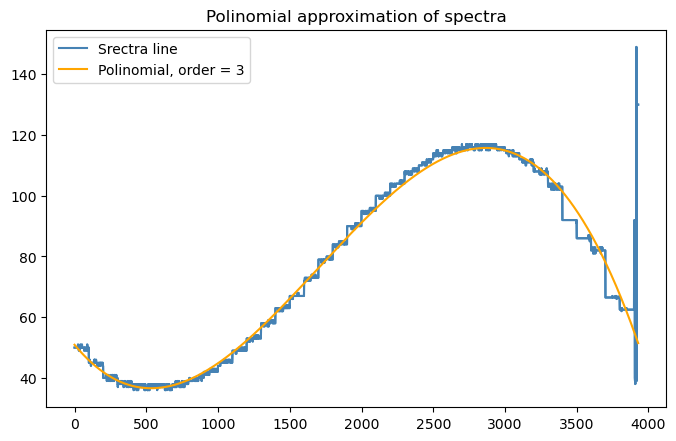

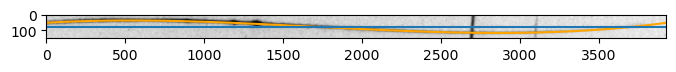

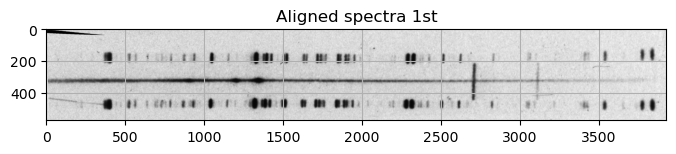

In [85]:
spectra_NGC4151_2m= polynomial_alighn(image_data_NGC4151_2m,250,400,3)

<ipython-input-45-d3672941eddc>:9: RuntimeWarning: divide by zero encountered in true_divide
  x_log = (np.log10(65536/spectra) * 1000)
<ipython-input-45-d3672941eddc>:10: RuntimeWarning: invalid value encountered in subtract
  spectra_1 = (2.803e-20*x_log**6 - 5.835e-16*x_log**5 + 1.635e-12*x_log**4 + 4.247e-08*x_log**3 - 0.0004067*x_log**2 + 1.439*x_log + 196.7).sum()
/home/adel/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


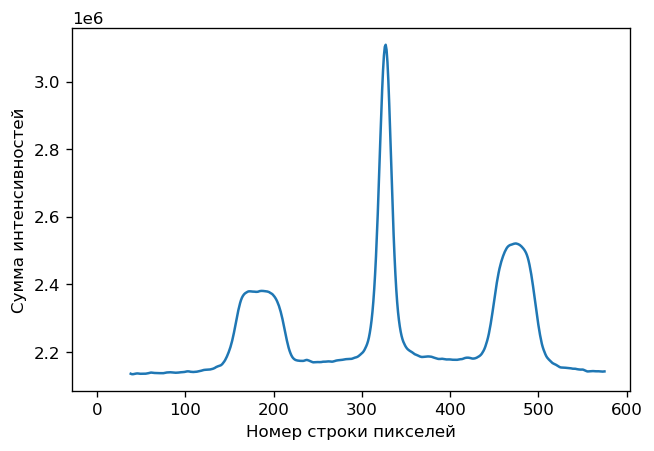

In [86]:
spectra_NGC4151_2m_preob,sum_intens_row_NGC4151_2m, spectra_2_NGC4151  = preob_spectra(spectra_NGC4151_2m)

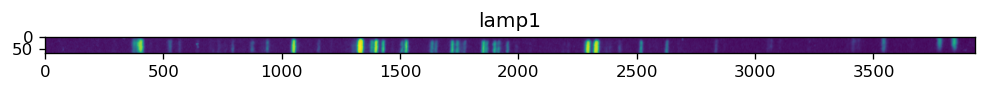

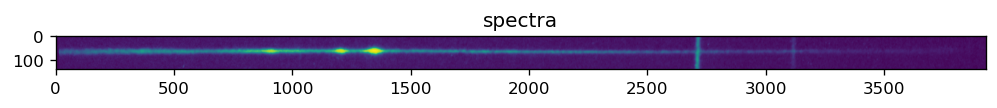

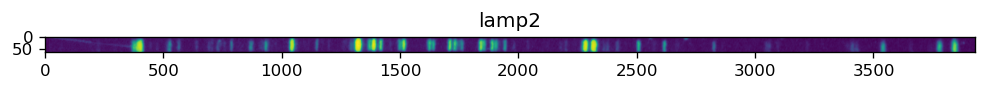

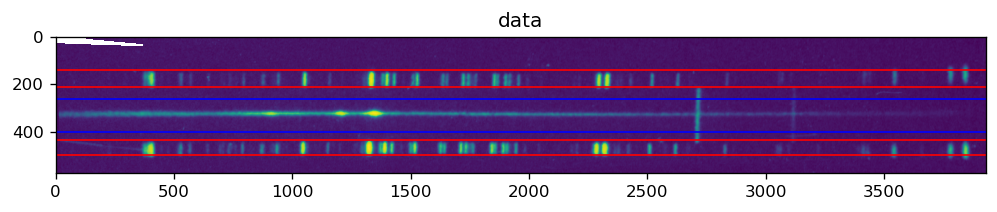

In [87]:
lamp_NGC4151_2m_1, spectra_NGC4151_2m_back, lamp_NGC4151_2m_2 = spectra_lamps(spectra_NGC4151_2m_preob,140,210,260,400,435,500)

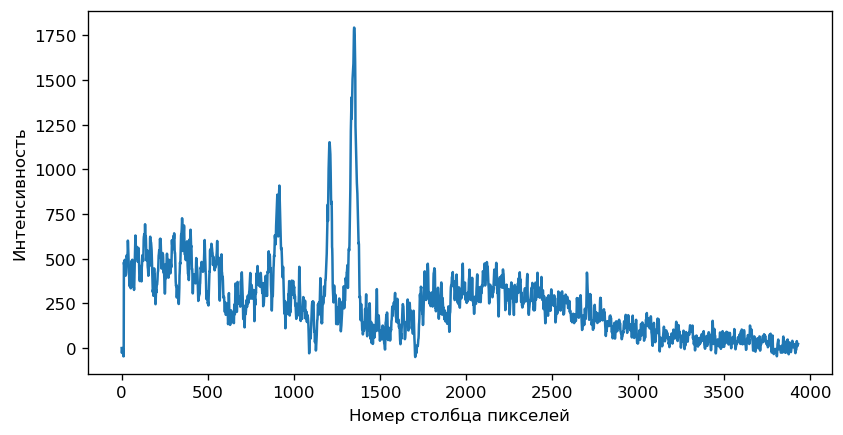

In [88]:
spectrum_final_2m = spectra_background(spectra_NGC4151_2m_back,75,80)

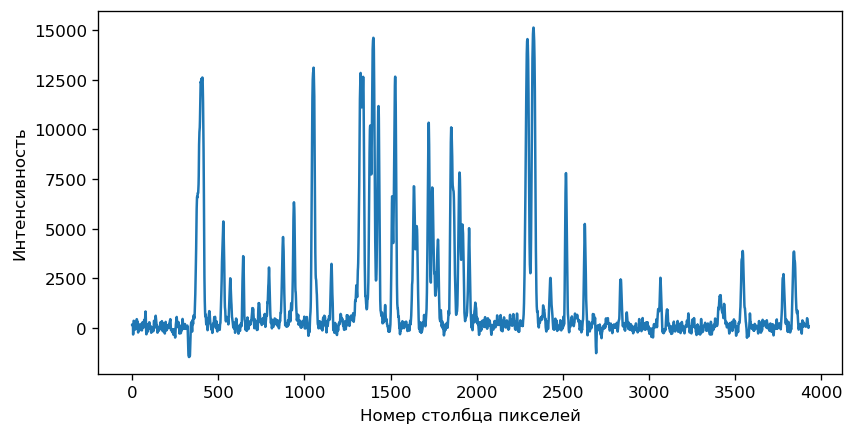

In [89]:
spectrum_final_lamp1_2m = spectra_background(lamp_NGC4151_2m_1,15,60)
# plt.axhline(spectrum_final_lamp1.mean())

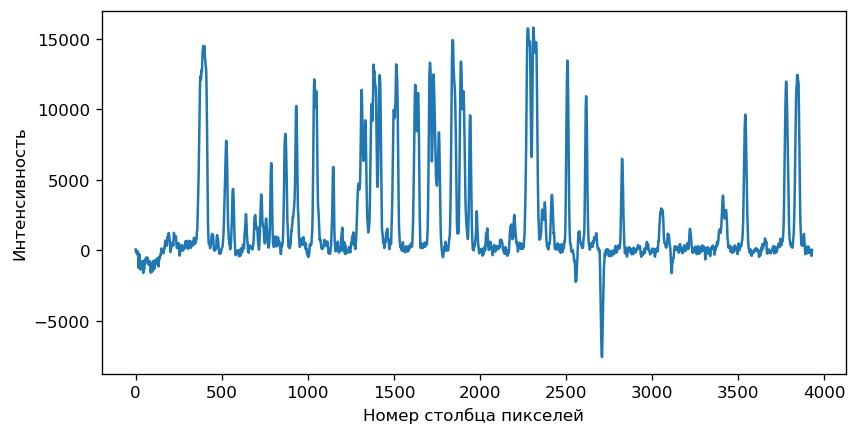

In [90]:
spectrum_final_lamp2_2m = spectra_background(lamp_NGC4151_2m_2,20,60)
# plt.axhline(spectrum_final_lamp2.mean())

In [91]:
lambd_0 = 4711.2
lambd_n = 5764#5681

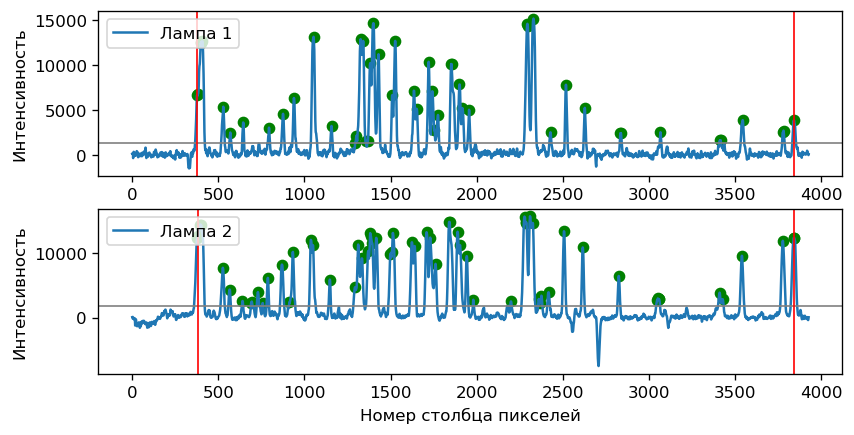

In [152]:
index_1,index_2,index_l1,index_l2,x10,x1n,x20,x2n = x_axis_to_wavelenght(spectrum_final_lamp1_2m,spectrum_final_lamp2_2m)

In [93]:
print(index_l1)

[377, 381, 398, 401, 407, 529, 569, 644, 794, 876, 939, 1053, 1157, 1295, 1301, 1326, 1341, 1355, 1367, 1382, 1400, 1430, 1509, 1527, 1635, 1652, 1721, 1742, 1755, 1775, 1852, 1854, 1900, 1917, 1956, 2295, 2297, 2330, 2429, 2519, 2628, 2835, 2837, 3067, 3412, 3417, 3545, 3778, 3782, 3843]


In [94]:
print(index_l2)

[377, 383, 393, 399, 526, 565, 640, 691, 694, 730, 757, 787, 869, 913, 933, 1037, 1049, 1147, 1294, 1312, 1334, 1370, 1382, 1385, 1394, 1417, 1499, 1507, 1514, 1624, 1640, 1709, 1730, 1761, 1841, 1843, 1889, 1904, 1942, 1981, 2199, 2278, 2284, 2288, 2310, 2326, 2361, 2367, 2376, 2418, 2507, 2616, 2825, 3048, 3052, 3057, 3059, 3411, 3428, 3540, 3778, 3842, 3844]


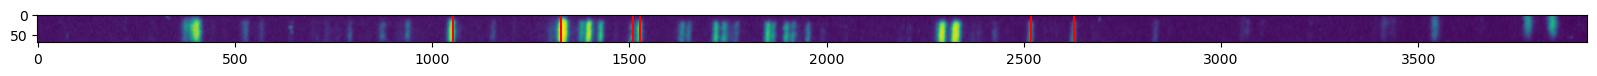

In [133]:
plt.figure(figsize=(20,5),dpi=100)
plt.imshow(lamp_NGC4151_2m_1)
# plt.axvline( 377,c="k",lw=0.5)
# plt.axvline( 381,c="k",lw=0.5)
# plt.axvline(401,c="y")
plt.axvline(2628,c="r")
plt.axvline(1053,c="r")
plt.axvline(1326,c="r")
plt.axvline(1509,c="red")
plt.axvline(1527,c="red")
plt.axvline(2519,c="red")

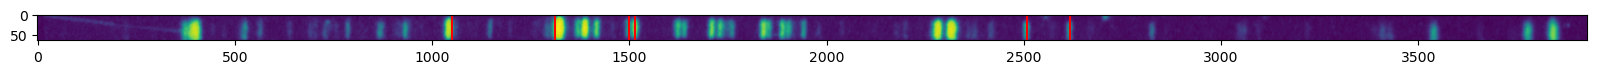

In [137]:
plt.figure(figsize=(20,5),dpi=100)
plt.imshow(lamp_NGC4151_2m_2)
# plt.axvline( 377,c="k",lw=0.5)
# plt.axvline( 381,c="k",lw=0.5)
plt.axvline(2616,c="r")
plt.axvline(2507,c="r")
plt.axvline(1049,c="r")
plt.axvline(1312,c="red")
plt.axvline(1499,c="red")
plt.axvline(1514,c="red")

In [95]:
print(len(index_l1), len(index_l2))

50 63


In [149]:
index_2

3842

In [157]:

x2 = int(np.mean([1053,1049])) #3line
x3 = int(np.mean([1326,1312]))#
x4 = int(np.mean([1509,1499]))#
x5 = int(np.mean([1527,1514]))
x6 = int(np.mean([2519,2507]))
x7 = int(np.mean([2628,2616]))
# x8 = int(np.mean([2668,2660]))
# x9 = int(np.mean([2777,2770]))
# x10 = int(np.mean([2990,2981]))

x_list = [x2,x3,x4,x5,x6,x7]



lambd_2 = 4921.93
lambd_3 = 5051.7
lambd_4 = 5074.20
lambd_5 = 5080.38
lambd_6 = 5400.56
lambd_7 = 5433.65
# lambd_8 = 5400.56
# lambd_9 = 5433.65
# lambd_10 = 5495.83

lambd_list = [lambd_2,lambd_3,lambd_4,lambd_5,lambd_6,lambd_7]

[  0.         -48.76076923 -96.00652237 -61.54015794 -62.79333723
 -77.20252705 -76.72856098   0.        ]


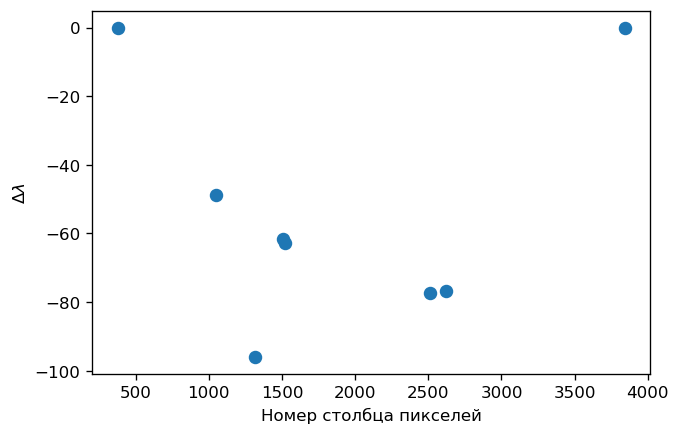

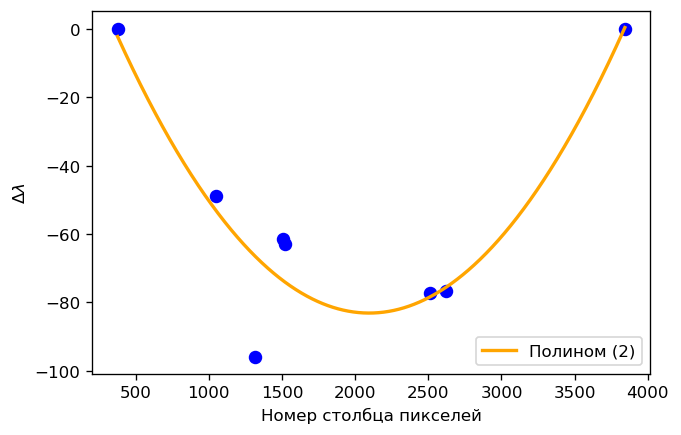

In [158]:
def func(index_1,index_2,x_list,lambd_list,wavelenght):
    
    if len(x_list)!=len(lambd_list):
        raise ValueError("lenght of x and lambda have to be the same!")
    else:
        pass
    delta_lambd = [] 

    for i in range(0,len(x_list)):
        delta_lambd.append(wavelenght[x_list[i]]-lambd_list[i])
    
    #corr = np.array([0,delta_lambd_1,delta_lambd_2,delta_lambd_3,delta_lambd_4,delta_lambd_5,delta_lambd_6,delta_lambd_7,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    delta_lambd.insert(0,0) #0 in the begging because we exactly know wavelenght of index_1
    delta_lambd.append(0) #0 in the end because we exactly know wavelenght of index_2
    delta_lambd = np.array(delta_lambd)
    print(delta_lambd)
    xdata = x_list
    xdata.append(index_2)
    xdata.insert(0,index_1)
    xdata = np.array(xdata)
    
    plt.figure(figsize=(6,4), dpi=120)
    plt.scatter(xdata,delta_lambd,s=50)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd.jpg")
    

    xpp, polinomial = aprx(xdata,delta_lambd,2)
    
    columns = np.arange(0,len(wavelenght))
    
    correction_whole = np.array(polinomial(columns))
    
    wavelenght_corrected = wavelenght + correction_whole
    
    return wavelenght_corrected,polinomial

wv,pp = func(377,3843,x_list,lambd_list,wavelenght)

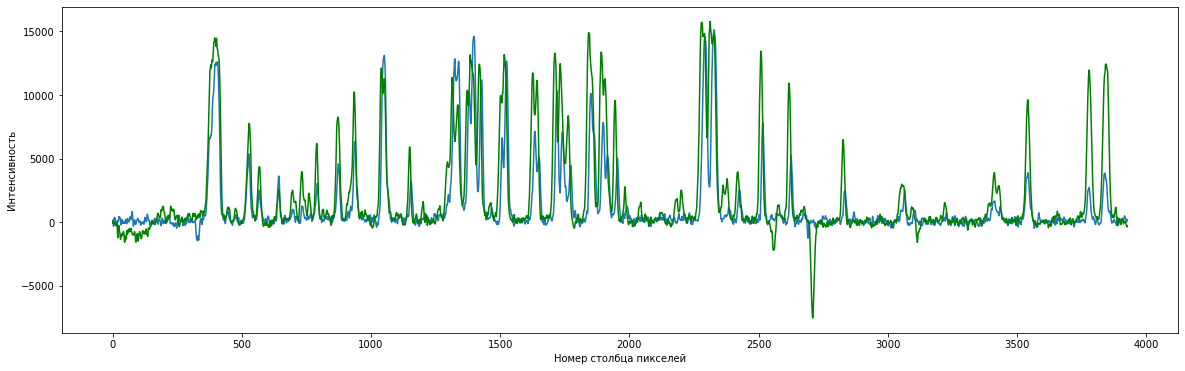

In [159]:

plt.figure(figsize=(20,6))
plt.plot(np.roll(spectrum_final_lamp1_2m,-2),label="Лампа 1")
plt.plot(np.roll(spectrum_final_lamp2_2m,2),c="g",label="Лампа 2")
# plt.xlim(400,500)
plt.xlabel("Номер столбца пикселей")
plt.ylabel("Интенсивность")
plt.savefig("roll_lamps.jpg")


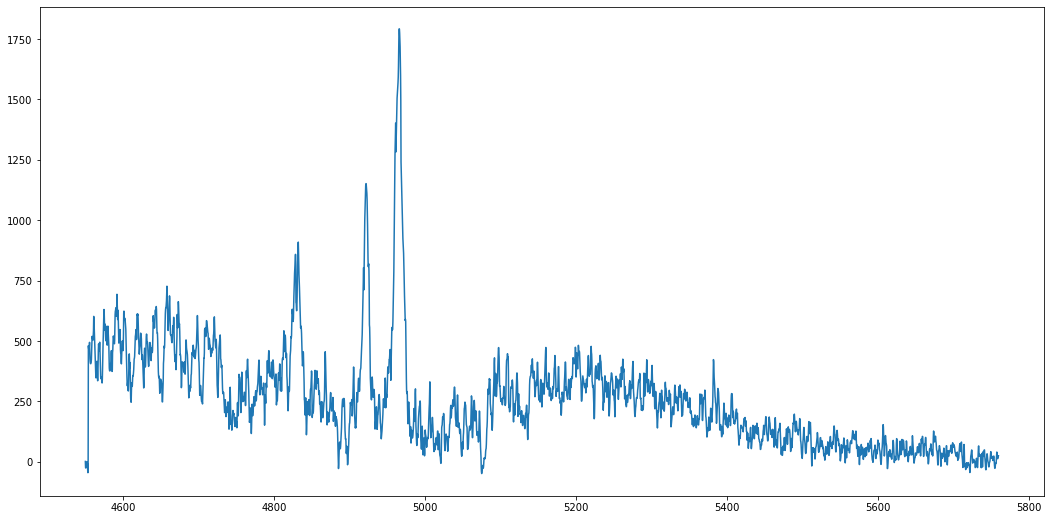

In [160]:
wavelenght,dispersion = pixel2wavelenght(spectrum_final_2m,lambd_0,lambd_n,525,3944)

# NGC4151 29-2 


### расчет калибровок для 29-6(16-17.04.1988) 

In [17]:
data_call15s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_15s_29-6-3200dpi.fit.fits")
data_call30s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_30s_29-6-3200dpi.fit.fits")
data_call1m = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_1m_29-6-3200dpi.fit.fits")
data_call1m30s = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_1m30s_29-6-3200dpi.fit.fits")
data_call3m = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_3m_29-6-3200dpi.fit.fits")
data_call6m = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_6m_29-6-3200dpi.fit.fits")
data_call7m = fits2png("/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_7m_29-6-3200dpi.fit.fits")

In [18]:
o_call15s = np.array(data_call15s)#*255/65536 #make an array from list
o_call30s = np.array(data_call30s)#*255/65536 #make an array from list
o_call1m = np.array(data_call1m)#*255/65536 #make an array from list
o_call1m30s = np.array(data_call1m30s)#*255/65536 #make an array from list
o_call3m = np.array(data_call3m)#*255/65536 #make an array from list
o_call6m = np.array(data_call6m)#*255/65536 #make an array from list
o_call7m = np.array(data_call7m)#*255/65536 #make an array from list

172.45728184461277
-7.5427181553872344


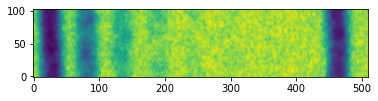

In [19]:
shape1 = o_call15s.shape[1]
shape0 = o_call15s.shape[0]

x1= int((0.433) * shape1)
y1= int((1-0.564) * shape0)
x2= int((0.619) * shape1)
y2= int((1-0.608) * shape0)
x3= int((0.634) * shape1)
y3= int((1-0.544) * shape0)
x4= int((0.447) * shape1)
y4= int((1-0.501) * shape0)

#image_5s,mean_ax25s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_15s,mean_15s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_15s_29-6-3200dpi.fit.fits.jpg',o_call15s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call15s')

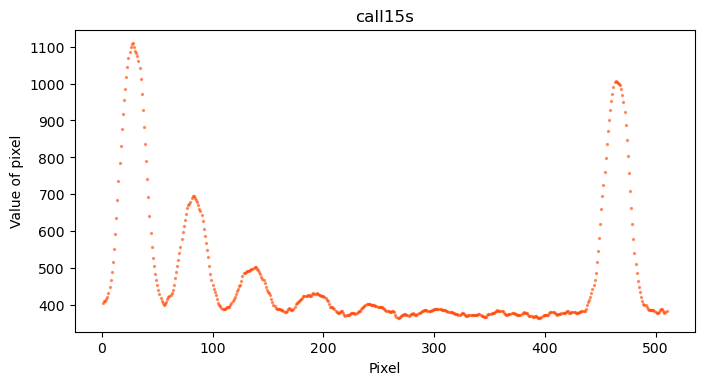

In [20]:
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_15s) + 1)
ax.scatter(x,mean_15s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call15s')

<ipython-input-21-7fbcf1644117>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_1, mean_15s[[peak_indexes_1]], color = 'y', s = 10, marker = 'D', label = 'maxima')


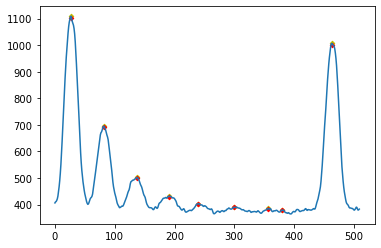

In [21]:
peak_indexes_1,peak_mean_1 = peaks(mean_15s,order=18) #func_peaks

x1 = np.arange(0,len(mean_15s))
plt.plot(x1,mean_15s)
plt.scatter(peak_indexes_1, mean_15s[[peak_indexes_1]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_1, peak_mean_1, color = 'r', s = 10, marker = 'D', label = 'maxima')

172.8749836510982
-7.125016348901795


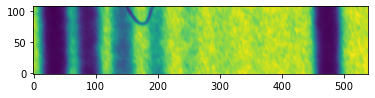

In [22]:
shape1 = o_call30s.shape[1]
shape0 = o_call30s.shape[0]

x1= int((0.4) * shape1)
y1= int((1-0.549) * shape0)
x2= int((0.597) * shape1)
y2= int((1-0.593) * shape0)
x3= int((0.612) * shape1)
y3= int((1-0.526) * shape0)
x4= int((0.415) * shape1)
y4= int((1-0.482) * shape0)

#image_5s,mean_ax25s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_30s,mean_30s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_30s_29-6-3200dpi.fit.fits.jpg',o_call30s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call30s')

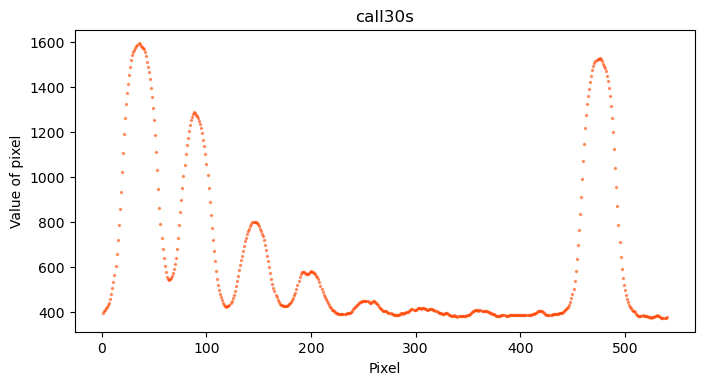

In [23]:
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_30s) + 1)
ax.scatter(x,mean_30s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call30s')

<ipython-input-24-090ce58aea32>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_2, mean_30s[[peak_indexes_2]], color = 'y', s = 10, marker = 'D', label = 'maxima')


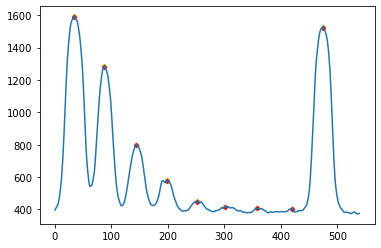

In [24]:
peak_indexes_2,peak_mean_2 = peaks(mean_30s,order=18) #func_peaks

x1 = np.arange(0,len(mean_30s))
plt.plot(x1,mean_30s)
plt.scatter(peak_indexes_2, mean_30s[[peak_indexes_2]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_2, peak_mean_2, color = 'r', s = 10, marker = 'D', label = 'maxima')

172.25864175030048
-7.741358249699516


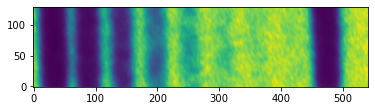

In [25]:
shape1 = o_call1m.shape[1]
shape0 = o_call1m.shape[0]

x1= int((0.423) * shape1)
y1= int((1-0.571) * shape0)
x2= int((0.62) * shape1)
y2= int((1-0.619) * shape0)
x3= int((0.64) * shape1)
y3= int((1-0.541) * shape0)
x4= int((0.442) * shape1)
y4= int((1-0.493) * shape0)

#image_5s,mean_ax25s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_1m,mean_1m= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_1m_29-6-3200dpi.fit.fits.jpg',o_call1m,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call1m')

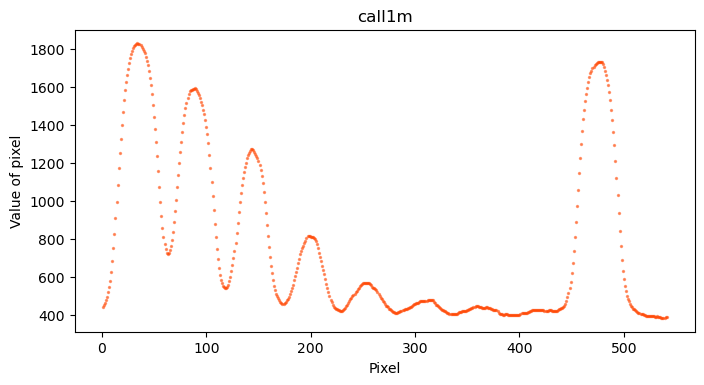

In [26]:
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_1m) + 1)
ax.scatter(x,mean_1m,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call1m')

<ipython-input-27-b11fda3fffdf>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_3, mean_1m[[peak_indexes_3]], color = 'y', s = 10, marker = 'D', label = 'maxima')


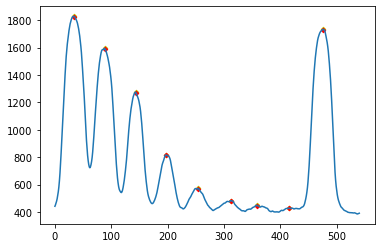

In [27]:
peak_indexes_3,peak_mean_3 = peaks(mean_1m,order=18) #func_peaks

x1 = np.arange(0,len(mean_1m))
plt.plot(x1,mean_1m)
plt.scatter(peak_indexes_3, mean_1m[[peak_indexes_3]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_3, peak_mean_3, color = 'r', s = 10, marker = 'D', label = 'maxima')

172.06132462148688
-7.938675378513125


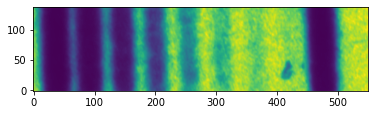

In [28]:
shape1 = o_call1m30s.shape[1]
shape0 = o_call1m30s.shape[0]

x1= int((0.434) * shape1)
y1= int((1-0.558) * shape0)
x2= int((0.634) * shape1)
y2= int((1-0.608) * shape0)
x3= int((0.655) * shape1)
y3= int((1-0.525) * shape0)
x4= int((0.454) * shape1)
y4= int((1-0.475) * shape0)

#image_5s,mean_ax25s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_1m30s,mean_1m30s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_1m30s_29-6-3200dpi.fit.fits.jpg',o_call1m30s,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call1m30s')

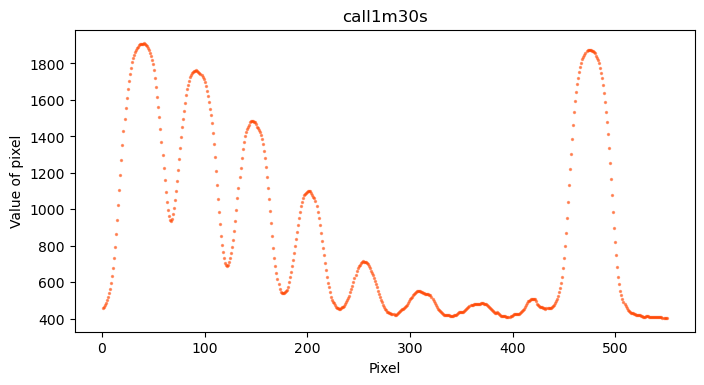

In [29]:
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_1m30s) + 1)
ax.scatter(x,mean_1m30s,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call1m30s')

<ipython-input-30-1ceda9058a94>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_4, mean_1m30s[[peak_indexes_4]], color = 'y', s = 10, marker = 'D', label = 'maxima')


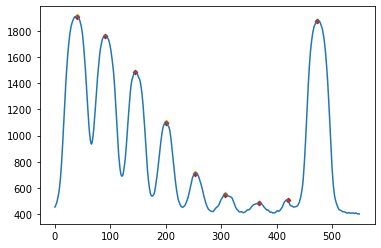

In [30]:
peak_indexes_4,peak_mean_4 = peaks(mean_1m30s,order=18) #func_peaks

x1 = np.arange(0,len(mean_1m30s))
plt.plot(x1,mean_1m30s)
plt.scatter(peak_indexes_4, mean_1m30s[[peak_indexes_4]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_4, peak_mean_4, color = 'r', s = 10, marker = 'D', label = 'maxima')

173.07947363097372
-6.920526369026277


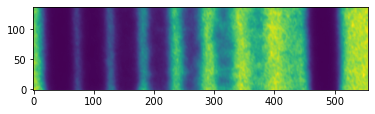

In [31]:
shape1 = o_call3m.shape[1]
shape0 = o_call3m.shape[0]

x1= int((0.371) * shape1)
y1= int((1-0.533) * shape0)
x2= int((0.574) * shape1)
y2= int((1-0.577) * shape0)
x3= int((0.592) * shape1)
y3= int((1-0.492) * shape0)
x4= int((0.389) * shape1)
y4= int((1-0.448) * shape0)

#image_5s,mean_ax25s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_3m,mean_3m= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_3m_29-6-3200dpi.fit.fits.jpg',o_call3m,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call3m')

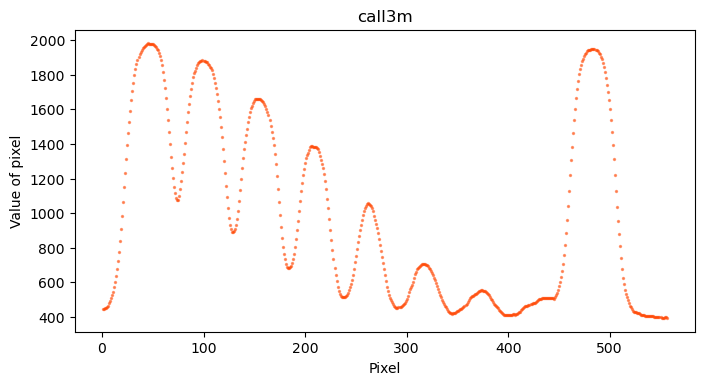

In [32]:
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_3m) + 1)
ax.scatter(x,mean_3m,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call3m')

<ipython-input-33-e783d114e7d7>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(good_peaks_5, mean_3m[[good_peaks_5]], color = 'y', s = 10, marker = 'D', label = 'maxima')


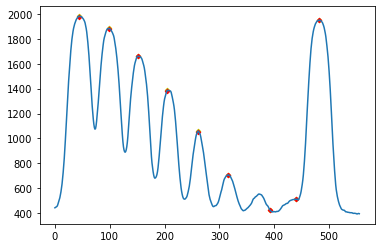

In [33]:
# peak_indexes_5,peak_mean_5 = peaks(mean_3m,order=5) #func_peaks
good_peaks_5, peak_mean_5 = peaks_our(mean_3m)
x1 = np.arange(0,len(mean_3m))
plt.plot(x1,mean_3m)
plt.scatter(good_peaks_5, mean_3m[[good_peaks_5]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(good_peaks_5, peak_mean_5, color = 'r', s = 10, marker = 'D', label = 'maxima')

176.05133349522643
-3.94866650477357


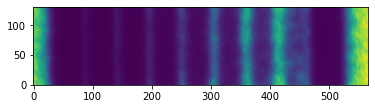

In [34]:
shape1 = o_call6m.shape[1]
shape0 = o_call6m.shape[0]

x1= int((0.42) * shape1)
y1= int((1-0.526) * shape0)
x2= int((0.651) * shape1)
y2= int((1-0.552) * shape0)
x3= int((0.661) * shape1)
y3= int((1-0.467) * shape0)
x4= int((0.43) * shape1)
y4= int((1-0.441) * shape0)

#image_5s,mean_ax25s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_6m,mean_6m= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_6m_29-6-3200dpi.fit.fits.jpg',o_call6m,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call6m')

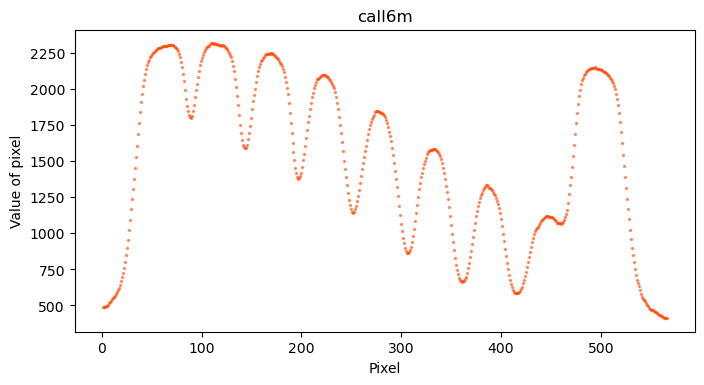

In [35]:
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_6m) + 1)
ax.scatter(x,mean_6m,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call6m')

<ipython-input-36-60d43b09a933>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_6, mean_6m[[peak_indexes_6]], color = 'y', s = 10, marker = 'D', label = 'maxima')


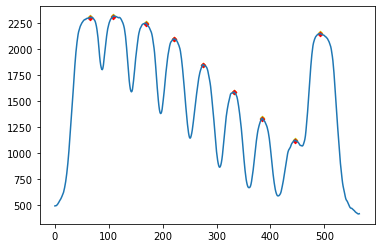

In [36]:
peak_indexes_6,peak_mean_6 = peaks(mean_6m,order=18) #func_peaks

x1 = np.arange(0,len(mean_6m))
plt.plot(x1,mean_6m)
plt.scatter(peak_indexes_6, mean_6m[[peak_indexes_6]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_6, peak_mean_6, color = 'r', s = 10, marker = 'D', label = 'maxima')

174.14398641457103
-5.856013585428968


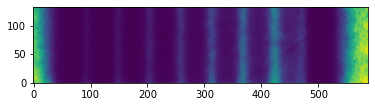

In [37]:
shape1 = o_call7m.shape[1]
shape0 = o_call7m.shape[0]

x1= int((0.374) * shape1)
y1= int((1-0.534) * shape0)
x2= int((0.589) * shape1)
y2= int((1-0.573) * shape0)
x3= int((0.604) * shape1)
y3= int((1-0.491) * shape0)
x4= int((0.39) * shape1)
y4= int((1-0.451) * shape0)

#image_5s,mean_ax25s= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/FITS/Calibrovka_16-6_5s_3200dpi.fit.fits.jpg',o_call5s,x1,y1,x2,y2,x3,y3,x4,y4)
image_7m,mean_7m= subimage_preob('/home/adel/Astro/Galaxies/test_scan/FIT/Calibrovka_16-17.04.1988_7m_29-6-3200dpi.fit.fits.jpg',o_call7m,x1,y1,x2,y2,x3,y3,x4,y4)

Text(0.5, 1.0, 'call7m')

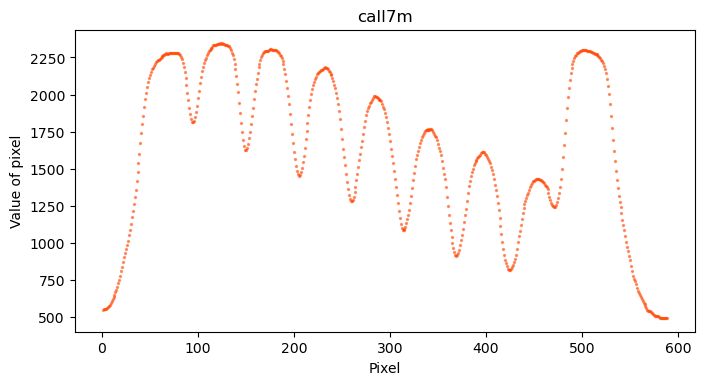

In [38]:
fig = plt.figure(figsize=(8,4),dpi = 100)
ax = fig.add_subplot(111)
x = np.arange(1, len(mean_7m) + 1)
ax.scatter(x,mean_7m,color = 'orangered', s = 2, alpha = 0.5)
ax.set_xlabel("Pixel")
ax.set_ylabel("Value of pixel")
ax.set_title('call7m')

<ipython-input-39-64a0cfb0ad5c>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(peak_indexes_7, mean_7m[[peak_indexes_7]], color = 'y', s = 10, marker = 'D', label = 'maxima')


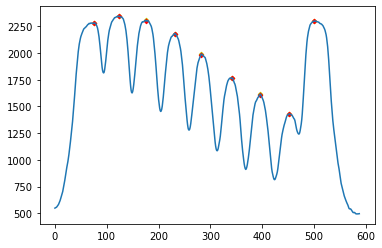

In [39]:
peak_indexes_7,peak_mean_7 = peaks(mean_7m,order=18) #func_peaks

x1 = np.arange(0,len(mean_7m))
plt.plot(x1,mean_7m)
plt.scatter(peak_indexes_7, mean_7m[[peak_indexes_7]], color = 'y', s = 10, marker = 'D', label = 'maxima')
plt.scatter(peak_indexes_7, peak_mean_7, color = 'r', s = 10, marker = 'D', label = 'maxima')

In [52]:
#Data for step attenuators in stellar magnitudes (L.N. gave) 
mag_before_1972 = [0,0.61,1.1,1.47,1.84,2.25,2.66,3.04,0]
mag_after_1972 = [0,0.5,0.97,1.44,1.93,2.43,2.69,3.04,0]
# ________________экспозиции из журнала(настоящие)_______________
delta_m1 = 2.5*np.log(420/100)
delta_m2 = 2.5*np.log(420/130)
delta_m3 = 2.5*np.log(420/175)
delta_m4 = 2.5*np.log(420/190)
delta_m5 = 2.5*np.log(420/210)
delta_m6 = 2.5*np.log(420/380)
delta_m7 = 2.5*np.log(420/420)
#_________________подборка экспозиций,чтобы кривая легла нормально______
# delta_m1 = 2.5*np.log(420/15)
# delta_m2 = 2.5*np.log(420/30)
# delta_m3 = 2.5*np.log(420/60)
# delta_m4 = 2.5*np.log(420/90)
# delta_m5 = 2.5*np.log(420/180)
# delta_m6 = 2.5*np.log(420/360)
# delta_m7 = 2.5*np.log(420/420)

In [42]:
print(len(peak_mean_1))
print(len(peak_mean_2))
print(len(peak_mean_3))
print(len(peak_mean_4))
print(len(peak_mean_5))
print(len(peak_mean_6))
print(len(peak_mean_7))

9
9
9
9
9
9
9


Text(0, 0.5, 'Почернение')

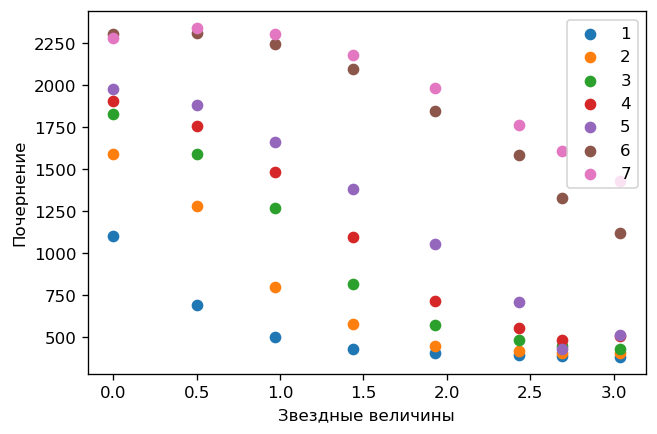

In [54]:
plt.figure(figsize=(6,4),dpi=120)

plt.scatter(mag_after_1972[:-1],peak_mean_1[:-1], label=1)
plt.scatter(mag_after_1972[:-1],peak_mean_2[:-1], label=2)
plt.scatter(mag_after_1972[:-1],peak_mean_3[:-1], label=3)
plt.scatter(mag_after_1972[:-1],peak_mean_4[:-1], label=4)
plt.scatter(mag_after_1972[:-1],peak_mean_5[:-1], label=5)
plt.scatter(mag_after_1972[:-1],peak_mean_6[:-1], label=6)
plt.scatter(mag_after_1972[:-1],peak_mean_7[:-1], label=7)

plt.legend()
plt.xlabel("Звездные величины")
plt.ylabel("Почернение")
# plt.savefig("peaks_curve_deviated.jpg")


Text(0, 0.5, 'Почернение')

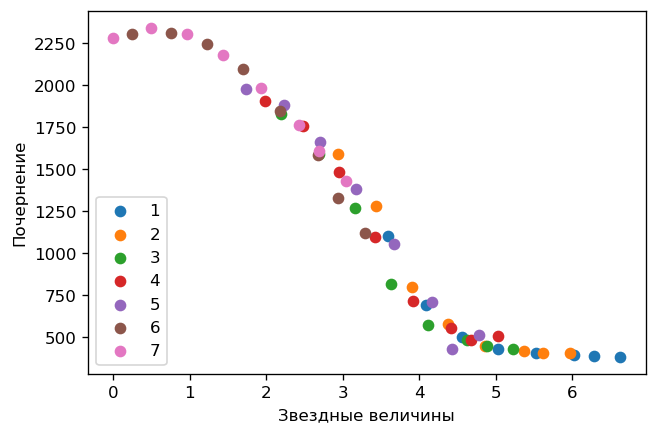

In [53]:
plt.figure(figsize=(6,4),dpi=120)

plt.scatter(mag_after_1972[:-1]+delta_m1,peak_mean_1[:-1], label=1)
plt.scatter(mag_after_1972[:-1]+delta_m2,peak_mean_2[:-1], label=2)
plt.scatter(mag_after_1972[:-1]+delta_m3,peak_mean_3[:-1], label=3)
plt.scatter(mag_after_1972[:-1]+delta_m4,peak_mean_4[:-1], label=4)
plt.scatter(mag_after_1972[:-1]+delta_m5,peak_mean_5[:-1], label=5)
plt.scatter(mag_after_1972[:-1]+delta_m6,peak_mean_6[:-1], label=6)
plt.scatter(mag_after_1972[:-1]+delta_m7,peak_mean_7[:-1], label=7)

plt.legend(loc=3)
plt.xlabel("Звездные величины")
plt.ylabel("Почернение")
# plt.savefig("peaks_curve_alighned.jpg")

In [58]:
array = [peak_mean_1[:-1],peak_mean_2[:-1],peak_mean_3[:-1],peak_mean_4[:-1],peak_mean_5[:-1],peak_mean_6[:-1]]
y_array = np.concatenate(array)
x_array = np.concatenate([mag_after_1972[:-1]+delta_m1,mag_after_1972[:-1]+delta_m2,mag_after_1972[:-1]+delta_m3,mag_after_1972[:-1]+delta_m4,mag_after_1972[:-1]+delta_m5,mag_after_1972[:-1]+delta_m6])

In [59]:

#we calculate mean deveation by calculating delta between each neighboring element, sum it and the devide by number of elements 
c = []
for i in range(1,len(y_array)):
    c.append(abs(y_array[i] - y_array[i-1]))
mean_deviation = np.array(c).sum()/len(y_array)

#now we sort our data: if delta between neighboring elements larger than 2 mean deveation we will remove it
indexes = []
for i in range(1,len(y_array)):
    if abs(y_array[i]-y_array[i-1])>mean_deviation*2:
        indexes.append(i)

y_array = np.delete(y_array,indexes)
x_array = np.delete(x_array,indexes)
#Imax = 10000
xarray_flux = 10000/10**(x_array/2.5)

In [60]:
#now we shoudl sort our data to don't get convoluted curve

a = []
for i in range(0,len(xarray_flux)):
    a.append([xarray_flux[i],y_array[i]])

a.sort(key=lambda x:x[0])

xarray_flux = []
y_array = []

for i in range(0,len(a)):
    xarray_flux.append(a[i][0])
    y_array.append(a[i][1])
    
xarray_flux = np.array(xarray_flux)
y_array = np.array(y_array)       

del a

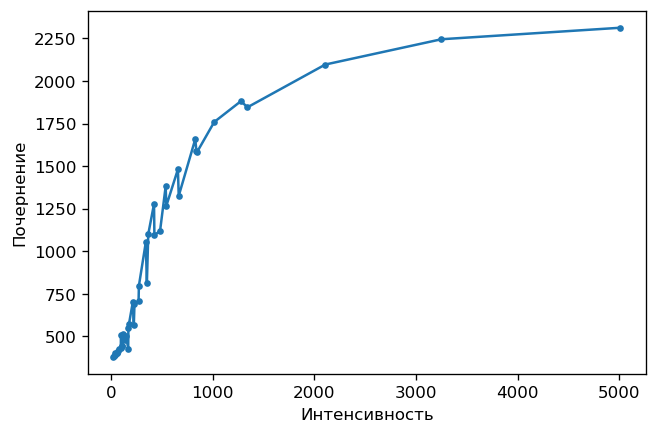

In [61]:
plt.figure(figsize=(6,4),dpi=120)
plt.plot(xarray_flux, y_array, markersize=3,marker='o' )
# plt.ylim(0,4000)
# plt.xlim(0,1000)
plt.xlabel("Интенсивность")
plt.ylabel("Почернение")
plt.savefig("characteristic_curve_first_16-17.04.1988.jpg")

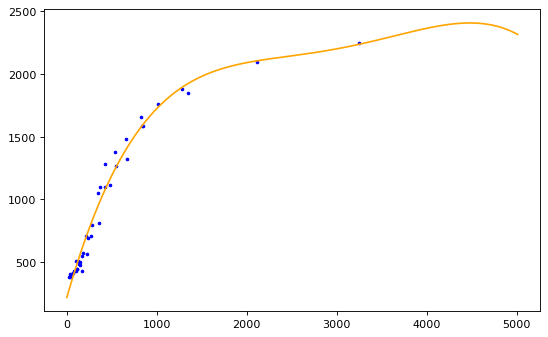

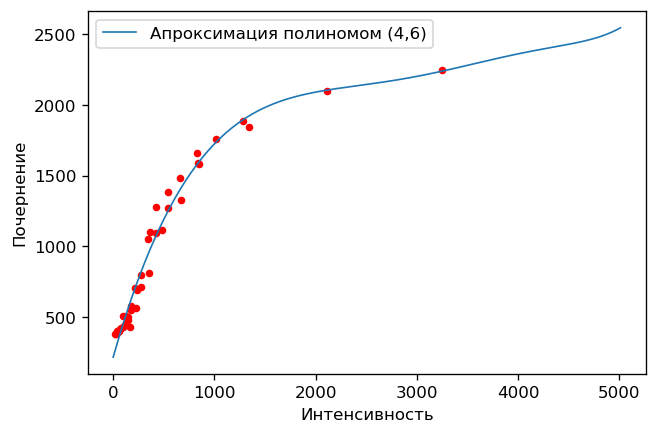

In [84]:
xpp,polinomial = aprx(xarray_flux,y_array,4)

In [85]:
print(polinomial)

           7             6             5             4             3
3.446e-22 x - 4.856e-18 x + 2.671e-14 x - 9.638e-11 x + 3.915e-07 x
             2
 - 0.001342 x + 2.531 x + 217.8


In [91]:
fits_4m_29 = fits.open('/home/adel/Astro/Galaxies/test_scan/FIT/NGC4151_29-6_4m_3200dpi.fit.fits')


data_NGC4151_4m_29  = fits_4m_29[0].data

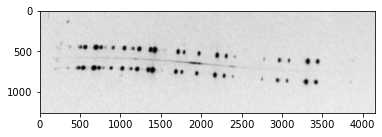

In [92]:
plt.imshow(data_NGC4151_4m_29, cmap='gray')
# plt.axis("off")
plt.imsave("data_NGC4151_4m_29.jpg",data_NGC4151_4m_29)

-90.24371960000306
89.75628039999694


<ipython-input-6-ba3da88bcd7b>:44: RuntimeWarning: divide by zero encountered in true_divide
  array_log10 = np.log10(65536/lina_croped)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)


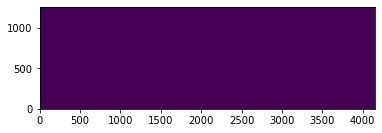

In [93]:
shape1 = data_NGC4151_4m_29.shape[1]
shape0 = data_NGC4151_4m_29.shape[0]

x1= int((0.06) * shape1)
y1= int((1-687) * shape0)
x2= int((0.95) * shape1)
y2= int((1-0.522) * shape0)
x3= int((-0.899) * shape1)
y3= int((1-0.246) * shape0)
x4= int((0.009) * shape1)
y4= int((1-0.411) * shape0)

image_data_NGC4151_4m_29,mean_data_NGC4151_4m_29 = subimage_preob('data_NGC4151_4m_29.jpg',data_NGC4151_4m_29,x1,y1,x2,y2,x3,y3,x4,y4)
del mean_data_NGC4151_4m_29

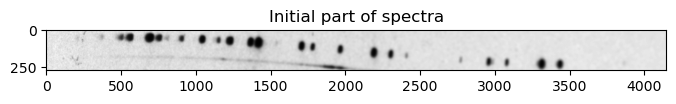

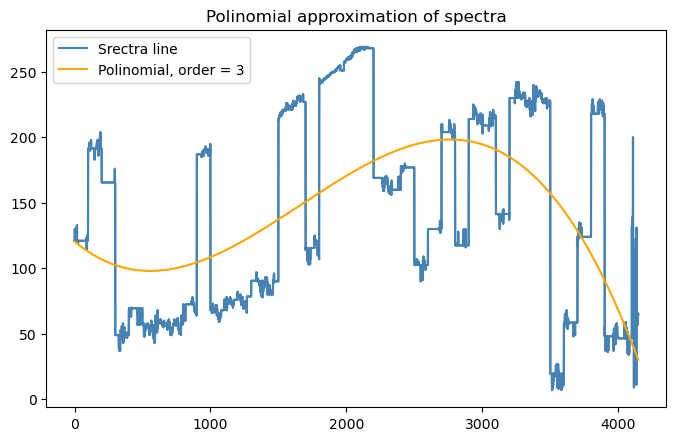

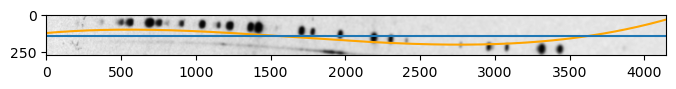

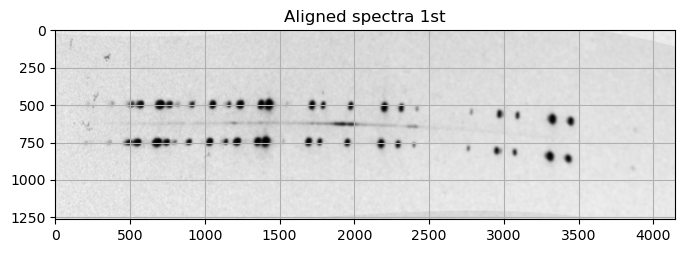

In [119]:
# spectra= polynomial_alighn(image,50,200,5)
# image_data_NGC4151_1m_0 = image_data_NGC4151_1m.max() - image_data_NGC4151_1m
# print(image_data_NGC4151_1m_0)
spectra_NGC4151_4m_29= polynomial_alighn(data_NGC4151_4m_29,400,670,3)

In [123]:
data_NGC4151_4m_29

array([[28231, 28028, 27404, ..., 27840, 27995, 28118],
       [28662, 28813, 28144, ..., 27817, 27962, 28096],
       [28803, 29421, 28976, ..., 27961, 28004, 28046],
       ...,
       [28470, 29302, 29771, ..., 30007, 30015, 29982],
       [28997, 29710, 29976, ..., 29962, 29980, 30037],
       [29497, 29992, 30189, ..., 29982, 29984, 30118]], dtype=uint16)

In [121]:
spectra_NGC4151_4m_29

array([[28434., 28998., 28877., ..., 29900., 29816., 29959.],
       [28593., 28895., 28956., ..., 30105., 29948., 29831.],
       [28870., 28966., 28792., ..., 29916., 30146., 30018.],
       ...,
       [29944., 29878., 29977., ..., 29690., 29784., 29860.],
       [29868., 29921., 29994., ..., 29863., 29693., 29778.],
       [29945., 29898., 29953., ..., 29999., 29799., 30011.]])

In [122]:
spectra_NGC4151_4m_29_2

array([[28923., 29434., 29280., ..., 30129., 30241., 30175.],
       [28883., 29106., 29146., ..., 30185., 30073., 29954.],
       [28776., 28766., 28803., ..., 30223., 30070., 30225.],
       ...,
       [29866., 29977., 29949., ..., 30205., 30044., 30187.],
       [30004., 30142., 30046., ..., 30119., 30171., 30093.],
       [30101., 30159., 29995., ..., 30222., 30110., 30013.]])

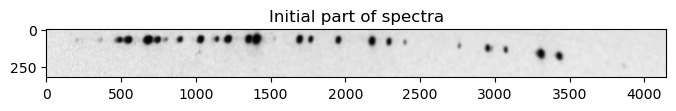

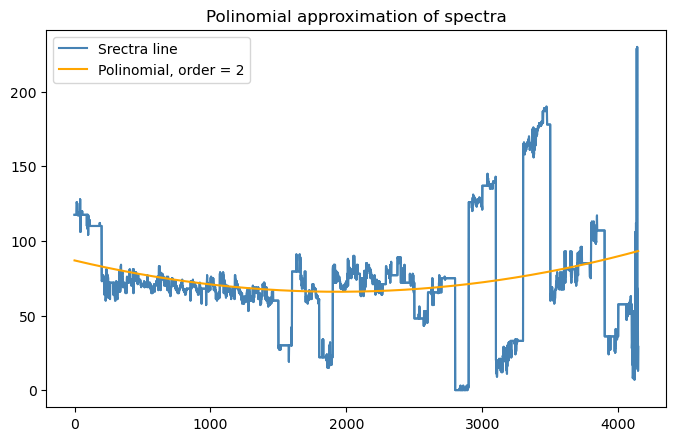

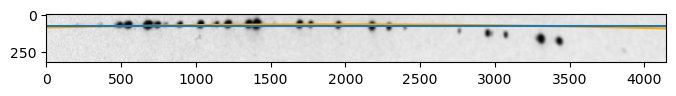

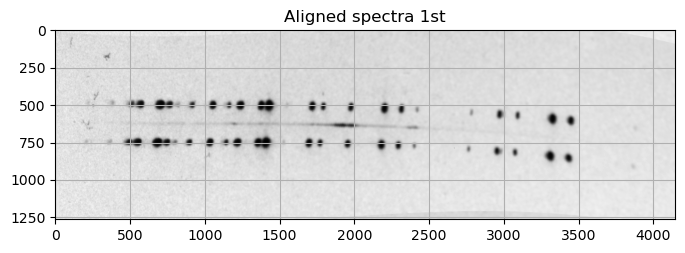

In [125]:
# spectra= polynomial_alighn(image,50,200,5)
# image_data_NGC4151_1m_0 = image_data_NG C4151_1m.max() - image_data_NGC4151_1m
# print(image_data_NGC4151_1m_0)
spectra_NGC4151_4m_29_2= polynomial_alighn(spectra_NGC4151_4m_29,680,1000,2)

In [225]:
spectra_NGC4151_4m_29 = spectra_NGC4151_4m_29_2.max() - spectra_NGC4151_4m_29_2

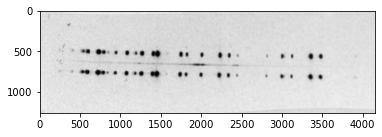

In [226]:
plt.imshow(spectra_NGC4151_4m_29, cmap='gray')

In [129]:
print(spectra_NGC4151_4m_29.max(),spectra_NGC4151_4m_29.min())

32684.0 554.0


In [132]:
data_columns_c = []

for i in range(0,len(spectra_NGC4151_4m_29[0])):
    data_columns_c.append(list(spectra_NGC4151_4m_29[:,i]))
    data_columns_c=list(data_columns_c)
    
    
    
    
# for i in range(0,len(spectra_NGC4151_4m_29)):
#     for j in range(0,len(spectra_NGC4151_4m_29[i])):
#         if spectra_NGC4151_4m_29[i][j] < 27000:
#             spectra_NGC4151_4m_29[i][j]  = spectra_NGC4151_4m_29.min()

#         else: 
#             spectra_NGC4151_4m_29[i][j]  = spectra_NGC4151_4m_29.max()
            

ValueError: too many values to unpack (expected 3)

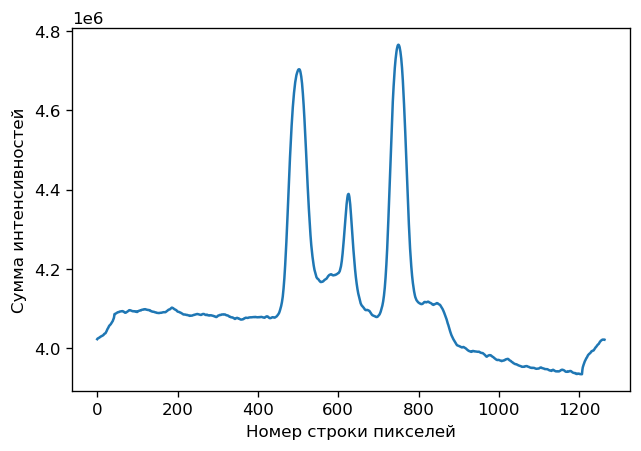

In [124]:
spectra_NGC4151_4m_29_preob,sum_intens_row_NGC4151, spectra_1_NGC4151  = preob_spectra(spectra_NGC4151_4m_29)

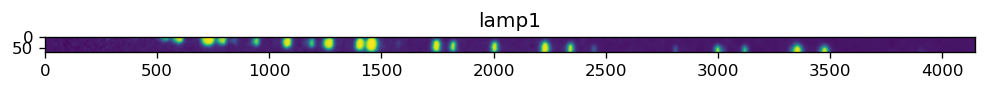

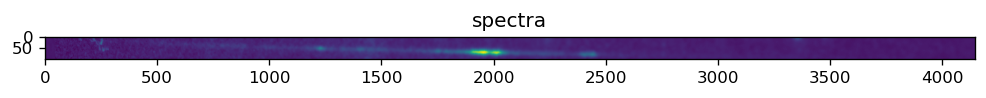

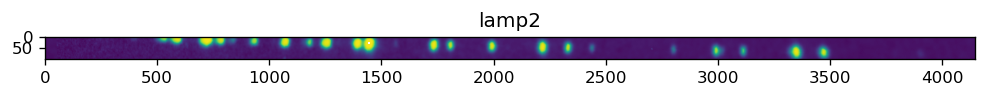

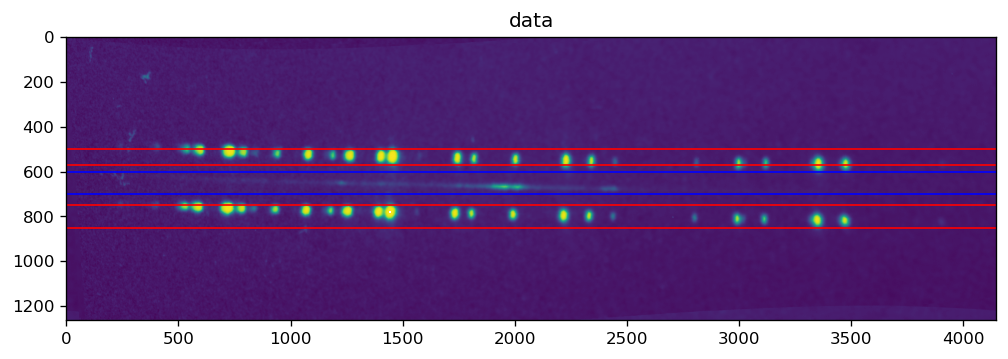

In [231]:
lamp_NGC4151_1m_1, spectra_NGC4151_1m_back, lamp_NGC4151_1m_2 = spectra_lamps(spectra_NGC4151_4m_29_preob,500,570,600,700,750,850)